### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']


In [2]:
from datetime import datetime, timedelta
import os
import yaml
import sqlite3
import json
from collections import Counter
import uuid
from typing import TypedDict, Annotated
import subprocess
import requests
import re

import operator
import pickle

import langchain
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

from langchain_core.output_parsers import SimpleJsonOutputParser, JsonOutputParser, StrOutputParser

from langgraph.graph import StateGraph, START, END

from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

import numpy as np
import pandas as pd
import umap

import sklearn
from sklearn.cluster import DBSCAN

import bs4
from urllib.parse import urljoin, urlparse

import multiprocessing
import asyncio
import aiohttp

from IPython.display import HTML, Image, Markdown, display
import markdown

import openai
from openai import OpenAI

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate


import dotenv
VERBOSE=1
from ainb_const import (DOWNLOAD_DIR, PAGES_DIR,
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, CANONICAL_TOPICS,
                        SOURCECONFIG, FILTER_PROMPT, TOPIC_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT, FINAL_SUMMARY_PROMPT, 
                        TOP_CATEGORIES_PROMPT, REWRITE_PROMPT,
                        MAX_INPUT_TOKENS, MAX_OUTPUT_TOKENS, MAX_RETRIES, TEMPERATURE, SQLITE_DB,
                        HOSTNAME_SKIPLIST, SITE_NAME_SKIPLIST, TOPSOURCES
                       )
from ainb_utilities import (log, delete_files, filter_unseen_urls_db, insert_article,
                            nearest_neighbor_sort, agglomerative_cluster_sort, traveling_salesman_sort_scipy,
                            unicode_to_ascii, send_gmail)
from ainb_webscrape import (get_driver, quit_drivers, launch_drivers, get_file, get_url, parse_file,
                            get_og_tags, get_path_from_url, trimmed_href, process_source_queue_factory,
                            process_url_queue_factory, get_google_news_redirects)
from ainb_llm import (paginate_df, process_pages, fetch_pages, fetch_openai, fetch_all_summaries,
                      fetch_openai_summary, count_tokens, trunc_tokens, 
                      categorize_headline, categorize_df, clean_topics,
                      get_site_name, fetch_missing_site_names)


import asyncio
# need this to run async in jupyter since it already has an asyncio event loop running
import nest_asyncio
nest_asyncio.apply()


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")


Python            3.11.10 | packaged by conda-forge | (main, Sep 10 2024, 10:57:35) [Clang 17.0.6 ]
LangChain         0.3.3
OpenAI            1.52.0
trafilatura       1.12.2
numpy             1.26.4
pandas            2.2.3
sklearn           1.5.2
umap              0.5.6


# Test LLM calling

In [ ]:
# a basic LLM call with langchain
model = ChatOpenAI(model=MODEL)

model.invoke([
    SystemMessage(content="Translate the following from English into Italian"),
    HumanMessage(content='Listen to me. You are beautiful. You are perfect and I love you.'),
])


In [ ]:
# use a langchain template
system_template = "Translate the following into {language}:"
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)
parser = StrOutputParser()
chain = prompt_template | model | parser
chain.invoke({"language": "italian", "text": "hi"})


In [ ]:
# time multiple templants (single-threaded)
prompt_inputs = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

system_template = 'Translate the following into {language}:'
user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

start_time = datetime.now()
for tpl in prompt_inputs:
    response = ""
    # stream tokens as they are generated
    for r in chain.stream(tpl):
        print(r, end="")
        response += r
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")


In [ ]:
# same but send all at once using asyncio

async def async_langchain(chain, input_dict):
    response = await chain.ainvoke(input_dict)
    return response


prompt_templates = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

start_time = datetime.now()
tasks = []
for d in prompt_templates:
    task = asyncio.create_task(async_langchain(chain, d))
    tasks.append(task)
responses = await asyncio.gather(*tasks)
end_time = datetime.now()


difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")
print("\n".join(responses))


In [ ]:
# test o1-preview, note temperature, system prompt not supported
# client = OpenAI()
# response = client.chat.completions.create(
#     model="o1-preview",
#     messages=[
#         {
#             "role": "user",
#             "content": "Write a Python script that takes a matrix represented as a string with format '[1,2],[3,4],[5,6]' and prints the transpose in the same format."
#         }
#     ]
# )
# print(response.choices[0].message.content)


# Functions for state graph
- Each takes a state dict and returns updated state dict
- We will use these later to construct a LangGraph agent workflow

In [9]:
DEBUG = False
N_BROWSERS = 4
MAX_EDITS = 3
before_date = None
# before_date = '2024-10-19 15:00:00'
do_download = True


In [10]:
# class to maintain state within graph

class AgentState(TypedDict):
    AIdf: dict                #  the current working set of headlines (pandas dataframe not supported)
    before_date: str          #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool         #  if False use existing files, else download from sources
    sources: dict             #  sources to scrap
    sources_reverse: dict     #  map file names to sources
    bullets: list             #  bullet points for summary email
    summary: str              #  final summary
    cluster_topics: list      #  list of cluster topics
    n_edits: int              #  count edit iterations so we don't keep editing forever
    edit_complete: bool       #  edit will update if no more edits to make
    # message thread with OpenAI
    # messages: Annotated[list[AnyMessage], operator.add]


In [11]:
test_state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'n_edits': 0,
    'edit_complete': False,
#     'messages': None
    }
)


In [12]:
# Initialize reading configurations from YAML file

def fn_initialize(state: AgentState) -> AgentState:
    """
    Initializes the agent state by loading source configurations from SOURCECONFIG (sources.yaml) .

    Args:
        state (AgentState): The current state of the agent.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        AgentState: The updated state of the agent.

    Raises:
        yaml.YAMLError: If there is an error while loading the YAML file.

    """

    #  load sources to scrape from sources.yaml
    with open(SOURCECONFIG, "r") as stream:
        try:
            state['sources'] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

    log(f"Initialized {len(state['sources'])} items in sources from {SOURCECONFIG}")

    # make a reverse dict to map file titles to source names
    state['sources_reverse'] = {}
    for k, v in state['sources'].items():
        log(f"{k} -> {v['url']} -> {v['title']}.html")
        v['sourcename'] = k
        # map filename (title) to source name
        state['sources_reverse'][v['title']] = k

    log(f"Initialized {len(state['sources_reverse'])} items in sources_reverse")

    return state


if DEBUG:
    test_state = fn_initialize(test_state)


In [13]:
# scrape sources with selenium and save local files in DOWNLOAD_DIR (htmldata)
def fn_download_sources(state: AgentState) -> AgentState:
    """
    Scrapes sources and saves HTML files.
    If state["do_download"] is True, deletes all files in DOWNLOAD_DIR (htmldata) and scrapes fresh copies.
    If state["do_download"] is False, uses existing files in DOWNLOAD_DIR.
    Uses state["sources"] for config info on sources to scrape
    For each source, saves the current filename to state["sources"][sourcename]['latest']

    Args:
        state (AgentState): The current state of the agent.
        do_delete (bool, optional): Whether to delete files in DOWNLOAD_DIR. Defaults to True.

    Returns:
        AgentState: The updated state of the agent.
    """

    if state["do_download"]:
        # empty download directories
        delete_files(DOWNLOAD_DIR)
        delete_files(PAGES_DIR)

        # save each file specified from sources
        log(f"Saving HTML files using {N_BROWSERS} browsers")

        # Create a queue for multiprocessing and populate it
        queue = multiprocessing.Queue()
        for item in state["sources"].values():
            queue.put(item)

        # Function to take the queue and pop entries off and process until none are left
        # lets you create an array of functions with different args
        callable = process_source_queue_factory(queue)

        saved_pages = launch_drivers(N_BROWSERS, callable)
        for sourcename, file in saved_pages:
            log(f"Downloaded {sourcename} to {file}")
            state['sources'][sourcename]['latest'] = file
        log(f"Saved {len(saved_pages)} HTML files")

    else:   # use existing files
        log(f"Web fetch disabled, using existing files in {DOWNLOAD_DIR}")
        # Get the current date
        datestr = datetime.now().strftime("%m_%d_%Y")
        files = [os.path.join(DOWNLOAD_DIR, file)
                 for file in os.listdir(DOWNLOAD_DIR)]
        # filter files with today's date ending in .html
        files = [
            file for file in files if datestr in file and file.endswith(".html")]
        log(f"Found {len(files)} previously downloaded files")
        for file in files:
            log(file)

        saved_pages = []
        for file in files:
            filename = os.path.basename(file)
            # locate date like '01_14_2024' in filename
            position = filename.find(" (" + datestr)
            basename = filename[:position]
            # match to source name
            sourcename = state["sources_reverse"].get(basename)
            if sourcename is None:
                log(f"Skipping {basename}, no sourcename metadata")
                continue
            state["sources"][sourcename]['latest'] = file

    return state

if DEBUG:
    test_state = fn_download_sources(test_state)


In [14]:
def fn_extract_urls(state: AgentState) -> AgentState:
    """
    Extracts news URLs from the latest HTML files matching the patterns defined in the state['sources'] configuration info.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted URLs stored in state['AIdf'].
    """
    # Parse news URLs and titles from downloaded HTML files
    log("Parsing html files")
    all_urls = []
    for sourcename, sourcedict in state['sources'].items():
        filename = sourcedict.get('latest')
        if not filename:
            log(f"no filename found for {sourcename}")
            continue

        log(sourcename + ' -> ' + filename)
        links = parse_file(state['sources'][sourcename])
        log(f"{len(links)} links found")
        all_urls.extend(links)

    log(f"Saved {len(all_urls)} links")

    # make a pandas dataframe of all the links found
    AIdf = (
        pd.DataFrame(all_urls)
        .groupby("url")
        .first()
        .reset_index()
        .sort_values("src")[["src", "title", "url"]]
        .reset_index(drop=True)
        .reset_index(drop=False)
        .rename(columns={"index": "id"})
    )
    state['AIdf'] = AIdf.to_dict(orient='records')

    return state


if DEBUG:
    test_state = fn_extract_urls(test_state)

    # s/b 17 but if some like bloomberg" or wsj are missing, maybe got a robot block
    # if so, download missing ones manually and then re-run fn_extract_urls
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])


In [15]:
# get AI news via newscatcher
# https://docs.newscatcherapi.com/api-docs/endpoints/search-news

newscatcher_sources = ['247wallst.com',
 '9to5mac.com',
 'androidauthority.com',
 'androidcentral.com',
 'androidheadlines.com',
 'appleinsider.com',
 'benzinga.com',
 'cnet.com',
 'cnn.com',
 'digitaltrends.com',
 'engadget.com',
 'fastcompany.com',
 'finextra.com',
 'fintechnews.sg',
 'fonearena.com',
 'ft.com',
 'gadgets360.com',
 'geekwire.com',
 'gizchina.com',
 'gizmochina.com',
 'gizmodo.com',
 'gsmarena.com',
 'hackernoon.com',
 'howtogeek.com',
 'ibtimes.co.uk',
 'itwire.com',
 'lifehacker.com',
 'macrumors.com',
 'mashable.com',
#  'medium.com',
 'mobileworldlive.com',
 'msn.com',
 'nypost.com',
 'phonearena.com',
 'phys.org',
 'popsci.com',
 'scmp.com',
 'sify.com',
 'siliconangle.com',
 'siliconera.com',
 'siliconrepublic.com',
 'slashdot.org',
 'slashgear.com',
 'statnews.com',
 'tech.co',
 'techcrunch.com',
 'techdirt.com',
 'technode.com',
 'technologyreview.com',
 'techopedia.com',
 'techradar.com',
 'techraptor.net',
 'techtimes.com',
 'techxplore.com',
 'telecomtalk.info',
 'thecut.com',
 'thedrum.com',
 'thehill.com',
 'theregister.com',
 'theverge.com',
 'thurrott.com',
 'tipranks.com',
 'tweaktown.com',
 'videocardz.com',
 'washingtonpost.com',
 'wccftech.com',
 'wired.com',
 'xda-developers.com',
 'yahoo.com',
 'zdnet.com']

def fn_extract_newscatcher(state: AgentState) -> AgentState:
    
    q = 'Artificial Intelligence'
    page_size = 100
    log(f"Fetching top {page_size} stories matching {q} from Newscatcher")
    base_url = "https://api.newscatcherapi.com/v2/search"
    time_24h_ago = datetime.now() - timedelta(hours=24)

    # Put API key in headers 
    headers = {'x-api-key': os.getenv('NEWSCATCHER_API_KEY')}

    # Define search parameters
    params = {
        'q': q,
        'lang': 'en',
        'sources': ','.join(newscatcher_sources),
        'from': time_24h_ago.strftime('%Y-%m-%d %H:%M:%S'),
        'to': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'page_size': page_size, # by default should be most highly relevant to the search
        'page': 1
        }

    # Make API call with headers and params
    response = requests.get(base_url, headers=headers, params=params)

    # Encode received results
    results = json.loads(response.text.encode())
    if response.status_code != 200:
        print('ERROR: API call failed.')
        print(results)
        
    # merge into existing df
    newscatcher_df = pd.DataFrame(results['articles'])[['title', 'link']]
    newscatcher_df['src']='Newscatcher'
    newscatcher_df = newscatcher_df.rename(columns={'link': 'url'})
#     display(newscatcher_df.head())
    AIdf = pd.DataFrame(state['AIdf'])
#     display(AIdf.head())
    
    max_id = AIdf['id'].max()
    # add id column to newscatcher_df
    newscatcher_df['id'] = range(max_id + 1, max_id + 1 + len(newscatcher_df))
    AIdf = pd.concat([AIdf, newscatcher_df], ignore_index=True)
    state['AIdf'] = AIdf.to_dict(orient='records')
    return state
    

if DEBUG:
    test_state = fn_extract_newscatcher(test_state)
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    

In [16]:
# some debugging stuff
# zdf = pd.DataFrame(test_state["AIdf"])
# zdf.loc[zdf["src"]=='Techmeme']

# connection = sqlite3.connect('articles.db')
# xdf = pd.read_sql_query("SELECT * FROM news_articles", connection)
# connection.close()

# zdf.loc[zdf["title"].str.startswith("NHTSA")] 
# xdf.loc[xdf["title"].str.startswith("NHTSA")] 

# pd.set_option('display.max_rows', 300)  # Ensure up to 300 rows are shown

# xdf.loc[xdf['isAI']> 0].groupby('actual_src') \
#     .count() \
#     .reset_index()[['actual_src', 'id']] \
#     .sort_values('id', ascending=False) \
#     .head(300)


In [17]:
# sqlite schema to store previously processed 
# CREATE TABLE news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# , timestamp DATETIME, actual_url TEXT, actual_src TEXT);
#
# CREATE TABLE sites (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     hostname TEXT UNIQUE NOT NULL,
#     site_name TEXT NOT NULL
# );



In [18]:
# filter and clean URLs for new AI stories

def fn_filter_urls(state: AgentState) -> AgentState:
    """
    Filters the URLs in state["AIdf"] to include only those that have not been previously seen,
    and are related to AI according to the response from a ChatGPT prompt.

    Args:
        state (AgentState): The current state of the agent.
        before_date (str, optional): The date before which the URLs should be filtered. Defaults to "".

    Returns:


        AgentState: The updated state of the agent with the filtered URLs stored in state["AIdf"].

    """
    # filter to URL not previously seen
    AIdf = pd.DataFrame(state["AIdf"])

    AIdf = filter_unseen_urls_db(AIdf, before_date=state["before_date"])

    if len(AIdf) == 0:
        log("No new URLs, returning")
        return state

    # dedupe identical headlines
    # filter similar titles differing by type of quote or something
    AIdf['title'] = AIdf['title'].apply(unicode_to_ascii)
    AIdf['title_clean'] = AIdf['title'].map(lambda s: "".join(s.split()))
    AIdf = AIdf.sort_values("src") \
        .groupby("title_clean") \
        .first() \
        .reset_index(drop=True) \
        .drop(columns=['id']) \
        .reset_index() \
        .rename(columns={'index': 'id'})
    log(f"Found {len(AIdf)} unique new headlines")

    # structured response format
    json_schema = {
        "name": "json_schema",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "isai_array": {
                    "type": "array",
                    "items": {
                        "type": "object",
                                "properties": {
                                    "id": {
                                        "type": "number"
                                    },
                                    "isAI": {
                                        "type": "boolean"
                                    }
                                },
                        "required": ["id", "isAI"],
                        "additionalProperties": False
                    }
                }
            },
            "required": ["isai_array"],
            "additionalProperties": False
        }
    }

    # filter AI-related headlines using a prompt
    pages = paginate_df(AIdf)
    enriched_urls = asyncio.run(fetch_pages(pages, prompt=FILTER_PROMPT, json_schema=json_schema))
    filter_df = pd.DataFrame(enriched_urls)
    
    try:  # for idempotency
        AIdf = AIdf.drop(columns=['isAI'])
    except:
        pass

    # merge returned df with isAI column into original df on id column
    AIdf = pd.merge(AIdf, filter_df, on="id", how="outer")
    log(AIdf.columns)
    # set hostname based on actualurl
    AIdf['actual_url'] = AIdf['url']    # ideally resolve redirects but Google News blocks
    AIdf['hostname']=AIdf['actual_url'].apply(lambda url: urlparse(url).netloc)

    # update SQLite database with all seen URLs (we are doing this using url and ignoring redirects)
    log(f"Inserting {len(AIdf)} URLs into {SQLITE_DB}")
    conn = sqlite3.connect(SQLITE_DB)
    cursor = conn.cursor()
    for row in AIdf.itertuples():
        insert_article(conn, cursor, row.src, row.hostname, row.title,
                       row.url, row.actual_url, row.isAI, datetime.now().date())

    # keep headlines that are related to AI
    AIdf = AIdf.loc[AIdf["isAI"]==1] \
        .reset_index(drop=True)  \
        .reset_index()  \
        .drop(columns=["id"])  \
        .rename(columns={'index': 'id'})

    log(f"Found {len(AIdf)} AI headlines")

    # update actual URLs for Google News redirects
    # I think Google changed something so this no longer works, instead of a 301 redirct
    # get a javascript page that redirects. Also tomorrow we might see different URLs for same stories
    # AIdf = get_google_news_redirects(AIdf)

    conn = sqlite3.connect('articles.db')
    query = "select * from sites"
    sites_df = pd.read_sql_query(query, conn)
    sites_dict = {row.hostname:row.site_name for row in sites_df.itertuples()}
    conn.close()

    # get clean site_name
    AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))

    # if any missing clean site names, populate them using OpenAI
    missing_site_names =  len(AIdf.loc[AIdf['site_name']==""])
    if missing_site_names:
        log(f"Asking OpenAI for {missing_site_names} missing site names")
        responses = asyncio.run(fetch_missing_site_names(AIdf))
        # update site_dict from responses
        new_urls = []
        for r in responses:
            if r['url'].startswith('https://'):
                r['url'] = r['url'][8:]
            new_urls.append(r['url'])
            sites_dict[r['url']] = r['site_name']
            log(f"Looked up {r['url']} -> {r['site_name']}")
        # update sites table with new names
        for url in new_urls:
            sqlstr = "INSERT OR IGNORE INTO sites (hostname, site_name) VALUES (?, ?);"
            log(f"Updated {url} -> {sites_dict[url]}")
            conn.execute(sqlstr, (url, sites_dict[url]))
            conn.commit()
        # reapply to AIdf with updated sites
        AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))
    else:
        log("No missing site names")
  
    # drop banned slop sites

    AIdf = AIdf.loc[~AIdf["hostname"].str.lower().isin(HOSTNAME_SKIPLIST)]
    AIdf = AIdf.loc[~AIdf["site_name"].str.lower().isin(SITE_NAME_SKIPLIST)]
    
    state["AIdf"] = AIdf.to_dict(orient='records')
    return state


if DEBUG:
    test_state = fn_filter_urls(test_state)
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    display(list(pd.DataFrame(test_state["AIdf"]).columns))



In [19]:
# for row in pd.DataFrame(test_state["AIdf"]).itertuples():
#     display(Markdown(f"[{row.id}. {row.title} - {row.src}]({row.url})"))


In [20]:
# Function for topic extraction
# TODO: could send more prompts to gpt-4o-mini and not hit rate limits
def clean_topics(row, lcategories):
    """
    Cleans the extracted_topics and assigned_topics by removing certain common topics and combining them into a single list.

    Args:
        row (pandas.Series): The row containing the extracted_topics and assigned_topics.
        lcategories (set): The set of lowercase categories.

    Returns:
        list: The cleaned and combined list of topics.
    """
    extracted_topics = [x.title() for x in row.extracted_topics if x.lower() not in {"technology", "ai", "artificial intelligence"}]
    assigned_topics = [x.title() for x in row.assigned_topics if x.lower() in lcategories]
    combined = sorted(list(set(extracted_topics + assigned_topics)))
    combined = [s.replace("Ai", "AI") for s in combined]
    combined = [s.replace("Genai", "Gen AI") for s in combined]
    combined = [s.replace("Openai", "OpenAI") for s in combined]

    return combined


async def do_cat(AIdf, categories):
    """
    Sends a prompt to ChatGPT to select topics for the title for each row in AIdf
    which match the topics in categories.

    Args:
        AIdf (pandas.DataFrame): The DataFrame containing the headlines.
        categories (list): The list of topics to match with the headlines.

    Returns:
        dict: A dictionary where the keys are the row IDs and the values are lists
        of selected topics for each headline.

    """

    catdict = {}
    async with aiohttp.ClientSession() as session:
        for i, row in enumerate(AIdf.itertuples()):
            tasks = []
            log(f"Categorizing headline {row.id+1} of {len(AIdf)}")
            h = row.title
            log(h)
            for c in categories:
                task = asyncio.create_task(categorize_headline(h, c, session))
                tasks.append(task)
            responses = await asyncio.gather(*tasks)
            catdict[row.id] = [item for sublist in responses for item in sublist]
            log(str(catdict[row.id]))

    return catdict


def fn_topic_analysis(state: AgentState) -> AgentState:

    """
    Extracts and selects topics for each headline in the state['AIdf'] dataframe, scrubs them, and stores them back in the dataframe.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted and selected topics stored in state['AIdf'].
    """
    AIdf = pd.DataFrame(state["AIdf"])
    pages = paginate_df(AIdf)
    # apply topic extraction prompt to AI headlines
    log("start free-form topic extraction")
    json_schema = {
        "name": "extracted_topics",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "extracted_topics": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "id": {
                                "type": "number",
                            },
                            "topics": {
                                "type": "array",
                                "items": {
                                    "type": "string",
                                },
                            },
                        },
                        "required": ["id", "topics"],
                        "additionalProperties": False,
                    }
                }
            },
            "required": ["extracted_topics"],
            "additionalProperties": False,
        }
    }
    response = asyncio.run(fetch_pages(pages, prompt=TOPIC_PROMPT, json_schema=json_schema))
    topic_df = pd.DataFrame(response)
    topic_df = topic_df.rename(columns={'topics': 'extracted_topics'})
    log(f"{len(topic_df)} free-form topics extracted")
    all_topics = [item.lower() for row in topic_df.itertuples() for item in row.extracted_topics]
    item_counts = Counter(all_topics)
    filtered_topics = [item for item in item_counts if item_counts[item] >= 2 and item not in {'technology', 'ai', 'artificial intelligence'}]

    categories = sorted(CANONICAL_TOPICS)
    # use categories that are canonical or show up twice in freeform
    lcategories = set([c.lower() for c in categories] + [c.lower() for c in filtered_topics])
    # new topics
    log([c for c in filtered_topics if c not in categories])

    catdict = asyncio.run(categorize_headline(AIdf, categories=categories))
    topic_df['assigned_topics'] = topic_df['id'].apply(lambda id: catdict.get(id, ""))

    topic_df["topics"] = topic_df.apply(lambda t: clean_topics(t, lcategories), axis=1)
    topic_df["topic_str"] = topic_df.apply(lambda row: ", ".join(row.topics), axis=1)

    try: # for idempotency
        AIdf = AIdf.drop(columns=['topic_str', 'title_topic_str'])
    except:
        pass

    AIdf = pd.merge(AIdf, topic_df[["id", "topic_str"]], on="id", how="outer")
    AIdf['title_topic_str'] = AIdf.apply(lambda row: f'{row.title} (Topics: {row.topic_str})', axis=1)

    state["AIdf"] = AIdf.to_dict(orient='records')
    return state

if DEBUG:
    test_state = fn_topic_analysis(test_state)


In [21]:
async def write_topic_name(topic_list_str, max_retries=3, model=LOWCOST_MODEL):
    """
    Generates a name for a cluster based on a list of headline topics.

    Parameters:
    session (aiohttp.ClientSession): The client session for making async HTTP requests.
    topic_list_str (str): A string containing the list of headline topics.
    max_retries (int, optional): The maximum number of retries in case of an error. Defaults to 3.
    model (str, optional): The model to use for generating the topic name. Defaults to LOWCOST_MODEL.

    Returns:
    dict: A dictionary containing the generated topic name.

    Example Usage:
    title_topic_str_list = "Headline 1 (Topic: Topic 1)\n\nHeadline 2 (Topic: Topic 2)"
    result = await write_topic_name(session, title_topic_str_list)
    print(result)

    Output:
    {"topic_title": "Generated Topic Name"}
    ```
    """
    TOPIC_WRITER_PROMPT = f"""
You are a topic writing assistant. I will provide a list of headlines with extracted topics in parentheses.
Your task is to propose a name for a topic that very simply, clearly and accurately captures all the provided
headlines in less than 7 words. You will output a JSON object with the key "topic_title".

Example Input:
In the latest issue of Caixins weekly magazine: CATL Bets on 'Skateboard Chassis' and Battery Swaps to Dispell Market Concerns (powered by AI) (Topics: Battery Swaps, Catl, China, Market Concerns, Skateboard Chassis)

AI, cheap EVs, future Chevy  the week (Topics: Chevy, Evs)

Electric Vehicles and AI: Driving the Consumer & World Forward (Topics: Consumer, Electric Vehicles, Technology)

Example Output:
{{"topic_title": "Electric Vehicles"}}

Task
Propose the name for the overall topic based on the following provided headlines and individual topics:

{topic_list_str}
"""

    for i in range(max_retries):
        try:
            messages=[
                      {"role": "user", "content": TOPIC_WRITER_PROMPT
                      }]

            payload = {"model":  model,
                       "response_format": {"type": "json_object"},
                       "messages": messages,
                       "temperature": 0
                       }
#             print(topic_list_str)

            async with aiohttp.ClientSession() as session:
                response = asyncio.run(fetch_openai(session, payload))
            response_dict = json.loads(response["choices"][0]["message"]["content"])
            log(response_dict)
            
            return response_dict
        except Exception as exc:
            log(f"Error: {exc}")

    return {}


def fn_topic_clusters(state: AgentState) -> AgentState:
    """
    Fetches embeddings for the headlines, creates clusters of similar articles using DBSCAN, and sorts
    using the clusters and a traveling salesman shortest traversal in embedding space.

    Parameters:
    state (AgentState): The state of the agent.

    Returns:
    AgentState: The updated state of the agent.

    """
    AIdf = pd.DataFrame(state["AIdf"])

    log(f"Fetching embeddings for {len(AIdf)} headlines")
    embedding_model = 'text-embedding-3-large'
    client = OpenAI()
    response = client.embeddings.create(input=AIdf['title_topic_str'].tolist(),
                                        model=embedding_model)
    embedding_df = pd.DataFrame([e.model_dump()['embedding'] for e in response.data])

    # greedy traveling salesman sort
    log(f"Sort with nearest_neighbor_sort sort")
    sorted_indices = nearest_neighbor_sort(embedding_df)
    AIdf['sort_order'] = sorted_indices

    # do dimensionality reduction on embedding_df and cluster analysis
    log(f"Load umap dimensionality reduction model")
    with open("reducer.pkl", 'rb') as file:
        # Load the model from the file
        reducer = pickle.load(file)
    log(f"Perform dimensionality reduction")
    reduced_data = reducer.transform(embedding_df)
    log(f"Cluster with DBSCAN")
    dbscan = DBSCAN(eps=0.4, min_samples=3)  # Adjust eps and min_samples as needed
    AIdf['cluster'] = dbscan.fit_predict(reduced_data)
    AIdf.loc[AIdf['cluster'] == -1, 'cluster'] = 999

    # sort first by clusters found by DBSCAN, then by semantic ordering
    AIdf = AIdf.sort_values(['cluster', 'sort_order']) \
        .reset_index(drop=True) \
        .reset_index() \
        .drop(columns=["id"]) \
        .rename(columns={'index': 'id'})

    # show clusters
    state["cluster_topics"] = []
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        for i in range(30):
            try:
                tmpdf = AIdf.loc[AIdf['cluster']==i][["id", "title_topic_str"]]
                if len(tmpdf) ==0:
                    break
                display(tmpdf)
                title_topic_str_list = ("\n\n".join(tmpdf['title_topic_str'].to_list()))
                cluster_topic = asyncio.run(write_topic_name(title_topic_str_list))
                cluster_topic = cluster_topic['topic_title']
                state["cluster_topics"].append(cluster_topic)
                log(f"I dub this cluster: {cluster_topic}")
            except Exception as exc:
                log(exc)
    AIdf["cluster_name"] = AIdf['cluster'].apply(lambda i: state["cluster_topics"][i] 
                                                 if i < len(state["cluster_topics"]) 
                                                 else "")
    state["AIdf"] = AIdf.to_dict(orient='records')
    print(state["cluster_topics"])
    return state

# TODO: could add a quality rating for stories based on site reputation, length, complexity of story
# could then add the quality rating to the summaries and tell the prompt to favor high-quality stories
# could put summaries into vector store and retrieve stories by topic. but then you will have to deal
# with duplicates across categories, ask the prompt to dedupe

# def fn_topic_clusters(state: AgentState) -> AgentState:
#     "call async afn_topic_clusters on state"
#     state = asyncio.run(afn_topic_clusters(state))
#     return state


if DEBUG:
    test_state = fn_topic_clusters(test_state)


In [22]:
# scrape individual pages
def fn_download_pages(state: AgentState) -> AgentState:
    """
    Uses several Selenium browser sessions to download all the pages referenced in the
    state["AIdf"] DataFrame and store their pathnames.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the downloaded pages' pathnames stored in the `state["AIdf"]` DataFrame.
    """
    log("Queuing URLs for scraping")
    AIdf = pd.DataFrame(state['AIdf'])
    queue = multiprocessing.Queue()

    count = 0
    for row in AIdf.itertuples():
#         if row.cluster < 999:
        queue.put((row.id, row.url, row.title))
        count +=1
    # scrape urls in queue asynchronously
    num_browsers = 4

    callable = process_url_queue_factory(queue)

    log(f"fetching {count} pages using {num_browsers} browsers")
    saved_pages = launch_drivers(num_browsers, callable)

    pages_df = pd.DataFrame(saved_pages)
    if len(pages_df):
        pages_df.columns = ['id', 'url', 'title', 'path']

        try: # for idempotency
            AIdf = AIdf.drop(columns=['path'])
        except:
            pass        
        AIdf = pd.merge(AIdf, pages_df[["id", "path"]], on='id', how="inner")
    state["AIdf"] = AIdf.to_dict(orient='records')
    return state


if DEBUG:
    test_state = fn_download_pages(test_state)



In [23]:
# summarize individual pages

def fn_summarize_pages(state: AgentState) -> AgentState:
    """
    Reads all the articles, summarizes each one using a ChatGPT prompt, and sends an email with the summaries.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent.

    """
    log("Starting summarize")
    AIdf = pd.DataFrame(state['AIdf'])
    responses = asyncio.run(fetch_all_summaries(AIdf))
    log(f"Received {len(responses)} summaries")
    response_dict = {}
    for i, response in responses:
        try:
            response_str = response["choices"][0]["message"]["content"]
            response_dict[i] = response_str
        except Exception as exc:
            print(exc)

    markdown_str = ''
    bullets = []

    for i, row in enumerate(AIdf.itertuples()):
        try:
            topics = []
            if row.cluster_name:
                topics.append(row.cluster_name)
            if row.topic_str:
                topics.append(row.topic_str)
            topic_str = ", ".join(topics)

            mdstr = f"[{i+1}. {row.title} - {row.site_name}]({row.actual_url})  \n\n {topic_str}  \n\n{response_dict[row.id]} \n\n"
            bullets.append(f"[{row.title} - {row.site_name}]({row.actual_url})\n\nTopics: {row.topic_str} \n\n{response_dict[row.id]}\n\n")
            display(Markdown(mdstr.replace("$","\\\\$")))
            markdown_str += mdstr
        except Exception as exc:
            print("Error:", exc)

    state['bullets'] = bullets
    # Convert Markdown to HTML
    html_str = markdown.markdown(markdown_str, extensions=['extra'])
    # save bullets
    with open('bullets.md', 'w') as f:
        f.write(markdown_str)
    # send email
    log("Sending bullet points email")
    subject = f'AI news bullets {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)

    return state


if DEBUG:
    test_state = fn_summarize_pages(test_state)



In [24]:
def fn_propose_cats(state: AgentState) -> AgentState:
    # ask chatgpt for top categories
    log(f"Proposing categories using {MODEL}")

    model = ChatOpenAI(
        model=MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template("{p}") | model | SimpleJsonOutputParser()
    response = chain.invoke({ "p": TOP_CATEGORIES_PROMPT + "\n\n".join(state["bullets"])})
    suggested_categories = []
    for k, v in response.items():
        suggested_categories.extend(v)
    state["cluster_topics"] = list(set(state["cluster_topics"] + suggested_categories))
    state["cluster_topics"].sort()
    log(f"Proposed categories: {state['cluster_topics']}")
    return state


if DEBUG:
    test_state = fn_propose_cats(test_state)
    print("edit the following proposed topic list and update state['cluster_topics']:")
    print('"' + '",\n"'.join(test_state["cluster_topics"]) + '"')


In [25]:
def fn_compose_summary(state: AgentState) -> AgentState:
    log(f"Composing summary using {HIGHCOST_MODEL}")

    cat_str = "\n".join(state['cluster_topics'])
    bullet_str = "\n~~~\n".join(state["bullets"])
    client = OpenAI()
    response = client.chat.completions.create(
        model=HIGHCOST_MODEL,
        messages=[
            {
                "role": "user",
                "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            }
        ]
    )
#     print(response)
    
#     model = ChatOpenAI(
#         model=HIGHCOST_MODEL,
#         temperature=0.3,
#         model_kwargs={"response_format": {"type": "json_object"}}
#     )

#     chain = ChatPromptTemplate.from_template(FINAL_SUMMARY_PROMPT) | model | SimpleJsonOutputParser()
#     response = chain.invoke({ "cat_str": cat_str, "bullet_str": bullet_str})
#     print(response)
    state["summary"] = response.choices[0].message.content

    return state


if DEBUG:
    test_state = fn_compose_summary(test_state)
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [26]:
#post manually to o1-preview and grab response b/c I don't have API yet
# cat_str = "\n".join(test_state['cluster_topics'])
# bullet_str = "\n~~~\n".join(test_state["bullets"])
# final_summary_prompt = FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
# count_tokens(final_summary_prompt)
# # copy to clipboard to paste in o1-preview
# subprocess.run("pbcopy", universal_newlines=True, input=final_summary_prompt)
# print(final_summary_prompt)


In [27]:
# test_state["summary"] = """
# """

# display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [28]:
def fn_rewrite_summary(state: AgentState) -> AgentState:

#     model = ChatOpenAI(
#         model=HIGHCOST_MODEL,
#         temperature=0.3,
#         model_kwargs={"response_format": {"type": "json_object"}}
#     )

#     chain = ChatPromptTemplate.from_template(REWRITE_PROMPT) | model | SimpleJsonOutputParser()
#     response = chain.invoke({ "summary": state["summary"]})
    log(f"Rewriting summary using {HIGHCOST_MODEL}")

    client = OpenAI()
    response = client.chat.completions.create(
        model=HIGHCOST_MODEL,
        messages=[
            {
                "role": "user",
                "content": REWRITE_PROMPT.format(summary=state["summary"])
            }
        ]
    )
    response_str = response.choices[0].message.content
    state["n_edits"] += 1    
    if response_str.strip().lower().startswith('ok'):
        log("No edits made, edit complete")
        state["edit_complete"] = True
    else:
        state["summary"] = response_str
    return state


if DEBUG:
    test_state = fn_rewrite_summary(test_state)
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [29]:
# rewrite_prompt = (REWRITE_PROMPT.format(summary=test_state["summary"]))
# subprocess.run("pbcopy", universal_newlines=True, input=rewrite_prompt)
# print(rewrite_prompt)


In [30]:
# test_state["summary"] = """
# """

# if DEBUG:
#     display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [31]:
def fn_is_revision_complete(state: AgentState) -> str:
    """update edit_complete if MAX_EDITS exceeded"
    return "complete" if edit_complete else "incomplete"
    """

    if state["n_edits"] >= MAX_EDITS:
        log("Max edits reached")
        state["edit_complete"] = True


    return "complete" if state["edit_complete"] else "incomplete"


if DEBUG:
    test_state["edit_complete"] = fn_is_revision_complete(test_state)
    display(test_state["edit_complete"])


In [32]:
def fn_send_mail(state: AgentState) -> AgentState:

    log("Sending summary email")
    # Convert Markdown to HTML
    html_str = markdown.markdown(state['summary'], extensions=['extra'])
    # extract subject, match a top-level Markdown heading (starts with "# ")
    match = re.search(r"^# (.+)$", state["summary"], re.MULTILINE)
    
    # If a match is found, return the first captured group (the heading text)
    if match:
        subject = match.group(1).strip()
    else:
        subject = f'AI news summary {datetime.now().strftime("%H:%M:%S")}'
    log(f"Email subject {subject}")
    log(f"Email length {len(html_str)}")
        
    # send email
    send_gmail(subject, html_str)
    return state

if DEBUG:
    fn_send_mail(test_statestate)

# Define LangGraph agent state graph

In [33]:
class Agent:

    def __init__(self, state):
        
        self.state = state
        
        graph_builder = StateGraph(AgentState)
        graph_builder.add_node("initialize", self.initialize)
        graph_builder.add_node("download_sources", self.download_sources)
        graph_builder.add_node("extract_web_urls", self.extract_web_urls)
        graph_builder.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
        graph_builder.add_node("filter_urls", self.filter_urls)
        graph_builder.add_node("topic_analysis", self.topic_analysis)
        graph_builder.add_node("topic_clusters", self.topic_clusters)
        graph_builder.add_node("download_pages", self.download_pages)
        graph_builder.add_node("summarize_pages", self.summarize_pages)
        graph_builder.add_node("propose_topics", self.propose_topics)
        graph_builder.add_node("compose_summary", self.compose_summary)
        graph_builder.add_node("rewrite_summary", self.rewrite_summary)
        graph_builder.add_node("send_mail", self.send_mail)

        graph_builder.add_edge(START, "initialize")
        graph_builder.add_edge("initialize", "download_sources")
        graph_builder.add_edge("download_sources", "extract_web_urls")
        graph_builder.add_edge("extract_web_urls", "extract_newscatcher_urls")
        graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
        graph_builder.add_edge("filter_urls", "topic_analysis")
        graph_builder.add_edge("topic_analysis", "topic_clusters")
        graph_builder.add_edge("topic_clusters", "download_pages")
        graph_builder.add_edge("download_pages", "summarize_pages")
        graph_builder.add_edge("summarize_pages", "propose_topics")
        graph_builder.add_edge("propose_topics", "compose_summary")
        graph_builder.add_edge("compose_summary", "rewrite_summary")
        graph_builder.add_conditional_edges("rewrite_summary",
                                            self.is_revision_complete,
                                            {"incomplete": "rewrite_summary",
                                             "complete": "send_mail",
                                            })
        graph_builder.add_edge("send_mail", END)

        # human in the loop should check web pages downloaded ok, and edit proposed categories 
#         self.conn = sqlite3.connect('lg_checkpointer.db')
#         self.checkpointer = SqliteSaver(conn=self.conn)
        self.checkpointer = MemorySaver()
        graph = graph_builder.compile(checkpointer=self.checkpointer,
                                      interrupt_before=["filter_urls", "compose_summary",])
        self.graph = graph


    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_web_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_newscatcher(state)
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state
    
    def run(self, state, config):
        # The config is the **second positional argument** to stream() or invoke()!
        events = self.graph.stream(state, config, stream_mode="values"
        )
        
        for event in events:
            try:
                if event.get('summary'):
                    display(Markdown(event.get('summary').replace("$","\\\\$")))
                elif event.get('bullets'):
                    display(Markdown("\n\n".join(event.get('bullets')).replace("$","\\\\$")))
                elif event.get('cluster_topics'):
                    display(Markdown("\n\n".join(event.get('cluster_topics'))))
                elif event.get('AIdf'):
                    display(pd.DataFrame(event.get('AIdf')).groupby("src").count()[['id']])
                elif event.get('sources'):
                    print([k for k in event.get('sources').keys()])
            except Exception as exc: 
                print(exc)
                
        return self.state

 

# Instantiate agent and show flowchart

2024-10-22 19:36:16,419 - AInewsbot - INFO - Initializing with before_date=None, do_download=False, thread_id=d0f598f318544812b95b43a4d1829253


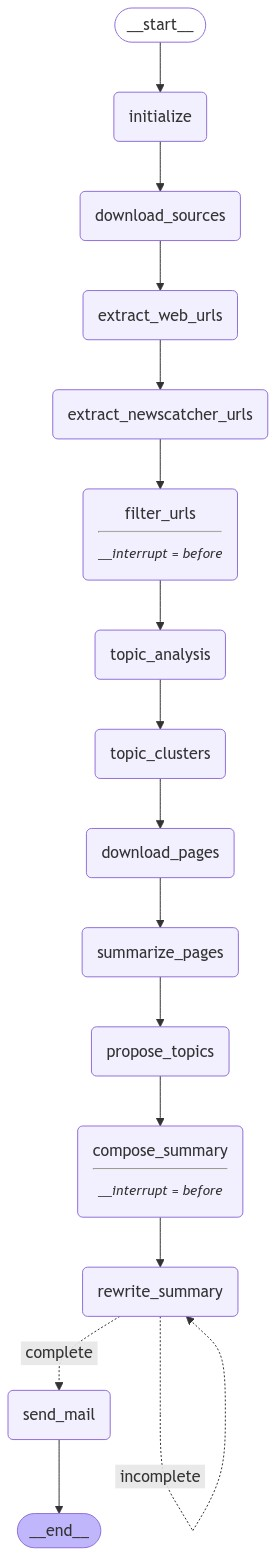

In [35]:
do_download = False
before_date = None
# before_date="2024-10-21 08:00:00"

# initial state
state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'n_edits': 0,
    'edit_complete': False,
    }
)

# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4().hex
config = {"configurable": {"thread_id": thread_id}}

log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")
lg_agent = Agent(state)
display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


# Run each step individually

In [36]:
# download and extract, check all sources downloaded OK
state = lg_agent.initialize(state)
state = lg_agent.download_sources(state)
state = lg_agent.extract_web_urls(state)
state = lg_agent.extract_newscatcher_urls(state)
# s/b 18 check all downloaded, if any got hit by a bot block then download manually
print(len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]))
pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]


2024-10-22 19:36:19,573 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2024-10-22 19:36:19,573 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-10-22 19:36:19,574 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2024-10-22 19:36:19,574 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-10-22 19:36:19,574 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-10-22 19:36:19,575 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-10-22 19:36:19,575 - AInewsbot - INFO - 

2024-10-22 19:36:20,157 - AInewsbot - INFO - 18 links found
2024-10-22 19:36:20,157 - AInewsbot - INFO - Reddit -> htmldata/Reddit multiple subreddits (10_22_2024 07_34_52 PM).html
2024-10-22 19:36:20,189 - AInewsbot - INFO - parse_file - found 273 raw links
2024-10-22 19:36:20,194 - AInewsbot - INFO - parse_file - found 182 filtered links
2024-10-22 19:36:20,194 - AInewsbot - INFO - 182 links found
2024-10-22 19:36:20,194 - AInewsbot - INFO - Techmeme -> htmldata/Techmeme (10_22_2024 07_34_31 PM).html
2024-10-22 19:36:20,207 - AInewsbot - INFO - parse_file - found 274 raw links
2024-10-22 19:36:20,211 - AInewsbot - INFO - parse_file - found 108 filtered links
2024-10-22 19:36:20,212 - AInewsbot - INFO - 108 links found
2024-10-22 19:36:20,212 - AInewsbot - INFO - The Register -> htmldata/The Register (10_22_2024 07_34_33 PM).html
2024-10-22 19:36:20,237 - AInewsbot - INFO - parse_file - found 205 raw links
2024-10-22 19:36:20,241 - AInewsbot - INFO - parse_file - found 110 filtered li

18


,id
src,
Ars Technica,26
Bloomberg Tech,11
Business Insider,50
FT Tech,62
Feedly AI,54
Google News,57
Hacker News,26
Hacker News 2,22
HackerNoon,98


In [37]:
state = lg_agent.filter_urls(state)
pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]


2024-10-22 19:36:23,650 - AInewsbot - INFO - Querying SQLite with where_clause: 
2024-10-22 19:36:24,324 - AInewsbot - INFO - URLs in orig_df: 981
2024-10-22 19:36:24,326 - AInewsbot - INFO - Existing URLs in DB: 167282
2024-10-22 19:36:24,357 - AInewsbot - INFO - New URLs in df filtered by URL: 355
2024-10-22 19:36:24,454 - AInewsbot - INFO - Existing src+title: 17
2024-10-22 19:36:24,455 - AInewsbot - INFO - New URLs in df filtered by src+title: 338
2024-10-22 19:36:24,468 - AInewsbot - INFO - Found 325 unique new headlines
2024-10-22 19:36:24,621 - AInewsbot - INFO - Applying prompt to 7 pages using gpt-4o-mini
2024-10-22 19:36:24,621 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:36:24,622 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:36:24,623 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:36:24,623 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:36:24,623 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:36:24,624 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:36:2

,id
src,
Ars Technica,1
Bloomberg Tech,2
Business Insider,1
FT Tech,3
Feedly AI,43
Google News,24
Hacker News,2
Hacker News 2,2
HackerNoon,2


In [38]:
for row in pd.DataFrame(state["AIdf"]).itertuples():
    display(Markdown(f"[{row.id}. {row.title} - {row.src}]({row.url})"))


[0. 'A nightmare scenario': New ad warns of misleading AI ahead of Election Day - Google News](https://news.google.com/read/CBMixAFBVV95cUxQa3g1eVNISERsMU5RS05NdmhQc0JaUHBtY0FJLU1DMDRPU2VxMUk4STU3Q0k0RnBHRHlzQ1dQelJ5cXVQZlFZMEV3X0pNQVVaX3p2eTZXQmZ3LUREZTZ6Y1NSUkQ1Z00xWGpBSHdGSjJUZkstUzFTYzZtYm53UDlnRl9MX2phQU40T0dIZlVCbkF3c2p4MEdkUHVjMFNieHplTmRLMTBuSlMzMGt6VE5GR25xd3BrajRhODg2QjgwUTRwcXkx0gFkQVVfeXFMT3dsN0owRXNGYWRWU3Q3a3ZON184eFM4WnFDM084T2hhbzBjRG9MNlNUQU5lc2daWkM0WndkQzFlbmJzQW92cFpEc1VTbG1GVTZtNDZDeGxLSnNXNlZDSWthYnBycg)

[1. 'Blade Runner 2049' producers sue Elon Musk and Tesla over AI image at robotaxi event - Newscatcher](https://www.washingtonpost.com/business/2024/10/22/elon-musk-robotaxi-blade-runner-2049-lawsuit/be00f5a2-9081-11ef-b5b1-75167840d9f3_story.html)

[2. 'I'd never seen such an audacious attack on anonymity before': Clearview AI and the creepy tech that can identify you with a single picture - Reddit](https://www.reddit.com/r/technology/comments/1g977nk/id_never_seen_such_an_audacious_attack_on/)

[3. 'This is a game changer': Runway releases new AI facial expression motion capture feature Act-One - VentureBeat](https://venturebeat.com/ai/this-is-a-game-changer-runway-releases-new-ai-facial-expression-motion-capture-feature-act-one/)

[4. 0G Foundation Launches Node Sale for Decentralized AI Network Verification - HackerNoon](https://hackernoon.com/0g-foundation-launches-node-sale-for-decentralized-ai-network-verification)

[5. ABBA, Radiohead and The Cure musicians sign AI protest letter against 'unlicensed use' of works - Feedly AI](https://abcnews.go.com/Business/wireStory/abba-radiohead-cure-musicians-sign-ai-protest-letter-115042563)

[6. AI, Data Centers, Direct Air Capture, and Renewables - Google News](https://news.google.com/read/CBMikAFBVV95cUxNbEJ1U0lBcFVSV3BGSEktWElUaGpzNFQ2YllUVUtVeTBRT0Q4eHEteFJiYW9HZWhGWHZEU2EwbGdUR0h4V0pvb1JoLWNBT3hhcjh5bm1hMXpPTldQbF82SlFFQ1ZDNTlXbDRaaDdRbjNRQnN1enJNOHFHODByVlQtZnZHVmhNRWdhZlNwNVFHYW7SAZYBQVVfeXFMT2RWbURDREhIT0ZyZ2U2TmpiZEUyWXNQaXJuNmluUUlyT05JZndnaEgtcnNiS21kUDI3RzM3QTF3Q1NaVzE0d0Nra0pDbWRYeU5EZHJpc3dqTEJ3aVVtbHN4UEVPaHBOQlpIRlQzdll2MTNHTkdtNkZyR0lwOUM5bTRHOVVCZ0g3QXh0MUZVWlotQWkzZVRn)

[7. AI, No-Code, or Hiring a Dev? Here's How to Build Software in 2025 - HackerNoon](https://hackernoon.com/ai-no-code-or-hiring-a-dev-heres-how-to-build-software-in-2025)

[8. AI, energy transition, M&A will fuel private credit demand - Feedly AI](https://www.axios.com/2024/10/22/private-credit-axios-roundtable-bfd)

[9. AI Deception: How Generative AI is Being Weaponized for Fraud - Feedly AI](https://hackernoon.com/ai-deception-how-generative-ai-is-being-weaponized-for-fraud)

[10. AIMed 2024: A Pioneer in Healthcare Innovation to Join Key AI in Medicine Event - Newscatcher](https://finance.yahoo.com/news/aimed-2024-pioneer-healthcare-innovation-154700353.html)

[11. AI firms need to address security, open-source concerns: G42 exec - Feedly AI](https://www.semafor.com/article/10/22/2024/g42-ibm-make-case-for-open-source-ai-at-semafor-gulf-event)

[12. AI governance is a long-term tailwind, not a 'speed bump' - Newscatcher](https://finance.yahoo.com/video/ai-governance-long-term-tailwind-174002387.html)

[13. AI head-cameras trained to spot and prevent mistakes in medication - Feedly AI](https://newatlas.com/medical-ai/ai-head-cameras-medication-errors/)

[14. AI startup Ideogram launches infinite Canvas for manipulating, combining generated images - VentureBeat](https://venturebeat.com/ai/ai-startup-ideogram-launches-infinite-canvas-for-manipulating-combining-generated-images/)

[15. Albuquerque City Council approve A.I. policy working group - Newscatcher](https://www.yahoo.com/news/albuquerque-city-council-approve-policy-142314300.html)

[16. Amazon-backed Anthropic debuts AI agents that can do complex tasks, racing against OpenAI, Microsoft and Google - Google News](https://news.google.com/read/CBMinwFBVV95cUxOLV9EZDJEYzYxeGJvbkJESE53TDlsdFd3MEZid2pNU3dEOEhmdWx6UnNMTURyUDQwNExCUkdSa3NUcDByaXZuNXlPODZYZmhweG1wSVo4UUJqNjQ0dlBrbDF2alFCYlM5WG0tY3NCSVFmaEVXa1c0cEdmVDB1eXNjMmpFY3ZDU2xkb0NSRW5oOFp4VnR5U2NPUkotT0J4R2_SAaQBQVVfeXFMT3JjZmYyQktKZzJKY0Z1TXhVNl83UGlyZzJPOWVwXzFBZ3ZtUlhGQW90SGJTR25FSzl4akNTLWVZQU5pTnZFNFY3V0x2OWk3SldNUnZEMm4yRmwtX1R2R2tfV3JCTkNQQzVHMEhiVFh5U2wxTTN1Qk1OSUNRMTgzMFFSZTZmRW9MLVNhdVlkZnlmd21WM09oZS1UU0Nab1Z0ZFA0Wk8)

[17. Anthropic's Latest Claude Lets AI Take Control of Your Entire PC - Feedly AI](https://futurism.com/the-byte/anthropic-claude-control-pc)

[18. Anthropic's new AI tool analyzes your screen and acts on your behalf - Newscatcher](https://finance.yahoo.com/news/anthropic-ai-tool-analyzes-screen-150027088.html)

[19. Anthropic publicly releases AI tool that can take over the users mouse cursor - Ars Technica](https://arstechnica.com/ai/2024/10/anthropic-publicly-releases-ai-tool-that-can-take-over-the-users-mouse-cursor/)

[20. Anthropic releases AI to automate mouse clicks for coders - Google News](https://news.google.com/read/CBMivgFBVV95cUxPTWtTaG5wc1YzbDNyVnQtd2NnNlc5QWloS21zaS1sLV9abW5wNHM4TVZyYjlGZXA5Vlk5Nk5haTY1anZSZDl0S2lUT0VLN0ZrcENvVTZuMUhvWVlqTkR4MHhrQzh5V2xJaWw2UjVZWDBKczVmT1RQMTBsVUppcTZQZF9DVHAtOG9jUzVTa0lrcGZ3MkNWQjcxZkw4dVU5aVlGMG13VWFKaVlNZlVPRkJfYzE5bkNqUl9TMDNZUkxn)

[21. Anthropic releases a new Claude 3.5 Sonnet model that can interact with desktop apps by imitating mouse and keyboard input via a computer use API, now in beta - Techmeme](https://techcrunch.com/2024/10/22/anthropics-new-ai-can-control-your-pc/)

[22. Anthropics New AI Tool Analyzes Your Screen and Acts on Your BehalfThe new capability can interpret what a user is seeing on their computer and complete tasks online for them. - Bloomberg Tech](https://www.bloomberg.com/news/articles/2024-10-22/anthropic-s-new-ai-tool-analyzes-your-screen-and-acts-on-your-behalf)

[23. Anthropic says latest AI model can control users computers - FT Tech](https://www.ft.com/content/f49aff66-79e8-437a-93c2-96f8116c1bc3)

[24. Anthropics latest AI update can use a computer on its own - Google News](https://news.google.com/read/CBMikAFBVV95cUxNMGNnMDF3QWJ0cWp5SkpWLW5QVmRjdUhiQ19XNHdNUlM2NHluYXItSm44dHF2ei1LRjNGNHI4cEJlOFkwdmhPNWwyQTdhZml2RHAtcXlxVF9lRUVqRUZqc2VBalRJZEhBYkFnZHNZUEE4WXI5MUQyWlVQVE9BUmZHa1Bfc05Tb2VpM0txS1c2d0M)

[25. Anthropics new AI can use computers like a human, redefining automation for enterprises - VentureBeat](https://venturebeat.com/ai/anthropic-new-ai-can-use-computers-like-a-human-redefining-automation-for-enterprises/)

[26. Artificial Intelligence Macroeconomic Growth Opportunity Research 2024-2030: Focus on European Union, Japan, Singapore, India, Malaysia, and Saudi Arabia - Newscatcher](https://finance.yahoo.com/news/artificial-intelligence-macroeconomic-growth-opportunity-085400497.html)

[27. Artificial intelligenceput in the spotlight at Tech for Global Good awards - Feedly AI](https://www.mercurynews.com/2024/10/22/artificial-intelligence-put-in-the-spotlight-at-tech-for-global-good-awards/)

[28. Asana AI Studio now offers AI agent creation for workflow management - VentureBeat](https://venturebeat.com/ai/asanas-ai-studio-brings-agents-directly-to-workflow-management/)

[29. Asana launches AI Studio in early access, a no-code tool for designing AI agents that can be integrated into teams' existing workflows - Techmeme](https://www.zdnet.com/article/asana-launches-a-no-code-tool-for-designing-ai-agents-aka-your-new-teammates/)

[30. Asana launches a no-code tool for designing AI agents - aka your new 'teammates' - Feedly AI](https://www.zdnet.com/article/asana-launches-a-no-code-tool-for-designing-ai-agents-aka-your-new-teammates/#ftag=RSSbaffb68)

[31. Asia-Pacific AI in Cybersecurity Research Report 2024: $372.98 Bn Market Trends, Country Insights, Competitive Landscape, Forecasts and Opportunities, 2019-2029 - Newscatcher](https://uk.finance.yahoo.com/news/asia-pacific-ai-cybersecurity-research-143500939.html)

[32. Best AI Course 2024 - New Artificial Intelligence Course Launched by Interview Kickstart - Newscatcher](https://finance.yahoo.com/news/best-ai-course-2024-artificial-161700014.html)

[33. Billionaire Jeff Yass Sold 73% of Susquehanna's Stake in Nvidia and Is Piling Into This Beloved Artificial Intelligence (AI) Stock Instead - Newscatcher](https://finance.yahoo.com/news/billionaire-jeff-yass-sold-73-090600749.html)

[34. Billionaires Are Buying These 3 Top Artificial Intelligence (AI) Stocks Hand Over Fist - Newscatcher](https://finance.yahoo.com/news/billionaires-buying-3-top-artificial-103000965.html)

[35. Bjorn Ulvaeus and Thom Yorke among 11,000 artists warning of AI threats - FT Tech](https://www.ft.com/content/c7c0e8bf-9cdd-4a42-8e01-d2a36ba06298)

[36. Building Knowledge Graphs for RAG: Exploring GraphRAG with Neo4j and LangChain - Feedly AI](https://hackernoon.com/building-knowledge-graphs-for-rag-exploring-graphrag-with-neo4j-and-langchain)

[37. BullFrog AI's VP Artificial Intelligence to Present at Google's Cancer AI Symposium - Newscatcher](https://www.benzinga.com/pressreleases/24/10/g41448422/bullfrog-ais-vp-artificial-intelligence-to-present-at-googles-cancer-ai-symposium)

[38. Businesses can now apply to Regional Artificial Intelligence Initiative in the Prairie provinces - Newscatcher](https://finance.yahoo.com/news/businesses-now-apply-regional-artificial-181300374.html)

[39. CMU Researchers Release Pangea-7B: A Fully Open Multimodal Large Language Models MLLMs for 39 Languages - Feedly AI](https://www.marktechpost.com/2024/10/22/cmu-researchers-release-pangea-7b-a-fully-open-multimodal-large-language-models-mllms-for-39-languages/)

[40. Canva introduces new Dream Lab featuring Leonardo.ai image generation - Feedly AI](https://www.zdnet.com/article/canva-introduces-new-dream-lab-featuring-leonardo-ai-image-generation/#ftag=RSSbaffb68)

[41. Canva releases new generative AI features, including Dream Lab, an image generator powered by Leonardo.ai's Phoenix model; Canva acquired Leonardo.ai in July - Techmeme](https://www.theverge.com/2024/10/22/24276662/canva-ai-update-new-text-to-image-generator-leonardo)

[42. Can you spot the celebrity 'deepfakes' in a new ad warning against election disinfo? - Google News](https://news.google.com/read/CBMiogFBVV95cUxOdENVMFhuMzQ0NHdya0pRcHQ3MHZfS1dUYkx0MVJFbFVUU3Y0M0daQWZYZHlZdFRjalc3ZE9nd3BLMjdhVjQ5a1A0R1R4V1Y5a2tUTjVuU0thNE4yZG45ZFlGZkZyR3FxYlJHbkZ5YndIcTU1VTgtWTd3eVpYNTJSMVEtckE2alAxdVd5dkVMcXhwc3ZFSEdEbzhaYkpoX21MU2fSAVZBVV95cUxQdENUVHZEbmEzTHViTGVNSG1wek8wZC1ObXBLMm1ZN0pzTnR6Q3ptaEhwYUMxU182SVRUUm5EdUx2Q01zZ2RYdUVmT19mQ3Y5OVRDeWVNUQ)

[43. Chipotle turns to AI hiring platform to screen job applicants - Feedly AI](https://www.cbsnews.com/news/chipotle-ava-cado-ai-hiring/)

[44. Cohere adds vision to its RAG search capabilities - Feedly AI](https://venturebeat.com/ai/cohere-adds-vision-to-its-rag-search-capabilities/)

[45. Computer use, a new Claude 3.5 Sonnet, and Claude 3.5 Haiku - Hacker News](https://www.anthropic.com/news/3-5-models-and-computer-use)

[46. Could Nvidia Generate $2 Trillion in Revenue Between Now and 2030? Here's What Wall Street Thinks. - Newscatcher](https://finance.yahoo.com/news/could-nvidia-generate-2-trillion-110900988.html)

[47. Cristiano Ronaldo Invests in Personalized, AI-powered Supplement Company Bioniq - Feedly AI](https://wwd.com/beauty-industry-news/wellness/bioniq-cristiano-ronaldo-investment-1236693649/)

[48. Cutting-edge AI platform significantly improves lung cancer diagnosis - Feedly AI](https://www.thebrighterside.news/post/cutting-edge-ai-platform-significantly-improves-lung-cancer-diagnosis/)

[49. EXCLUSIVE: SoundHound AI Wants To 'Voice-Enable The World' For Effortless Conversations Between People, Products - Newscatcher](https://www.benzinga.com/top-stories/24/10/41461461/exclusive-soundhound-ai-wants-to-voice-enable-the-world-for-effortless-conversations-between-people)

[50. Enhancing RAG with Knowledge Graphs: Integrating Llama 3.1, NVIDIA NIM, and LangChain for Dynamic AI - Feedly AI](https://hackernoon.com/enhancing-rag-with-knowledge-graphs-integrating-llama-31-nvidia-nim-and-langchain-for-dynamic-ai)

[51. Exclusive: AI startup Attention just raised $14 million to bring its natural language processing tech to sales calls - Business Insider](https://www.businessinsider.com/attention-series-a-analyze-sales-calls-ai-2024-10)

[52. Federal government launches programs to help small and medium-sized enterprises adopt and adapt artificial intelligence solutions - Newscatcher](https://finance.yahoo.com/news/federal-government-launches-programs-help-164500016.html)

[53. GE Healthcare opens AI Innovation Lab to grow new projects - Feedly AI](https://www.medtechdive.com/news/ge-healthcare-ai-innovation-lab/730521/)

[54. Generative AI grows 17% in 2024, but data quality plummets: Key findings from Appens State of AI Report - VentureBeat](https://venturebeat.com/ai/generative-ai-grows-17-in-2024-but-data-quality-plummets-key-findings-from-appens-state-of-ai-report/)

[55. Genmo introduces Mochi 1, an open-source text-to-video generation model - Newscatcher](https://siliconangle.com/2024/10/22/genmo-introduces-mochi-1-open-source-text-video-generation-model)

[56. Google & Qualcomm partner to bring gen AI to cars, and what that might look like - Google News](https://news.google.com/read/CBMib0FVX3lxTE92X3NwaEc2M0dYV2UyN0s3emFMYTdHbGpNODQxS09TaVlTM1VpTDh3YU83UU1GVl81Y182QzFmQnMxQlpUMnMyQVRTVGQybXFvOFFwTUdhSUtDcmlXcDZ2cEJSZXRocll4OXNTUVF2cw)

[57. Google's Gemini AI: A Thought Experiment in Deception? - Feedly AI](https://hackernoon.com/googles-gemini-ai-a-thought-experiment-in-deception)

[58. Google: AI and Platform Engineering Are Transforming DevOps - Feedly AI](https://www.techrepublic.com/article/google-devops-dora-report-2024/)

[59. Honeywell and Google Cloud announce AI partnership - Newscatcher](https://finance.yahoo.com/news/honeywell-google-cloud-announce-ai-114517024.html)

[60. How philanthropy can support AI to be a force for good - Newscatcher](https://www.fastcompany.com/91213936/how-philanthropy-can-support-ai-to-be-a-force-for-good)

[61. Huawei Technologies Latest AI Processors Were Made by TSMC - Google News](https://news.google.com/read/CBMirgFBVV95cUxOU0phUlJ6Yi1HMGZETGVmUHItU1FIcWpmYlUyV1BjMHdzNEtPc3J4Yk5EOUZBVkh3bmdwQ1VSeHBiV003YmI5YnREM2RBOHVaRUgyQU1NdGJTOXJqRTVWcW03V2dnU1pyM2JwTURkUFMwUlRLT3paYm10d3BMNk84a3Zqb3NHZkZrYUdzS003eUhKR0IwcnluWm1hYWhVMk02UEhLNEFQM3JpYjhuVkE)

[62. I lost 20 lbs in 6 months using ChatGPT! Any tips for better ways to use it for dieting? - Reddit](https://www.reddit.com/r/ChatGPT/comments/1g97ewu/i_lost_20_lbs_in_6_months_using_chatgpt_any_tips/)

[63. Important Step for Research and Industry: AI-capable Supercomputer ELBJUWEL is Being Built in Saxony - ParTec AG and Helmholtz-Zentrum Dresden-Rossendorf Sign Memorandum of Understanding - Newscatcher](https://finance.yahoo.com/news/important-step-research-industry-ai-191203746.html)

[64. Intern Fired by TikTok Owner for Sabotaging Its AI Model - Feedly AI](https://futurism.com/the-byte/bytedance-intern-fired-ai-model)

[65. Introducing Stable Diffusion 3.5 - Google News](https://news.google.com/read/CBMiakFVX3lxTE1rYV9PVVQxTFpPSVgtWUNFS0lpRVFKTjRoTVlYZWRNMFd5S0c1eUtDTzJwQkZIb1A4MTBfek1jMVVJZ0ZzZ1JMXzFnVlRBLXczU2pmdWpCbC1vclRoc2FVR0VKQ3RIdmpjd0E)

[66. Introducing computer use, a new Claude 3.5 Sonnet, and Claude 3.5 Haiku - Google News](https://news.google.com/read/CBMiakFVX3lxTE9IdVhfWl9idzlHQVE1eTRYaFJZYWpDbF8wQUEzSjlwb0otSmxnWWNKTlJlMlZZeFE4aDRrMURQeXRCMzJ2Q0E2NEFOcEJrUldOcENhb2NOaDNETTdNbGNLZFZNbFFnTVVHOXc)

[67. JPMorgan says buy these power producers on the 'paradigm shift' in electricity demand from AI data centers - Google News](https://news.google.com/read/CBMisAFBVV95cUxPWG9vSTVaeGlDN3pZRFpQZTN6RkM3d3Rnak1uU1FwYUJzV3BMdXdiejBkVmtIbzRFYjlXbWgxWnJUNThieTZyYjRoWURZb1FFOUxseWVTODhxeU9sLXpoOEJfUXMwSVJXbm9hWmJ4ck4tcldfTHF2Mm9Td1p2eXZjeXlFVnRiYUZTNGxmVm5rMk5VWXF3NWM0NktsTzkxYjRmaWp0WTdsbmFxUUlWYl92NQ)

[68. Kevin Bacon, Kate McKinnon, and other creatives warn of unjust AI threat - Google News](https://news.google.com/read/CBMi1gFBVV95cUxNMDdkaTQ4S2tlR0kwdlVsRmVlWEFOYnhGV0s2emFCTGI2empTX1AxNkRfTmRIcWt0bGpPMEk4NjBqQ3Z2Q3podENRdDZkMWxndzNqdnBBWHUtY1VKREhmX0VmVVZoWXhEbmxWWE81VWdLVDBsT2RVZ0oxTWRXNWtLQmw0MEhzZGNJbVZ5blJfNjFad3RScTRielc1TVNmbzNzQnhFYlhMeGtQRFp0cWZmN2xkZ2VUOHA2RVVVSFBkYlFybHotVEdjMnY2b3dJV1Y1b2RUczdn)

[69. Likenesses Of Michael Douglas, Amy Schumer And Chris Rock Warn Voters Of Election "Deepfakes" In New PSA - Google News](https://news.google.com/read/CBMikAFBVV95cUxOMkJybW5ER2d5WC1WY2xWSWtpTkNyNGJTZ01DY2pwQlBzZm83dEJwcGVBVTB6RzVzeXlKaUhXd3ZadkxaS3Z4OTY0dVNTVW1xZ3FmQnNtYTkxbm51VzhFeWdLMzNzLUJveTBaSFhzZFdibVl6bjNNa0RNazRhbThZRVJVbkNEVWZBSkMzSXdWTmQ)

[70. Major Labels, Thousands of Artists Sign Statement Opposing Use of Creative Works in AI Training - Feedly AI](https://www.billboard.com/pro/labels-artists-sign-petition-opposing-ai-training-creative-works/)

[71. Meet HuggingChat: The Free Open-Source Chatbot That's Ready to Rival ChatGPT - Feedly AI](https://decrypt.co/287571/meet-huggingchat-free-open-source-chatbot)

[72. Microsoft, Lenfest Institute announce AI Collaborative and Fellowship program - Newscatcher](https://www.tipranks.com/news/the-fly/microsoft-lenfest-institute-announce-ai-collaborative-and-fellowship-program)

[73. Microsoft AI Introduces Activation Steering: A Novel AI Approach to Improving Instruction-Following in Large Language Models - Feedly AI](https://www.marktechpost.com/2024/10/22/microsoft-ai-introduces-activation-steering-a-novel-ai-approach-to-improving-instruction-following-in-large-language-models/)

[74. Microsoft and OpenAI are giving news outlets $10 million to use AI tools - The Verge](https://www.theverge.com/2024/10/22/24276747/microsoft-openai-news-outlets-10-million-ai-tools)

[75. More than 10,500 actors, musicians, authors protest tech's AI data grab - Newscatcher](https://www.washingtonpost.com/technology/2024/10/22/thom-yorke-letter-ai-copyright)

[76. More than 10,500 actors, musicians and authors protest techs AI data grab - WaPo Tech](https://www.washingtonpost.com/technology/2024/10/22/thom-yorke-letter-ai-copyright/)

[77. More than 10,500 artists sign open letter protesting unlicensed AI training - Newscatcher](https://www.engadget.com/ai/more-than-10500-artists-sign-open-letter-protesting-unlicensed-ai-training-174544491.html)

[78. More than 10500 US actors, musicians, authors protest tech's AI data grab - Newscatcher](https://www.msn.com/en-za/news/other/more-than-10500-us-actors-musicians-authors-protest-tech-s-ai-data-grab/ar-AA1sJ6wq)

[79. More than 11,000 creatives condemn unauthorized use of content for AI development - Feedly AI](https://www.aol.com/more-11-000-creatives-condemn-221948376.html)

[80. Nvidia Chief Makes Case for AI-First Companies - Feedly AI](https://www.wsj.com/articles/nvidia-chief-makes-case-for-ai-first-companies-1214235e)

[81. OpenAI Hires Former Uber Executive as Chief Compliance Officer - Bloomberg Tech](https://www.bloomberg.com/news/articles/2024-10-22/openai-hires-former-uber-executive-as-chief-compliance-officer)

[82. OpenAI Hires Former White House Official as Its Chief Economist - NYT Tech](https://www.nytimes.com/2024/10/22/technology/openai-chief-economist.html)

[83. OpenAI and Microsoft announce a $10M AI local news project operated by the Lenfest Institute, starting with five US metro news organizations (Sara Fischer/Axios) - Feedly AI](https://www.axios.com/2024/10/22/openai-microsoft-ai-news-fellowship)

[84. OpenAI hires 2 executives in new leadership positions - Feedly AI](https://www.businessinsider.com/openai-hires-execs-leadership-positions-2024-10)

[85. OpenAI hires ex-White House official as chief economist - Newscatcher](https://finance.yahoo.com/news/openai-hires-ex-white-house-185137516.html)

[86. OpenAI hires first chief economist - Newscatcher](https://thehill.com/policy/technology/4947184-openai-hires-first-chief-economist)

[87. Operationalizing AI at the edge  and far edge  is the next AI battleground - VentureBeat](https://venturebeat.com/ai/operationalizing-ai-at-the-edge-and-far-edge-is-the-next-ai-battleground/)

[88. Parents of Massachusetts high schooler disciplined for using AI sue school - Feedly AI](https://apnews.com/article/high-school-student-lawsuit-artificial-intelligence-8f1283b517b2ed95c2bac63f9c5cb0b9)

[89. Penguin Random House, UMG, and SAG-AFTRA join 11.5K+ signatories of an open letter saying the unlicensed use of creative works to train AI must not be allowed - Techmeme](https://www.theguardian.com/film/2024/oct/22/thom-yorke-and-julianne-moore-join-thousands-of-creatives-in-ai-warning)

[90. Product-Oriented ML: A Guide for Data Scientists - Feedly AI](https://towardsdatascience.com/planning-machine-learning-products-b43b9c4e10a1)

[91. Q&A with Intuit CEO Sasan Goodarzi on AI, tax, and more; in a follow-up, an exec said at the very least the end portion of your interview should be deleted - Techmeme](https://www.theverge.com/2024/10/21/24273820/intuit-ceo-sasan-goodarzi-turbotax-irs-quickbooks-ai-software-decoder-interview)

[92. Qualcomm CEO Says Everyone Will Have AI Smartphone in Five Years - Feedly AI](https://www.bloomberg.com/news/articles/2024-10-22/qualcomm-ceo-says-everyone-will-have-ai-smartphone-in-five-years)

[93. Qualcomm has intense AI plans for your next car with Cockpit Elite, and not just self-driving tech - Feedly AI](https://www.androidcentral.com/apps-software/qualcomm-announces-snapdragon-cockpit-elite-ride-elite-for-ai-in-cars)

[94. Qualcomm partners with Google to help automakers develop AI voice assistants and unveils two new chips to power dashboards and self-driving features (Stephen Nellis/Reuters) - Feedly AI](https://www.reuters.com/technology/artificial-intelligence/qualcomm-alphabet-team-up-automotive-ai-mercedes-inks-chip-deal-2024-10-22/)

[95. Qualcomm unveils powerful automotive chips that enable greater AI, ADAS capabilities - Google News](https://news.google.com/read/CBMilgFBVV95cUxPbWxlY3Z0dEFYTlk1WXJWaEExcjF3OW5KTy1aNHBzc1BKeVRXeTRZOGVlVDhuMWVNcGZIQmFfSGY0WjVHZmFvOTdhT1huRVBrSmRJYVdFNmtXQzc4YnFyS2ZoOEN3VHpyTEowaW5qMDh5MThQRHZUMVZFUWt2WmFrTGZGanMtczNZejgzaGR6bXdlazctQnc)

[96. Reddit CEO says the platform is in an 'arms race' for AI training - Newscatcher](https://www.yahoo.com/tech/reddit-ceo-says-platform-arms-005648624.html)

[97. Runway rolls out Act-One, a Gen-3 Alpha tool for animating AI-generated characters with realistic facial expressions using video and voice recordings as inputs (Runway) - Feedly AI](https://runwayml.com/research/introducing-act-one)

[98. SAP boss warns against regulating AI, says Europe risks falling behind U.S., China - Google News](https://news.google.com/read/CBMipwFBVV95cUxQX2hwR1lzRFFPNTNjclNleUQ5eS1mYXJJQWNGVFA1blBUTmJrYkMyaGxpWU5KU2szZU92MWx2NS1YRXd1dkNURUs4ODVNX2NPcXQ3ekZ1WTBJb29USDBHeXd3TUx0Z3ZPYXpMQUhhX1NSenByMUlEaEVfdEhzMjNlUlA5Tzh0dmdHY2NzZ25vdldmdTJfT2ZEVFpVd1JWcVBaNThaa3RMVdIBrAFBVV95cUxNWEZnSUdJWXBGTWhLeFFwUnczX2k1NHhrSkZaWXYtbW9LbU9pS1FGOE81YzRtU3pnMjBLVW1nSHN3WUtlMndmRURWV3B4NVVIWXZDRnpub2lIYnFPSkRQYkNfX2lLRm1pZkh0VW9DSW9xTl9zRVp0QUlnY1U5OFVnYUptdVJUM0hySm5USlViY0k4cHNiXzNES2JEcHNFTTdyS2dBSWhIZTlGUFJC)

[99. Sam Altman Startup Explodes 176% This Month ; Cathie Wood Makes Her Move As Nuclear Stocks Heat Up - Newscatcher](https://finance.yahoo.com/m/b5e799d3-b8a8-3f56-acec-f4f9b0540c42/sam-altman-startup-explodes.html)

[100. Scott Galloway Says 'AI Is Not Going to Take Your Job'  If You Know How to Use It. Here's How AI Helps Him Level Up. - Feedly AI](https://www.entrepreneur.com/business-news/how-nyus-scott-galloway-uses-ai-on-the-job-how-you-can-too/481723)

[101. Shaping Our Future with AI: DuPont Reveals Next-Generation Solutions at 2024 TPCA Show - Newscatcher](https://finance.yahoo.com/news/shaping-future-ai-dupont-reveals-130000511.html)

[102. Show HN: Steiner  An open-source reasoning model inspired by OpenAI o1 - Hacker News 2](https://medium.com/@peakji/a-small-step-towards-reproducing-openai-o1-b9a756a00855)

[103. Social media giant parent fires intern for 'maliciously' interfering with AI project - Google News](https://news.google.com/read/CBMisgFBVV95cUxNNGJDczhuMHY5a2QzRmVKZld6Mm5zbUZMZEhVUWNtU2xpQ3pxNUpfYzNXZG1tcktRaGI2NXFpbDhkRnlGSV9tNE9lVk9NNlpsVnVBTEx0ZDdHQlAtMVFsbjRTbUpidjRCc2hfams5dkl4T1VVWDE1STZmU1BnMHBlblNiUkNYSk9KN2tVXzZRVzF3SXNzRURXWXBNaUNOZEdubmF2bHZCblcteV9lN3VWRGVn0gG3AUFVX3lxTFBscGpIY0pnVVhGdWJ6RjYxR0VTUXhZTjFkMVdoTzlmdHlxdE9fRDJiYXY3VTA4UGpheGJPOTNFT2dyemlxWGlPTS1CeldoWGJ4V0dIVHBGM3BYem9zZ2IzSDF4RzhIYlZjT0VsdF9jUkVfMnFyZ0ZsTURRc2JVVWtpUVRXTzgzOTVfYkVJcjROc2w3LTBwUFU0UU16MGJqUlUxOElPUnhtcGhsSkYtdjdKaFg5X3JvSQ)

[104. Sorry, but the ROI on enterprise AI is abysmal - Feedly AI](https://go.theregister.com/feed/www.theregister.com/2024/10/22/genai_roi_appen/)

[105. Sorry, but the ROI on enterprise AI is abysmalAppen points to, among other problems, a lack of high-quality training data labeled by humansAI + ML3 hrs|8 - The Register](https://www.theregister.com/2024/10/22/genai_roi_appen/)

[106. Sources: TechInsights took apart at least one of Huawei's latest AI chips and found an Ascend 910B made by TSMC, which says it stopped Huawei shipments in 2020 - Techmeme](https://www.bloomberg.com/news/articles/2024-10-22/huawei-technologies-latest-ai-processors-were-made-by-tsmc)

[107. StabilityAI releases Stable Diffusion 3.5 - Feedly AI](https://www.tomsguide.com/ai/stabilityai-releases-stable-diffusion-3-5-a-step-up-in-realism)

[108. Stability AI releases Stable Diffusion 3.5 Large, an 8B-parameter model that makes 1MP images, and 3.5 Large Turbo, and plans to launch 3.5 Medium on October 29 - Techmeme](https://techcrunch.com/2024/10/22/stability-claims-its-newest-stable-diffusion-models-generate-more-diverse-images/)

[109. StabilityAI releases Stable Diffusion 3.5  a step up in realism - Google News](https://news.google.com/read/CBMilgFBVV95cUxQSTFMZFo1Y1M3X2JRSmdlOEtrRndZS2doX2ZXZ3I1VzhTdFFzV3NHTnFCdFJJNTBwSjdiSndwdmJVN2Q3azUxZ1FsdFgtN21ZZTQ5dEFmclZlR2p3czc3T2ZRZDVfRmlLYi1md25yUmw3UXZ1LWNXcVRLZS1xTjVCUUFoTVRSSXBFZzdrOGhMV3NIYURIV2c)

[110. Stability claims its newest Stable Diffusion models generate more diverse images - Google News](https://news.google.com/read/CBMitgFBVV95cUxPZWVpWjlwMDZNdWZMOHpXUDNhTzBzdVpGTUlUakF4QzgwcExaNFFEZUhScW5zTC1rVWJqZDU3ajZUYXlYUkNRU3BvcXI0QVZUcUs0VU9YSGdIZU8yWlV5S25SS3l0WlRucDBaQ3ZlT1A3YVNiWmdqaURpVXQwSXgtUDNJTzV3Y0psb29wbC1GSUswVDJZcXFPRFBoZHpFc2tPTTcwWnZTWFFuY0FxUl9rRVBWR1lHUQ)

[111. Stable Diffusion 3.5 debuts as Stability AI aims to improve open models for generating images - VentureBeat](https://venturebeat.com/ai/stable-diffusion-3-5-debuts-as-stability-ai-aims-to-improve-open-models-for-generating-images/)

[112. Stable Diffusion 3.5 follows your prompts more closely and generates more diverse people - Google News](https://news.google.com/read/CBMiygFBVV95cUxQQWkxX0lubHplc3dweU9SUERoemxCNFRnbk5lQVhhQVBHWlJlMlF3VGdtYjlHaWVtZDFMMUgwV3B5Nlk1X3ptd19vdXh2TlVZV1lkRFU2N1FhTksteTVHdTlNVGY3YjFZdjVob2YzMmZXdUhpYnR5X2gtdlc2NmpZeWF1WEpSb2R0eWtFazc3RGYxcEpOWUc4eHVwYnhzWUQzQXFhM0hqY3VsMXp5VlpsYjVtYkR5bnBjOS1HMmZRUmlkMWhjNFFHSER3)

[113. Starbox Group launches StarboxAI VI-Pro Live Streaming System - Newscatcher](https://www.tipranks.com/news/the-fly/starbox-group-launches-starboxai-vi-pro-live-streaming-system)

[114. Students fight false accusations from AI-detection snake oil - Feedly AI](https://boingboing.net/2024/10/21/students-fight-false-accusations-from-ai-detection-snake-oil.html)

[115. System 0: Is artificial intelligence creating a new way of thinking, an external thought process outside of our minds? - Newscatcher](https://techxplore.com/news/2024-10-artificial-intelligence-external-thought-minds.html)

[116. TSMC says it alerted US to potential violation of China AI chip controls - FT Tech](https://www.ft.com/content/af6e1958-c9df-463a-a2b6-4bf2e5b69178)

[117. TSMC says it alerted the US to a potential attempt to have it manufacture AI chips for Huawei, circumventing export controls; sources: the chips resembled 910Bs - Techmeme](https://t.co/YRAk0qUkdS)

[118. Tech giants press Congress to codify AI Safety Institute - Newscatcher](https://thehill.com/policy/technology/4946466-tech-companies-urge-ai-safety)

[119. The company that owns TikTok just fired an intern who 'maliciously interfered' with its AIand caused $10 million in damages - Google News](https://news.google.com/read/CBMiiAFBVV95cUxNSXpkNGozeWNiMWtmZDlDZ2E3S2ZEWjBJM1U4LUEzLUhVWFJkMXBEdEVONU1yNEZEMmw0ME4xOFducGxsQTJ0bDJlQzBIdUdZdFlhOUE0VFJEQ3dCTEZHTlg2Zm5aNm1UbXhlcHVTeW44SmRiSF8yOGJtb2c3cFRFcEwxYmhiY1dJ)

[120. The next winner of the AI boom is also one of its biggest problems - Google News](https://news.google.com/read/CBMihwFBVV95cUxNOTVLZnFEbjNkSVlJcV9sYXJqNEVIVmtOYmxIWlBaeGZSbmVpWkJjWHN1Mk1MeFNYWlBLdFg4aUZDRlYtTGNwZXd3NzdJcmsyUkhGZUhNampEb3NLb0h2Z1lrdTBLY1pUSE1MTVNFOHk4OUhqUzJNN0FDRWc3cW1YZ2lYdkFqYVE)

[121. These wearable cameras use AI to detect and prevent medication errors in operating rooms - Newscatcher](https://www.geekwire.com/2024/__trashed)

[122. This ETF has trounced the S&P 500 with bets on AI in a surprising sector - Google News](https://news.google.com/read/CBMitgFBVV95cUxQSGhITFM1M2NRaWVQNkJmc0xIS0Vfbk9pMmxoNl9qVWhvdGl0RGtNbWxxdTg2anlJdUVqTmtSZTM0WkQzU3ZXak5oYVhjZEdUVmdXaTZaNG80cmpseGExYU04aUp2Yk5MOE5sb1lfbDZEZHJkc2NiTjBqaUw4QzJ5U01UN3gxcXBxdXkyVUg4NXdfbzRLeDZHWXppQTVLWnkyaWZJc19DMnZBOGs1YXl1NlEyLWgzUQ)

[123. Thom Yorke and Julianne Moore join thousands of creatives in AI warning - Google News](https://news.google.com/read/CBMitwFBVV95cUxPZzY5VC1WLXN6VnV0cnZtNHYtWE1CYXdnZUlYejRnd1hxQTBRSlFOOEZHM25HNnNxRTM4THVDb0FERWotTVZRWjF0RzVpM0Y0c2x6ZjNBUFRxbk54SGxSYndmX0I1c1Y2N3dIeElyYXVTbUMxa2tWWGJ2UjN4Umx5WUJDLTN6MUFrVng1ZXp6c1hXQ1NjZEVPMURlMzE0U3BJVW1KRkE1V3RFeTJmNjhtLTZxalZKRVnSAbcBQVVfeXFMUFVlajNaNWd0SUVXQzR5VE10d0txWGxJWko5TGJidS00VklCT25GVjFnUjVsRnZnMmIzWFZSOW1tUFJoNmxybnVHS09oSVFOQzNZVFZBODZxbWhJOS03UmZ2azJyOUdwT2sxcW0wX3JOTWhjR0VLMHQ5eE5wcjdQeVJJUzFvSEE0UFFZcl83cWNZQzVRTm11NXkyaC1wZ0VrMUF3a0tPckpSSlhVMG9Dalk3dTZEZzVZ)

[124. TikToks Harmful Algorithm Will See You Now - WSJ Tech](https://www.wsj.com/opinion/tiktoks-harmful-algorithm-will-see-you-now-technology-social-media-a976bd4c)

[125. TollBit, which recently launched a content monetization marketplace for publishers and AI companies, raised a $24M Series A led by Lightspeed Ventures - Techmeme](https://www.axios.com/2024/10/22/ai-startup-tollbit-media-publishers)

[126. USGS uses machine learning to show large lithium potential in Arkansas - Hacker News](https://www.usgs.gov/news/national-news-release/unlocking-arkansas-hidden-treasure-usgs-uses-machine-learning-show-large)

[127. US Rules Limiting AI Investing in China Imminent - Newscatcher](https://www.msn.com/en-us/money/markets/us-rules-limiting-ai-investing-in-china-imminent/ar-AA1sI2yh)

[128. Using AI Generated Code Will Make You a Bad Programmer - Hacker News 2](https://slopwatch.com/posts/bad-programmer/)

[129. Vista's Smith says AI is driving portfolio company production - Feedly AI](https://www.axios.com/2024/10/22/vista-equity-robert-smith)

[130. Voters Should Prepare for AI Deepfakes Targeting Election Process - Google News](https://news.google.com/read/CBMiowFBVV95cUxOejFiMmJJbllqQW9GVmFvbFpad3hMVklLWTRaNzNwaXY3YWx4QUNUX0txbDhQR0NVTlZQaUhkeTc1Y2lNZGszTGQ2NEFUYUUzakJaa081b2E1YkF3VUgtYm9la1F3UW5DNmp2T1F6YjNlXzJnZDJLaWpaS0E0MDJHcWREYmVhSUh5a3ZkTDFUbFQ2NjJrZlJVYzQ3MGk0YUZNcU5F)

[131. Wall Street Journal, NY Post sue AI startup - Newscatcher](https://thehill.com/homenews/media/4946420-news-corp-wall-street-journal-ny-post-perplexity-lawsuit)

[132. What Comes After Generative AI? - Feedly AI](https://www.bloomberg.com/news/videos/2024-10-22/what-comes-after-generative-ai)

[133. Will AI make work burnout worse? - Feedly AI](https://www.bbc.com/news/articles/c93pz1dz2kxo)

[134. Will LLMs become the ultimate mediators for better and for worse? DeepMind researchers and Reddit users seem to agree on that - Feedly AI](https://www.techradar.com/pro/will-llms-become-the-ultimate-mediators-for-better-and-for-worse-deepmind-researchers-and-reddit-users-seem-to-agree-on-that)

[135. Your Phone's Virtual Assistant Is About to Change in a Big Way - Feedly AI](https://www.cnet.com/tech/mobile/your-phones-virtual-assistant-is-about-to-change-in-a-big-way/#ftag=CAD590a51e)

[136. Zoom will now use an AI-powered medical notetaker for telehealth visits - Feedly AI](https://www.fastcompany.com/91214162/zoom-ai-partnership-suki-medical-note-taking-scribe-telehealth-doctor-visits)

In [39]:
# do topic analysis and summarization, identify good topics
state = lg_agent.topic_analysis(state)
state = lg_agent.topic_clusters(state)
state = lg_agent.download_pages(state)
state = lg_agent.summarize_pages(state)
state = lg_agent.propose_topics(state)


2024-10-22 19:36:38,345 - AInewsbot - INFO - start free-form topic extraction
2024-10-22 19:36:38,346 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 19:36:38,347 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:36:38,349 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:36:38,350 - AInewsbot - INFO - sent 37 items 
2024-10-22 19:36:44,045 - AInewsbot - INFO - got dict with 37 items 
2024-10-22 19:36:46,062 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:36:46,491 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:36:46,493 - AInewsbot - INFO - Processed 137 responses.
2024-10-22 19:36:46,496 - AInewsbot - INFO - 137 free-form topics extracted
2024-10-22 19:36:46,498 - AInewsbot - INFO - ['advertising', 'lawsuit', 'runway', 'act-one', 'musicians', 'protest', 'no-code', 'software development', 'deception', 'generative ai', 'cybersecurity', 'healthcare', 'innovation', 'open-source', 'anthropic', 'ai agents', 'openai', 'microsoft', 'google'

2024-10-22 19:37:24,805 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 19:37:24,806 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:37:24,806 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:37:24,808 - AInewsbot - INFO - sent 37 items 
2024-10-22 19:37:27,940 - AInewsbot - INFO - got dict with 37 items 
2024-10-22 19:37:28,158 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:37:28,478 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:37:28,480 - AInewsbot - INFO - Processed 137 responses.
2024-10-22 19:37:28,481 - AInewsbot - INFO - China, topic 12 of 100
2024-10-22 19:37:28,482 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 19:37:28,483 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:37:28,484 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:37:28,486 - AInewsbot - INFO - sent 37 items 
2024-10-22 19:37:32,037 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:37:32,038 - AInewsbot - INFO - g

2024-10-22 19:38:21,445 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:38:21,446 - AInewsbot - INFO - sent 37 items 
2024-10-22 19:38:24,288 - AInewsbot - INFO - got dict with 37 items 
2024-10-22 19:38:25,081 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:38:25,708 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:38:25,710 - AInewsbot - INFO - Processed 137 responses.
2024-10-22 19:38:25,710 - AInewsbot - INFO - Economics, topic 25 of 100
2024-10-22 19:38:25,711 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 19:38:25,712 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:38:25,713 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:38:25,714 - AInewsbot - INFO - sent 37 items 
2024-10-22 19:38:28,260 - AInewsbot - INFO - got dict with 37 items 
2024-10-22 19:38:29,434 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:38:29,467 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:38:29,470 - AInewsbot - INFO - Processed

2024-10-22 19:39:14,029 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:39:14,030 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:39:14,033 - AInewsbot - INFO - Processed 137 responses.
2024-10-22 19:39:14,034 - AInewsbot - INFO - Gen AI, topic 38 of 100
2024-10-22 19:39:14,035 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 19:39:14,036 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:39:14,037 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:39:14,038 - AInewsbot - INFO - sent 37 items 
2024-10-22 19:39:16,692 - AInewsbot - INFO - got dict with 37 items 
2024-10-22 19:39:17,103 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:39:17,335 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:39:17,337 - AInewsbot - INFO - Processed 137 responses.
2024-10-22 19:39:17,338 - AInewsbot - INFO - Governance, topic 39 of 100
2024-10-22 19:39:17,339 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 19

2024-10-22 19:40:00,438 - AInewsbot - INFO - Processed 137 responses.
2024-10-22 19:40:00,439 - AInewsbot - INFO - Japan, topic 51 of 100
2024-10-22 19:40:00,440 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 19:40:00,441 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:40:00,442 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:40:00,443 - AInewsbot - INFO - sent 37 items 
2024-10-22 19:40:03,596 - AInewsbot - INFO - got dict with 37 items 
2024-10-22 19:40:04,243 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:40:04,262 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:40:04,264 - AInewsbot - INFO - Processed 137 responses.
2024-10-22 19:40:04,265 - AInewsbot - INFO - Job Automation, topic 52 of 100
2024-10-22 19:40:04,265 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 19:40:04,266 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:40:04,267 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:40:04,268 - AI

2024-10-22 19:40:47,964 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 19:40:47,965 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:40:47,966 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:40:47,967 - AInewsbot - INFO - sent 37 items 
2024-10-22 19:40:51,208 - AInewsbot - INFO - got dict with 37 items 
2024-10-22 19:40:51,835 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:40:52,351 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:40:52,353 - AInewsbot - INFO - Processed 137 responses.
2024-10-22 19:40:52,355 - AInewsbot - INFO - Opinion, topic 65 of 100
2024-10-22 19:40:52,356 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 19:40:52,357 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:40:52,358 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:40:52,360 - AInewsbot - INFO - sent 37 items 
2024-10-22 19:40:55,692 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:40:55,748 - AInewsbot - INFO -

2024-10-22 19:41:45,280 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:41:45,281 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:41:45,283 - AInewsbot - INFO - sent 37 items 
2024-10-22 19:41:48,531 - AInewsbot - INFO - got dict with 37 items 
2024-10-22 19:41:48,743 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:41:49,257 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:41:49,259 - AInewsbot - INFO - Processed 137 responses.
2024-10-22 19:41:49,260 - AInewsbot - INFO - Safety and Alignment, topic 78 of 100
2024-10-22 19:41:49,261 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 19:41:49,262 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:41:49,264 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:41:49,265 - AInewsbot - INFO - sent 37 items 
2024-10-22 19:41:51,935 - AInewsbot - INFO - got dict with 37 items 
2024-10-22 19:41:52,649 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:41:52,651 - AInewsbot - INFO - got dic

2024-10-22 19:42:34,796 - AInewsbot - INFO - sent 37 items 
2024-10-22 19:42:38,218 - AInewsbot - INFO - got dict with 37 items 
2024-10-22 19:42:38,287 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:42:38,833 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:42:38,835 - AInewsbot - INFO - Processed 137 responses.
2024-10-22 19:42:38,836 - AInewsbot - INFO - TV & Film & Movies, topic 91 of 100
2024-10-22 19:42:38,836 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 19:42:38,837 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:42:38,838 - AInewsbot - INFO - sent 50 items 
2024-10-22 19:42:38,839 - AInewsbot - INFO - sent 37 items 
2024-10-22 19:42:41,904 - AInewsbot - INFO - got dict with 37 items 
2024-10-22 19:42:42,211 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:42:42,213 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 19:42:42,214 - AInewsbot - INFO - Processed 137 responses.
2024-10-22 19:42:42,215 - AInewsbot

,id,title_topic_str
0,0,"'A nightmare scenario': New ad warns of misleading AI ahead of Election Day (Topics: Advertising, AI Doom, Bias And Fairness, Deepfakes, Disinformation, Election Day, Ethics, Gen AI, Governance, Misleading Information, Policy And Regulation, Politics, Safety And Alignment, Scams)"
1,1,"Likenesses Of Michael Douglas, Amy Schumer And Chris Rock Warn Voters Of Election ""Deepfakes"" In New PSA (Topics: Amy Schumer, Bias And Fairness, Chris Rock, Deepfakes, Disinformation, Election, Entertainment, Ethics, Gen AI, Governance, Hollywood, Intellectual Property, Legal Issues, Michael Douglas, Opinion, Politics, Privacy, Privacy & Surveillance, Psa, Safety And Alignment, Society & Culture, Tv & Film & Movies)"
2,2,"AI Deception: How Generative AI is Being Weaponized for Fraud (Topics: AI Doom, Bias And Fairness, Cybersecurity, Deception, Deepfakes, Disinformation, Ethics, Finance, Fraud, Gen AI, Generative AI, Language Models, Legal Issues, Military, Safety And Alignment, Scams)"
3,3,"Voters Should Prepare for AI Deepfakes Targeting Election Process (Topics: AI Deepfakes, AI Doom, Bias And Fairness, Cybersecurity, Deepfakes, Disinformation, Election Process, Ethics, Facial Recognition, Gen AI, Governance, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Voters)"
4,4,"Can you spot the celebrity 'deepfakes' in a new ad warning against election disinfo? (Topics: Advertising, AI Doom, Bias And Fairness, Computer Vision, Cybersecurity, Deepfakes, Disinformation, Election Disinformation, Entertainment, Ethics, Facial Recognition, Gen AI, Governance, Hollywood, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Tv & Film & Movies)"


2024-10-22 19:43:25,836 - AInewsbot - INFO - {'topic_title': 'AI and Election Disinformation'}
2024-10-22 19:43:25,837 - AInewsbot - INFO - I dub this cluster: AI and Election Disinformation


,id,title_topic_str
5,5,"'This is a game changer': Runway releases new AI facial expression motion capture feature Act-One (Topics: Act-One, Computer Vision, Facial Expression, Facial Recognition, Gaming, Gen AI, Motion Capture, Products, Runway, Science)"
6,6,"Genmo introduces Mochi 1, an open-source text-to-video generation model (Topics: AI Model, Art & Design, Computer Vision, Entertainment, Gen AI, Genmo, Language Models, Mochi 1, Open Source, Open-Source, Products, Science, Text-To-Video, Tv & Film & Movies)"
7,7,"Starbox Group launches StarboxAI VI-Pro Live Streaming System (Topics: Entertainment, Gen AI, Live Streaming, Products, Starbox Group, Starboxai, Streaming)"
8,8,"Runway rolls out Act-One, a Gen-3 Alpha tool for animating AI-generated characters with realistic facial expressions using video and voice recordings as inputs (Runway) (Topics: Act-One, AI-Generated Characters, Animation, Art & Design, Computer Vision, Entertainment, Facial Recognition, Gen AI, Gen-3 Alpha, Language Models, Products, Runway, Science, Speech Recognition & Synthesis, Tv & Film & Movies)"


2024-10-22 19:43:26,305 - AInewsbot - INFO - {'topic_title': 'AI in Entertainment and Animation'}
2024-10-22 19:43:26,306 - AInewsbot - INFO - I dub this cluster: AI in Entertainment and Animation


,id,title_topic_str
9,9,"ABBA, Radiohead and The Cure musicians sign AI protest letter against 'unlicensed use' of works (Topics: Abba, AI Doom, Authors & Writing, Bias And Fairness, Copyright, Entertainment, Ethics, Gen AI, Intellectual Property, Legal Issues, Music, Musicians, Opinion, Policy And Regulation, Protest, Radiohead, Safety And Alignment, Society & Culture, The Cure)"
10,10,"Major Labels, Thousands of Artists Sign Statement Opposing Use of Creative Works in AI Training (Topics: AI Doom, AI Training, Art & Design, Artists, Authors & Writing, Bias And Fairness, Books & Publishing, Creative Works, Entertainment, Ethics, Gen AI, Governance, Hollywood, Inequality, Intellectual Property, Language Models, Legal Issues, Music, Music Industry, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Protest, Safety And Alignment, Society & Culture, Tv & Film & Movies)"
11,11,"Bjorn Ulvaeus and Thom Yorke among 11,000 artists warning of AI threats (Topics: AI Doom, AI Threats, Authors & Writing, Bias And Fairness, Bjorn Ulvaeus, Entertainment, Ethics, Gen AI, Intellectual Property, Legal Issues, Music, Musicians, Opinion, Policy And Regulation, Privacy & Surveillance, Safety And Alignment, Society & Culture, Thom Yorke)"


2024-10-22 19:43:26,830 - AInewsbot - INFO - {'topic_title': 'Artists Protest AI Use in Music'}
2024-10-22 19:43:26,831 - AInewsbot - INFO - I dub this cluster: Artists Protest AI Use in Music


,id,title_topic_str
12,12,"AI, energy transition, M&A will fuel private credit demand (Topics: Climate, Deals, Economics, Energy, Energy Transition, Finance, Gen AI, M&A, Mergers And Acquisitions, Private Credit, Sustainability)"
13,13,"AI, Data Centers, Direct Air Capture, and Renewables (Topics: Climate, Data Centers, Direct AIr Capture, Energy, Gen AI, Renewable Energy, Science, Sustainability)"
14,14,"USGS uses machine learning to show large lithium potential in Arkansas (Topics: Arkansas, Climate, Economics, Energy, Gen AI, Lithium, Machine Learning, Natural Resources, Science, Sustainability, Testing, Usgs)"


2024-10-22 19:43:27,718 - AInewsbot - INFO - {'topic_title': 'AI and Sustainability in Energy Sector'}
2024-10-22 19:43:27,719 - AInewsbot - INFO - I dub this cluster: AI and Sustainability in Energy Sector


,id,title_topic_str
15,15,"AI, No-Code, or Hiring a Dev? Here's How to Build Software in 2025 (Topics: 2025, Code Assistants, Gen AI, Job Automation, Jobs & Careerslabor Market, No-Code, Software Development)"
16,16,"Using AI Generated Code Will Make You a Bad Programmer (Topics: Best Practices, Code Assistants, Gen AI, Job Automation, Opinion, Programming, Software Development)"
17,17,"Google: AI and Platform Engineering Are Transforming DevOps (Topics: Code Assistants, Devops, Google, Platform Engineering, Science, Transformation)"


2024-10-22 19:43:28,300 - AInewsbot - INFO - {'topic_title': 'AI and Software Development Trends'}
2024-10-22 19:43:28,301 - AInewsbot - INFO - I dub this cluster: AI and Software Development Trends


,id,title_topic_str
18,18,"AIMed 2024: A Pioneer in Healthcare Innovation to Join Key AI in Medicine Event (Topics: AI In Medicine, AImed 2024, Gen AI, Health & Fitness, Healthcare, Innovation, Science)"
19,19,"These wearable cameras use AI to detect and prevent medication errors in operating rooms (Topics: Cognitive Science, Computer Vision, Ethics, Gen AI, Health & Fitness, Healthcare, Internet Of Things, Medication Errors, Products, Safety And Alignment, Science, Sustainability, Testing, Wearable Cameras)"
20,20,"AI head-cameras trained to spot and prevent mistakes in medication (Topics: Gen AI, Head-Cameras, Health & Fitness, Healthcare, Medication, Safety, Safety And Alignment, Science, Testing)"


2024-10-22 19:43:28,698 - AInewsbot - INFO - {'topic_title': 'AI in Healthcare Innovation'}
2024-10-22 19:43:28,700 - AInewsbot - INFO - I dub this cluster: AI in Healthcare Innovation


,id,title_topic_str
21,21,"Canva introduces new Dream Lab featuring Leonardo.ai image generation (Topics: Art & Design, Canva, Computer Vision, Dream Lab, Gen AI, Image Generation, Leonardo.AI, Products, Science)"
22,22,"AI startup Ideogram launches infinite Canvas for manipulating, combining generated images (Topics: Art & Design, Computer Vision, Gen AI, Ideogram, Image Manipulation, Infinite Canvas, Products, Science, Venture Capital)"
23,23,"Canva releases new generative AI features, including Dream Lab, an image generator powered by Leonardo.ai's Phoenix model; Canva acquired Leonardo.ai in July (Topics: Art & Design, Canva, Computer Vision, Deals, Dream Lab, Gen AI, Generative AI, Intellectual Property, Leonardo.AI, Mergers And Acquisitions, Products, Science)"


2024-10-22 19:43:29,215 - AInewsbot - INFO - {'topic_title': 'Generative AI in Art and Design'}
2024-10-22 19:43:29,215 - AInewsbot - INFO - I dub this cluster: Generative AI in Art and Design


,id,title_topic_str
24,24,"Introducing computer use, a new Claude 3.5 Sonnet, and Claude 3.5 Haiku (Topics: Art & Design, Authors & Writing, Claude 3.5, Computer Use, Entertainment, Gen AI, Haiku, Language Models, Music, Products, Science, Sonnet)"
25,25,"Anthropic releases a new Claude 3.5 Sonnet model that can interact with desktop apps by imitating mouse and keyboard input via a computer use API, now in beta (Topics: Anthropic, Api, Automation, Chatbots, Claude 3.5 Sonnet, Code Assistants, Desktop Apps, Gen AI, Hardware, Job Automation, Language Models, Products, Safety And Alignment, Virtual Assistants)"
26,26,"Computer use, a new Claude 3.5 Sonnet, and Claude 3.5 Haiku (Topics: Authors & Writing, Chatbots, Claude 3.5, Code Assistants, Computer Use, Gen AI, Hardware, Language Models)"
27,27,"Anthropic's Latest Claude Lets AI Take Control of Your Entire PC (Topics: AI Doom, Anthropic, Chatbots, Claude, Gen AI, Hardware, Job Automation, Language Models, Pc Control, Products, Safety And Alignment, Virtual Assistants)"


2024-10-22 19:43:29,688 - AInewsbot - INFO - {'topic_title': 'Claude 3.5 and Computer Use'}
2024-10-22 19:43:29,689 - AInewsbot - INFO - I dub this cluster: Claude 3.5 and Computer Use


,id,title_topic_str
28,28,"Anthropics New AI Tool Analyzes Your Screen and Acts on Your BehalfThe new capability can interpret what a user is seeing on their computer and complete tasks online for them. (Topics: AI Tool, Anthropic, Automation, Chatbots, Code Assistants, Gen AI, Hardware, Job Automation, Language Models, Privacy, Products, Safety And Alignment, Screen Analysis, Virtual Assistants)"
29,29,"Anthropics new AI can use computers like a human, redefining automation for enterprises (Topics: Anthropic, Automation, Chatbots, Enterprise, Gen AI, Hardware, Job Automation, Language Models, Products, Virtual Assistants)"
30,30,"Anthropic's new AI tool analyzes your screen and acts on your behalf (Topics: AI Tool, Anthropic, Automation, Chatbots, Gen AI, Hardware, Job Automation, Language Models, Privacy, Products, Safety And Alignment, Screen Analysis, Virtual Assistants)"
31,31,"Anthropics latest AI update can use a computer on its own (Topics: AI Doom, AI Update, Anthropic, Automation, Chatbots, Gen AI, Hardware, Job Automation, Language Models, Products, Safety And Alignment, Virtual Assistants)"
32,32,"Anthropic publicly releases AI tool that can take over the users mouse cursor (Topics: AI Doom, AI Tool, Anthropic, Automation, Chatbots, Gen AI, Hardware, Job Automation, Language Models, Mouse Control, Open Source, Privacy, Products, Safety And Alignment, Virtual Assistants)"


2024-10-22 19:43:30,377 - AInewsbot - INFO - {'topic_title': 'Anthropic AI and Automation Tools'}
2024-10-22 19:43:30,378 - AInewsbot - INFO - I dub this cluster: Anthropic AI and Automation Tools


,id,title_topic_str
33,33,"Asana AI Studio now offers AI agent creation for workflow management (Topics: AI Agent, AI Studio, Asana, Chatbots, Code Assistants, Gen AI, Job Automation, Jobs & Careerslabor Market, Products, Virtual Assistants, Workflow Management)"
34,34,"Asana launches AI Studio in early access, a no-code tool for designing AI agents that can be integrated into teams' existing workflows (Topics: AI Agents, AI Studio, Art & Design, Asana, Chatbots, Code Assistants, Gen AI, Job Automation, Jobs & Careerslabor Market, Language Models, No-Code, Products, Virtual Assistants, Workflow Integration)"
35,35,"Asana launches a no-code tool for designing AI agents - aka your new 'teammates' (Topics: AI Agents, Art & Design, Asana, Chatbots, Code Assistants, Gen AI, Job Automation, Jobs & Careerslabor Market, Language Models, No-Code, Products, Teamwork, Virtual Assistants)"


2024-10-22 19:43:31,031 - AInewsbot - INFO - {'topic_title': 'AI Agents for Workflow Management'}
2024-10-22 19:43:31,032 - AInewsbot - INFO - I dub this cluster: AI Agents for Workflow Management


,id,title_topic_str
36,36,"Building Knowledge Graphs for RAG: Exploring GraphRAG with Neo4j and LangChain (Topics: Cognitive Science, Knowledge Graphs, Langchain, Language Models, Neo4J, Rag, Retrieval Augmented Generation, Science)"
37,37,"Cohere adds vision to its RAG search capabilities (Topics: Cohere, Computer Vision, Gen AI, Language Models, Products, Rag, Retrieval Augmented Generation, Science, Search Capabilities, Vision)"
38,38,"Enhancing RAG with Knowledge Graphs: Integrating Llama 3.1, NVIDIA NIM, and LangChain for Dynamic AI (Topics: AI Integration, Gen AI, Knowledge Graphs, Langchain, Language Models, Llama 3.1, Nvidia Nim, Rag, Retrieval Augmented Generation, Science)"


2024-10-22 19:43:31,674 - AInewsbot - INFO - {'topic_title': 'Retrieval Augmented Generation and Knowledge Graphs'}
2024-10-22 19:43:31,675 - AInewsbot - INFO - I dub this cluster: Retrieval Augmented Generation and Knowledge Graphs


,id,title_topic_str
39,39,"Google & Qualcomm partner to bring gen AI to cars, and what that might look like (Topics: Automotive, Autonomous Vehicles, Gen AI, Google, Hardware, Language Models, Partnership, Products, Qualcomm, Science, Transportation)"
40,40,"Qualcomm unveils powerful automotive chips that enable greater AI, ADAS capabilities (Topics: Adas Capabilities, Automotive Chips, Autonomous Vehicles, Gen AI, Hardware, Language Models, Products, Qualcomm, Science, Semiconductor Chips, Transportation)"
41,41,"Qualcomm has intense AI plans for your next car with Cockpit Elite, and not just self-driving tech (Topics: AI Plans, Automotive, Autonomous Vehicles, Cockpit Elite, Gen AI, Hardware, Language Models, Products, Qualcomm, Science, Transportation)"
42,42,"Qualcomm partners with Google to help automakers develop AI voice assistants and unveils two new chips to power dashboards and self-driving features (Stephen Nellis/Reuters) (Topics: AI Voice Assistants, Automakers, Autonomous Vehicles, Chatbots, Chips, Code Assistants, Deals, Gen AI, Google, Hardware, Language Models, Products, Qualcomm, Science, Semiconductor Chips, Speech Recognition & Synthesis, Transportation, Virtual Assistants)"
43,43,"Qualcomm CEO Says Everyone Will Have AI Smartphone in Five Years (Topics: AI Smartphone, Future Technology, Gen AI, Hardware, Products, Qualcomm, Science)"


2024-10-22 19:43:32,125 - AInewsbot - INFO - {'topic_title': 'AI in Automotive Technology'}
2024-10-22 19:43:32,126 - AInewsbot - INFO - I dub this cluster: AI in Automotive Technology


,id,title_topic_str
44,44,"StabilityAI releases Stable Diffusion 3.5 (Topics: AI Models, Art & Design, Computer Vision, Gen AI, Image Generation, Language Models, Open Source, Products, Science, Stabilityai, Stable Diffusion)"
45,45,"Stability claims its newest Stable Diffusion models generate more diverse images (Topics: AI Models, Art & Design, Bias And Fairness, Computer Vision, Gen AI, Image Diversity, Language Models, Products, Science, Stabilityai, Stable Diffusion)"
46,46,"StabilityAI releases Stable Diffusion 3.5 a step up in realism (Topics: Art & Design, Computer Vision, Gen AI, Image Generation, Language Models, Open Source, Products, Realism, Science, Stabilityai, Stable Diffusion 3.5)"
47,47,"Stable Diffusion 3.5 debuts as Stability AI aims to improve open models for generating images (Topics: Art & Design, Computer Vision, Gen AI, Image Generation, Language Models, Open Models, Open Source, Products, Science, Stabilityai, Stable Diffusion 3.5)"
48,48,"Stability AI releases Stable Diffusion 3.5 Large, an 8B-parameter model that makes 1MP images, and 3.5 Large Turbo, and plans to launch 3.5 Medium on October 29 (Topics: 8B-Parameter Model, AI Models, Art & Design, Computer Vision, Gen AI, Image Generation, Language Models, Open Source, Products, Science, Stabilityai, Stable Diffusion 3.5)"
49,49,"Introducing Stable Diffusion 3.5 (Topics: Art & Design, Computer Vision, Entertainment, Gen AI, Image Generation, Language Models, Products, Science, Stable Diffusion)"


2024-10-22 19:43:32,730 - AInewsbot - INFO - {'topic_title': 'Stable Diffusion and AI Image Generation'}
2024-10-22 19:43:32,731 - AInewsbot - INFO - I dub this cluster: Stable Diffusion and AI Image Generation


,id,title_topic_str
50,50,"More than 10500 US actors, musicians, authors protest tech's AI data grab (Topics: AI Data Grab, AI Doom, Art & Design, Authors, Authors & Writing, Bias And Fairness, Books & Publishing, Entertainment, Ethics, Gen AI, Governance, Hollywood, Inequality, Intellectual Property, Jobs & Careerslabor Market, Legal Issues, Music, Musicians, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Protest, Safety And Alignment, Society & Culture, Tv & Film & Movies, Us Actors)"
51,51,"More than 10,500 actors, musicians and authors protest techs AI data grab (Topics: Actors, AI Data Grab, AI Doom, Art & Design, Authors, Authors & Writing, Bias And Fairness, Books & Publishing, Entertainment, Ethics, Gen AI, Governance, Hollywood, Inequality, Intellectual Property, Jobs & Careerslabor Market, Legal Issues, Music, Musicians, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Protest, Safety And Alignment, Society & Culture, Tv & Film & Movies)"
52,52,"More than 10,500 actors, musicians, authors protest tech's AI data grab (Topics: Actors, AI Data Grab, AI Doom, Art & Design, Authors, Authors & Writing, Bias And Fairness, Books & Publishing, Entertainment, Ethics, Gen AI, Governance, Hollywood, Inequality, Intellectual Property, Jobs & Careerslabor Market, Legal Issues, Music, Musicians, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Protest, Safety And Alignment, Society & Culture, Tv & Film & Movies)"


2024-10-22 19:43:33,272 - AInewsbot - INFO - {'topic_title': 'Protests Against AI Data Usage'}
2024-10-22 19:43:33,272 - AInewsbot - INFO - I dub this cluster: Protests Against AI Data Usage


,id,title_topic_str
53,53,"More than 10,500 artists sign open letter protesting unlicensed AI training (Topics: AI Doom, Art & Design, Artists, Authors & Writing, Bias And Fairness, Books & Publishing, Entertainment, Ethics, Gen AI, Governance, Hollywood, Inequality, Intellectual Property, Jobs & Careerslabor Market, Legal Issues, Music, Open Letter, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Protest, Safety And Alignment, Society & Culture, Tv & Film & Movies, Unlicensed AI Training)"
54,54,"More than 11,000 creatives condemn unauthorized use of content for AI development (Topics: AI Development, AI Doom, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Content, Creatives, Entertainment, Ethics, Gen AI, Governance, Hollywood, Inequality, Intellectual Property, Jobs & Careerslabor Market, Legal Issues, Music, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Protest, Safety And Alignment, Society & Culture, Tv & Film & Movies, Unauthorized Use)"
55,55,"Penguin Random House, UMG, and SAG-AFTRA join 11.5K+ signatories of an open letter saying the unlicensed use of creative works to train AI must not be allowed (Topics: AI Doom, AI Training, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Entertainment, Ethics, Gen AI, Governance, Hollywood, Inequality, Intellectual Property, Jobs & Careerslabor Market, Language Models, Legal Issues, Music, Open Letter, Open Source, Opinion, Penguin Random House, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Sag-Aftra, Society & Culture, Tv & Film & Movies, Umg, Unlicensed Use)"


2024-10-22 19:43:33,824 - AInewsbot - INFO - {'topic_title': 'AI and Creative Rights'}
2024-10-22 19:43:33,825 - AInewsbot - INFO - I dub this cluster: AI and Creative Rights


,id,title_topic_str
56,56,"OpenAI hires ex-White House official as chief economist (Topics: Chief Economist, Economics, Finance, Governance, Hiring, Jobs & Careerslabor Market, OpenAI, Policy And Regulation, Politics, White House)"
57,57,"OpenAI hires 2 executives in new leadership positions (Topics: Executives, Hiring, Jobs & Careerslabor Market, Leadership Positions, OpenAI)"
58,58,"OpenAI hires first chief economist (Topics: Chief Economist, Economics, Finance, Governance, Hiring, Jobs & Careerslabor Market, OpenAI, Policy And Regulation)"
59,59,"OpenAI Hires Former Uber Executive as Chief Compliance Officer (Topics: Chief Compliance Officer, Executive Hire, Governance, Jobs & Careerslabor Market, Legal Issues, OpenAI, Policy And Regulation, Safety And Alignment, Transportation, Uber)"
60,60,"OpenAI Hires Former White House Official as Its Chief Economist (Topics: Chief Economist, Economics, Executive Hire, Finance, Governance, Jobs & Careerslabor Market, OpenAI, Policy And Regulation, Politics, White House)"


2024-10-22 19:43:34,283 - AInewsbot - INFO - {'topic_title': 'OpenAI Executive Hiring and Governance'}
2024-10-22 19:43:34,284 - AInewsbot - INFO - I dub this cluster: OpenAI Executive Hiring and Governance
2024-10-22 19:43:34,322 - AInewsbot - INFO - Queuing URLs for scraping
2024-10-22 19:43:34,326 - AInewsbot - INFO - fetching 137 pages using 4 browsers
2024-10-22 19:43:34,327 - AInewsbot - INFO - get_driver - 98450 Initializing webdriver
2024-10-22 19:43:34,329 - AInewsbot - INFO - get_driver - 98450 Initializing webdriver
2024-10-22 19:43:34,329 - AInewsbot - INFO - get_driver - 98450 Initializing webdriver
2024-10-22 19:43:34,329 - AInewsbot - INFO - get_driver - 98450 Initializing webdriver


['AI and Election Disinformation', 'AI in Entertainment and Animation', 'Artists Protest AI Use in Music', 'AI and Sustainability in Energy Sector', 'AI and Software Development Trends', 'AI in Healthcare Innovation', 'Generative AI in Art and Design', 'Claude 3.5 and Computer Use', 'Anthropic AI and Automation Tools', 'AI Agents for Workflow Management', 'Retrieval Augmented Generation and Knowledge Graphs', 'AI in Automotive Technology', 'Stable Diffusion and AI Image Generation', 'Protests Against AI Data Usage', 'AI and Creative Rights', 'OpenAI Executive Hiring and Governance']


2024-10-22 19:43:50,177 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-22 19:43:50,177 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-22 19:43:50,177 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-22 19:43:50,177 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-22 19:43:50,178 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-22 19:43:50,178 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-22 19:43:50,178 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-22 19:43:50,179 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-22 19:44:45,241 - AInewsbot - INFO - get_driver - Initialized webdriver
2024-10-22 19:44:45,285 - AInewsbot - INFO - Processing page 0: https://news.google.com/read/CBMixAFBVV95cUxQa3g1eVNISERsMU5RS05NdmhQc0JaUHBtY0FJLU1DMDRPU2VxMUk4STU3Q0k0RnBHRHlzQ1dQelJ5cXVQZlFZMEV3X0pNQVVaX3p2eTZXQmZ

2024-10-22 19:45:06,817 - AInewsbot - INFO - Processing page 8: https://runwayml.com/research/introducing-act-one
2024-10-22 19:45:06,818 - AInewsbot - INFO - get_url(https://runwayml.com/research/introducing-act-one) - starting get_url https://runwayml.com/research/introducing-act-one
2024-10-22 19:45:10,083 - AInewsbot - INFO - get_url(Starbox Group launches StarboxAI VI-Pro Live Streaming System) - Saving Starbox_Group_launches_StarboxAI_VI-Pro_Live_Streaming_System.html as utf-8
2024-10-22 19:45:10,085 - AInewsbot - INFO - Processing page 9: https://abcnews.go.com/Business/wireStory/abba-radiohead-cure-musicians-sign-ai-protest-letter-115042563
2024-10-22 19:45:10,087 - AInewsbot - INFO - get_url(https://abcnews.go.com/Business/wireStory/abba-radiohead-cure-musicians-sign-ai-protest-letter-115042563) - starting get_url https://abcnews.go.com/Business/wireStory/abba-radiohead-cure-musicians-sign-ai-protest-letter-115042563
2024-10-22 19:45:10,094 - AInewsbot - INFO - get_url('This i

2024-10-22 19:45:45,780 - AInewsbot - INFO - Processing page 20: https://newatlas.com/medical-ai/ai-head-cameras-medication-errors/
2024-10-22 19:45:45,780 - AInewsbot - INFO - get_url(https://newatlas.com/medical-ai/ai-head-cameras-medication-errors/) - starting get_url https://newatlas.com/medical-ai/ai-head-cameras-medication-errors/
2024-10-22 19:45:47,753 - AInewsbot - INFO - get_url(Google: AI and Platform Engineering Are Transforming DevOps) - Saving Google__AI_and_Platform_Engineering_Are_Transforming_DevOps.html as utf-8
2024-10-22 19:45:47,754 - AInewsbot - INFO - Processing page 21: https://www.zdnet.com/article/canva-introduces-new-dream-lab-featuring-leonardo-ai-image-generation/#ftag=RSSbaffb68
2024-10-22 19:45:47,755 - AInewsbot - INFO - get_url(https://www.zdnet.com/article/canva-introduces-new-dream-lab-featuring-leonardo-ai-image-generation/#ftag=RSSbaffb68) - starting get_url https://www.zdnet.com/article/canva-introduces-new-dream-lab-featuring-leonardo-ai-image-gen

2024-10-22 19:46:20,365 - AInewsbot - INFO - get_url(Anthropics New AI Tool Analyzes Your Screen and Acts on Your BehalfThe new capability can interpret what a user is seeing on their computer and complete tasks online for them.) - Saving Anthropics_New_AI_Tool_Analyzes_Your_Screen_and_Acts_on_Your_BehalfThe_new_capability_can_interpret_what_a_user_is_seeing_on_their_computer_and_complete_tasks_online_for_them_.html as utf-8
2024-10-22 19:46:20,366 - AInewsbot - INFO - Processing page 32: https://arstechnica.com/ai/2024/10/anthropic-publicly-releases-ai-tool-that-can-take-over-the-users-mouse-cursor/
2024-10-22 19:46:20,367 - AInewsbot - INFO - get_url(https://arstechnica.com/ai/2024/10/anthropic-publicly-releases-ai-tool-that-can-take-over-the-users-mouse-cursor/) - starting get_url https://arstechnica.com/ai/2024/10/anthropic-publicly-releases-ai-tool-that-can-take-over-the-users-mouse-cursor/
2024-10-22 19:46:23,951 - AInewsbot - INFO - get_url(Anthropic's new AI tool analyzes your 

2024-10-22 19:46:48,390 - AInewsbot - INFO - get_url(https://www.reuters.com/technology/artificial-intelligence/qualcomm-alphabet-team-up-automotive-ai-mercedes-inks-chip-deal-2024-10-22/) - starting get_url https://www.reuters.com/technology/artificial-intelligence/qualcomm-alphabet-team-up-automotive-ai-mercedes-inks-chip-deal-2024-10-22/
2024-10-22 19:46:49,310 - AInewsbot - INFO - get_url(Google & Qualcomm partner to bring gen AI to cars, and what that might look like) - Saving Google___Qualcomm_partner_to_bring_gen_AI_to_cars__and_what_that_might_look_like.html as utf-8
2024-10-22 19:46:49,313 - AInewsbot - INFO - Processing page 43: https://www.bloomberg.com/news/articles/2024-10-22/qualcomm-ceo-says-everyone-will-have-ai-smartphone-in-five-years
2024-10-22 19:46:49,318 - AInewsbot - INFO - get_url(https://www.bloomberg.com/news/articles/2024-10-22/qualcomm-ceo-says-everyone-will-have-ai-smartphone-in-five-years) - starting get_url https://www.bloomberg.com/news/articles/2024-10-

2024-10-22 19:47:17,998 - AInewsbot - INFO - Processing page 52: https://www.washingtonpost.com/technology/2024/10/22/thom-yorke-letter-ai-copyright
2024-10-22 19:47:17,999 - AInewsbot - INFO - get_url(https://www.washingtonpost.com/technology/2024/10/22/thom-yorke-letter-ai-copyright) - starting get_url https://www.washingtonpost.com/technology/2024/10/22/thom-yorke-letter-ai-copyright
2024-10-22 19:47:21,426 - AInewsbot - INFO - get_url(More than 10500 US actors, musicians, authors protest tech's AI data grab) - Saving More_than_10500_US_actors__musicians__authors_protest_tech_s_AI_data_grab.html as utf-8
2024-10-22 19:47:21,432 - AInewsbot - INFO - Processing page 53: https://www.engadget.com/ai/more-than-10500-artists-sign-open-letter-protesting-unlicensed-ai-training-174544491.html
2024-10-22 19:47:21,433 - AInewsbot - INFO - get_url(https://www.engadget.com/ai/more-than-10500-artists-sign-open-letter-protesting-unlicensed-ai-training-174544491.html) - starting get_url https://www

2024-10-22 19:47:54,845 - AInewsbot - INFO - get_url(OpenAI Hires Former Uber Executive as Chief Compliance Officer) - Saving OpenAI_Hires_Former_Uber_Executive_as_Chief_Compliance_Officer.html as utf-8
2024-10-22 19:47:54,846 - AInewsbot - INFO - Processing page 64: https://finance.yahoo.com/m/b5e799d3-b8a8-3f56-acec-f4f9b0540c42/sam-altman-startup-explodes.html
2024-10-22 19:47:54,847 - AInewsbot - INFO - get_url(https://finance.yahoo.com/m/b5e799d3-b8a8-3f56-acec-f4f9b0540c42/sam-altman-startup-explodes.html) - starting get_url https://finance.yahoo.com/m/b5e799d3-b8a8-3f56-acec-f4f9b0540c42/sam-altman-startup-explodes.html
2024-10-22 19:48:00,161 - AInewsbot - INFO - get_url(Parents of Massachusetts high schooler disciplined for using AI sue school) - Saving Parents_of_Massachusetts_high_schooler_disciplined_for_using_AI_sue_school.html as utf-8
2024-10-22 19:48:00,164 - AInewsbot - INFO - Processing page 65: https://www.bloomberg.com/news/videos/2024-10-22/what-comes-after-generat

2024-10-22 19:48:31,576 - AInewsbot - INFO - get_url('Blade Runner 2049' producers sue Elon Musk and Tesla over AI image at robotaxi event) - Saving _Blade_Runner_2049__producers_sue_Elon_Musk_and_Tesla_over_AI_image_at_robotaxi_event.html as utf-8
2024-10-22 19:48:31,578 - AInewsbot - INFO - Processing page 76: https://finance.yahoo.com/news/artificial-intelligence-macroeconomic-growth-opportunity-085400497.html
2024-10-22 19:48:31,579 - AInewsbot - INFO - get_url(https://finance.yahoo.com/news/artificial-intelligence-macroeconomic-growth-opportunity-085400497.html) - starting get_url https://finance.yahoo.com/news/artificial-intelligence-macroeconomic-growth-opportunity-085400497.html
2024-10-22 19:48:32,598 - AInewsbot - INFO - get_url(0G Foundation Launches Node Sale for Decentralized AI Network Verification) - Saving 0G_Foundation_Launches_Node_Sale_for_Decentralized_AI_Network_Verification.html as utf-8
2024-10-22 19:48:32,599 - AInewsbot - INFO - Processing page 77: https://www.

2024-10-22 19:49:01,324 - AInewsbot - INFO - get_url(Operationalizing AI at the edge  and far edge  is the next AI battleground) - Saving Operationalizing_AI_at_the_edge__and_far_edge__is_the_next_AI_battleground.html as utf-8
2024-10-22 19:49:01,325 - AInewsbot - INFO - Processing page 86: https://uk.finance.yahoo.com/news/asia-pacific-ai-cybersecurity-research-143500939.html
2024-10-22 19:49:01,325 - AInewsbot - INFO - get_url(https://uk.finance.yahoo.com/news/asia-pacific-ai-cybersecurity-research-143500939.html) - starting get_url https://uk.finance.yahoo.com/news/asia-pacific-ai-cybersecurity-research-143500939.html
2024-10-22 19:49:08,768 - AInewsbot - INFO - get_url(Your Phone's Virtual Assistant Is About to Change in a Big Way) - Saving Your_Phone_s_Virtual_Assistant_Is_About_to_Change_in_a_Big_Way.html as utf-8
2024-10-22 19:49:08,771 - AInewsbot - INFO - Processing page 87: https://www.marktechpost.com/2024/10/22/microsoft-ai-introduces-activation-steering-a-novel-ai-approach

2024-10-22 19:49:34,075 - AInewsbot - INFO - get_url(Generative AI grows 17% in 2024, but data quality plummets: Key findings from Appens State of AI Report) - Saving Generative_AI_grows_17__in_2024__but_data_quality_plummets__Key_findings_from_Appens_State_of_AI_Report.html as utf-8
2024-10-22 19:49:34,076 - AInewsbot - INFO - Processing page 96: https://www.fastcompany.com/91214162/zoom-ai-partnership-suki-medical-note-taking-scribe-telehealth-doctor-visits
2024-10-22 19:49:34,076 - AInewsbot - INFO - get_url(https://www.fastcompany.com/91214162/zoom-ai-partnership-suki-medical-note-taking-scribe-telehealth-doctor-visits) - starting get_url https://www.fastcompany.com/91214162/zoom-ai-partnership-suki-medical-note-taking-scribe-telehealth-doctor-visits
2024-10-22 19:49:35,256 - AInewsbot - INFO - get_url(Kevin Bacon, Kate McKinnon, and other creatives warn of unjust AI threat) - Saving Kevin_Bacon__Kate_McKinnon__and_other_creatives_warn_of_unjust_AI_threat.html as utf-8
2024-10-22 1

2024-10-22 19:49:57,407 - AInewsbot - INFO - get_url(https://decrypt.co/287571/meet-huggingchat-free-open-source-chatbot) - starting get_url https://decrypt.co/287571/meet-huggingchat-free-open-source-chatbot
2024-10-22 19:50:00,547 - AInewsbot - INFO - get_url(BullFrog AI's VP Artificial Intelligence to Present at Google's Cancer AI Symposium) - Saving BullFrog_AI_s_VP_Artificial_Intelligence_to_Present_at_Google_s_Cancer_AI_Symposium.html as utf-8
2024-10-22 19:50:00,548 - AInewsbot - INFO - Processing page 106: https://news.google.com/read/CBMitgFBVV95cUxQSGhITFM1M2NRaWVQNkJmc0xIS0Vfbk9pMmxoNl9qVWhvdGl0RGtNbWxxdTg2anlJdUVqTmtSZTM0WkQzU3ZXak5oYVhjZEdUVmdXaTZaNG80cmpseGExYU04aUp2Yk5MOE5sb1lfbDZEZHJkc2NiTjBqaUw4QzJ5U01UN3gxcXBxdXkyVUg4NXdfbzRLeDZHWXppQTVLWnkyaWZJc19DMnZBOGs1YXl1NlEyLWgzUQ
2024-10-22 19:50:00,549 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMitgFBVV95cUxQSGhITFM1M2NRaWVQNkJmc0xIS0Vfbk9pMmxoNl9qVWhvdGl0RGtNbWxxdTg2anlJdUVqTmtSZTM0WkQzU3ZXak5oYVhjZEdUVmdXaT

2024-10-22 19:50:40,498 - AInewsbot - INFO - Processing page 117: https://www.businessinsider.com/attention-series-a-analyze-sales-calls-ai-2024-10
2024-10-22 19:50:40,498 - AInewsbot - INFO - get_url(https://www.businessinsider.com/attention-series-a-analyze-sales-calls-ai-2024-10) - starting get_url https://www.businessinsider.com/attention-series-a-analyze-sales-calls-ai-2024-10
2024-10-22 19:50:40,762 - AInewsbot - INFO - get_url(Scott Galloway Says 'AI Is Not Going to Take Your Job'  If You Know How to Use It. Here's How AI Helps Him Level Up.) - Saving Scott_Galloway_Says__AI_Is_Not_Going_to_Take_Your_Job___If_You_Know_How_to_Use_It__Here_s_How_AI_Helps_Him_Level_Up_.html as utf-8
2024-10-22 19:50:40,765 - AInewsbot - INFO - Processing page 118: https://boingboing.net/2024/10/21/students-fight-false-accusations-from-ai-detection-snake-oil.html
2024-10-22 19:50:40,768 - AInewsbot - INFO - get_url(https://boingboing.net/2024/10/21/students-fight-false-accusations-from-ai-detection-

2024-10-22 19:51:13,647 - AInewsbot - INFO - Processing page 128: https://www.benzinga.com/top-stories/24/10/41461461/exclusive-soundhound-ai-wants-to-voice-enable-the-world-for-effortless-conversations-between-people
2024-10-22 19:51:13,650 - AInewsbot - INFO - get_url(https://www.benzinga.com/top-stories/24/10/41461461/exclusive-soundhound-ai-wants-to-voice-enable-the-world-for-effortless-conversations-between-people) - starting get_url https://www.benzinga.com/top-stories/24/10/41461461/exclusive-soundhound-ai-wants-to-voice-enable-the-world-for-effortless-conversations-between-people
2024-10-22 19:51:16,432 - AInewsbot - INFO - get_url(Chipotle turns to AI hiring platform to screen job applicants) - Saving Chipotle_turns_to_AI_hiring_platform_to_screen_job_applicants.html as utf-8
2024-10-22 19:51:16,460 - AInewsbot - INFO - get_url(System 0: Is artificial intelligence creating a new way of thinking, an external thought process outside of our minds?) - Saving System_0__Is_artificia

2024-10-22 19:51:55,051 - AInewsbot - INFO - fetch_all_summaries - Page title: AI Deception: How Generative AI is Being Weaponized for Fraud | HackerNoon
Social card title: AI Deception: How Generative AI is Being Weaponized for Fraud | HackerNoon
Social card description: Generative AI is transforming the digital landscape, but it's also being misused for deepfakes, financial scams, and misinformation.

2024-10-22 19:51:55,108 - AInewsbot - INFO - fetch_all_summaries - Page title: Voters Should Prepare for AI Deepfakes Targeting Election Process - R Street Institute
Social card title: Voters Should Prepare for AI Deepfakes Targeting Election Process - R Street Institute
Social card description: Election Day is less than one month away, and this year’s presidential campaign has already delivered a series of unprecedented and unexpected events. Yet despite the ink spilled in anticipation of an artificial intelligence (AI)-generated candidate “deepfake,” false depictions of presidential c

2024-10-22 19:51:56,272 - AInewsbot - INFO - fetch_all_summaries - Page title: Canva introduces new Dream Lab featuring Leonardo.ai image generation | ZDNET
Social card title: Canva introduces new Dream Lab featuring Leonardo.ai image generation
Social card description: One of the best AI image generators is now available in Canva.

2024-10-22 19:51:56,315 - AInewsbot - INFO - fetch_all_summaries - Page title: Ideogram launches Canvas to manipulate, combine AI images | VentureBeat
Social card title: AI startup Ideogram launches infinite Canvas for manipulating, combining generated images
Social card description: Users can spread newly generated images out, compare them to older ones, resize and reorder them at will, and even combine two with AI.

2024-10-22 19:51:56,343 - AInewsbot - INFO - fetch_all_summaries - Page title: Canva has a shiny new text-to-image generator - The Verge
Social card title: Canva has a shiny new text-to-image generator
Social card description: The Leonardo.ai 

2024-10-22 19:51:57,512 - AInewsbot - INFO - fetch_all_summaries - Page title: Qualcomm, Alphabet team up for automotive AI; Mercedes inks chip deal | Reuters
Social card title: Qualcomm, Alphabet team up for automotive AI; Mercedes inks chip deal
Social card description: Qualcomm on Tuesday said it was teaming up with Alphabet's Google to offer a combination of chips and software that will let automakers develop their own AI voice assistants using technology from the two firms.

2024-10-22 19:51:57,553 - AInewsbot - INFO - fetch_all_summaries - Page title: Bloomberg - Are you a robot?

2024-10-22 19:51:57,588 - AInewsbot - INFO - fetch_all_summaries - Page title: StabilityAI releases Stable Diffusion 3.5 — a step up in realism | Tom's Guide
Social card title: StabilityAI releases Stable Diffusion 3.5 — a step up in realism
Social card description: Three models in one!

2024-10-22 19:51:57,656 - AInewsbot - INFO - fetch_all_summaries - Page title: Stability claims its newest Stable Dif

2024-10-22 19:51:58,844 - AInewsbot - INFO - fetch_all_summaries - Page title: TikTok’s Harmful Algorithm Will See You Now  - WSJ
Social card title: Opinion | TikTok’s Harmful Algorithm Will See You Now
Social card description: Students discuss the damaging content the app pushes on young people.

2024-10-22 19:51:58,897 - AInewsbot - INFO - fetch_all_summaries - Page title: SAP CEO urges Europe not to regulate AI, says will put region behind
Social card title: SAP boss warns against regulating AI, says Europe risks falling behind U.S., China
Social card description: Christian Klein, head of German software giant SAP, says Europe risks falling behind the U.S. and China if it ends up overregulating the AI sector.

2024-10-22 19:51:58,973 - AInewsbot - INFO - fetch_all_summaries - Page title: Sam Altman Startup Explodes 150% This Month; Cathie Wood Makes Her Move As Nuclear Stocks Heat Up
Social card title: Sam Altman Startup Explodes 150% This Month; Cathie Wood Makes Her Move As Nuclea

2024-10-22 19:52:00,103 - AInewsbot - INFO - fetch_all_summaries - Page title: reuters.com

2024-10-22 19:52:00,105 - trafilatura.core - WARNING - discarding data: None
2024-10-22 19:52:00,121 - AInewsbot - INFO - fetch_all_summaries - Page title: Subscribe to read
Social card title: Anthropic says latest AI model can control users’ computers
Social card description: Start-up backed by Google and Amazon says tool can act like a ‘human collaborator’  

2024-10-22 19:52:00,149 - AInewsbot - INFO - fetch_all_summaries - Page title: Operationalizing AI at the edge -- and far edge -- is the next AI battleground | VentureBeat
Social card title: Operationalizing AI at the edge — and far edge — is the next AI battleground
Social card description: By 2025, 75% of enterprise-generated data will be created and processed outside a traditional centralized data center or the cloud.

2024-10-22 19:52:00,179 - AInewsbot - INFO - fetch_all_summaries - Page title: Your Phone's Virtual Assistant Is About

2024-10-22 19:52:01,131 - AInewsbot - INFO - fetch_all_summaries - Page title: wsj.com

2024-10-22 19:52:01,133 - trafilatura.core - WARNING - discarding data: None
2024-10-22 19:52:01,149 - AInewsbot - INFO - fetch_all_summaries - Page title: BullFrog AI's VP Artificial Intelligence to Present at Google's Cancer AI Symposium - Bullfrog AI Hldgs (NASDAQ:BFRGW), Bullfrog AI Hldgs (NASDAQ:BFRG) - Benzinga
Social card title: BullFrog AI's VP Artificial Intelligence to Present at Google's Cancer AI Symposium - Bullfrog AI Hldgs (NASDAQ:BFRGW), Bullfrog AI Hldgs (NASDAQ:BFRG)
Social card description: GAITHERSBURG, Md., Oct. 22, 2024 (GLOBE NEWSWIRE) -- BullFrog AI, Inc. (NASDAQ:BFRG, BFRGW)) (&#34;BullFrog AI&#34; or the &#34;Company&#34;), a technology-enabled drug development company using artificial intelligence

2024-10-22 19:52:01,187 - AInewsbot - INFO - fetch_all_summaries - Page title: Thom Yorke and Julianne Moore join thousands of creatives in AI warning | Artificial intelligence 

2024-10-22 19:52:02,843 - AInewsbot - INFO - fetch_all_summaries - Page title: I lost 20 lbs in 6 months using ChatGPT! Any tips for better ways to use it for dieting? : r/ChatGPT

2024-10-22 19:52:02,947 - AInewsbot - INFO - fetch_all_summaries - Page title: AI governance is a long-term tailwind, not a 'speed bump'
Social card title: AI governance is a long-term tailwind, not a 'speed bump'
Social card description: As artificial intelligence continues to dominate market and investor narratives, is the valuation and growth of these AI companies sustainable? "It's not just about the use cases and sales, marketing, drug discovery, but it's really around the foundational principles of AI governance. We are seeing day in and day out the AI risks are increasing. And also it's really critical for these companies to ensure that they're going to be compliant with emerging regulations," Credo AI Founder and CEO Navrina Singh tells Seana Smith and Madison Mills on Catalysts. Credo AI is an artif

2024-10-22 19:52:07,819 - AInewsbot - INFO - Received 137 summaries


[1. 'A nightmare scenario': New ad warns of misleading AI ahead of Election Day - Google News](https://news.google.com/read/CBMixAFBVV95cUxQa3g1eVNISERsMU5RS05NdmhQc0JaUHBtY0FJLU1DMDRPU2VxMUk4STU3Q0k0RnBHRHlzQ1dQelJ5cXVQZlFZMEV3X0pNQVVaX3p2eTZXQmZ3LUREZTZ6Y1NSUkQ1Z00xWGpBSHdGSjJUZkstUzFTYzZtYm53UDlnRl9MX2phQU40T0dIZlVCbkF3c2p4MEdkUHVjMFNieHplTmRLMTBuSlMzMGt6VE5GR25xd3BrajRhODg2QjgwUTRwcXkx0gFkQVVfeXFMT3dsN0owRXNGYWRWU3Q3a3ZON184eFM4WnFDM084T2hhbzBjRG9MNlNUQU5lc2daWkM0WndkQzFlbmJzQW92cFpEc1VTbG1GVTZtNDZDeGxLSnNXNlZDSWthYnBycg)  

 AI and Election Disinformation, Advertising, AI Doom, Bias And Fairness, Deepfakes, Disinformation, Election Day, Ethics, Gen AI, Governance, Misleading Information, Policy And Regulation, Politics, Safety And Alignment, Scams  

- A new advertisement highlights the dangers of deepfake technology in the context of the upcoming 2024 presidential election.
- The ad serves as a warning about the potential for misleading information to influence voters.
- Concerns are raised regarding the misuse of AI to create disinformation campaigns ahead of Election Day. 



[2. Likenesses Of Michael Douglas, Amy Schumer And Chris Rock Warn Voters Of Election "Deepfakes" In New PSA - Google News](https://news.google.com/read/CBMikAFBVV95cUxOMkJybW5ER2d5WC1WY2xWSWtpTkNyNGJTZ01DY2pwQlBzZm83dEJwcGVBVTB6RzVzeXlKaUhXd3ZadkxaS3Z4OTY0dVNTVW1xZ3FmQnNtYTkxbm51VzhFeWdLMzNzLUJveTBaSFhzZFdibVl6bjNNa0RNazRhbThZRVJVbkNEVWZBSkMzSXdWTmQ)  

 AI and Election Disinformation, Amy Schumer, Bias And Fairness, Chris Rock, Deepfakes, Disinformation, Election, Entertainment, Ethics, Gen AI, Governance, Hollywood, Intellectual Property, Legal Issues, Michael Douglas, Opinion, Politics, Privacy, Privacy & Surveillance, Psa, Safety And Alignment, Society & Culture, Tv & Film & Movies  

- A new PSA features celebrities like Michael Douglas, Chris Rock, and Amy Schumer, warning voters about the dangers of AI-generated deepfakes during elections.
- The campaign, created by the anti-corruption group RepresentUS, highlights the potential use of deepfake technology to suppress voter turnout, referencing a past incident involving a robocall deepfake of Joe Biden.
- Other celebrities featured include Laura Dern and Orlando Bloom, with real appearances by Rosario Dawson and Jonathan Scott at the end of the spot. 



[3. AI Deception: How Generative AI is Being Weaponized for Fraud - Hacker Noon](https://hackernoon.com/ai-deception-how-generative-ai-is-being-weaponized-for-fraud)  

 AI and Election Disinformation, AI Doom, Bias And Fairness, Cybersecurity, Deception, Deepfakes, Disinformation, Ethics, Finance, Fraud, Gen AI, Generative AI, Language Models, Legal Issues, Military, Safety And Alignment, Scams  

- Generative AI is being exploited for various fraudulent activities, including deepfakes, financial scams, and misinformation, escalating concerns about digital security.
- High-profile targets have been affected by deepfake technology, which can create realistic but false portrayals, leading to serious consequences, such as political disruption and financial losses.
- Scammers are utilizing generative AI to execute sophisticated schemes like CEO fraud and romance scams, creating entirely fabricated identities and manipulating victims for financial gain. 



[4. Voters Should Prepare for AI Deepfakes Targeting Election Process - Google News](https://news.google.com/read/CBMiowFBVV95cUxOejFiMmJJbllqQW9GVmFvbFpad3hMVklLWTRaNzNwaXY3YWx4QUNUX0txbDhQR0NVTlZQaUhkeTc1Y2lNZGszTGQ2NEFUYUUzakJaa081b2E1YkF3VUgtYm9la1F3UW5DNmp2T1F6YjNlXzJnZDJLaWpaS0E0MDJHcWREYmVhSUh5a3ZkTDFUbFQ2NjJrZlJVYzQ3MGk0YUZNcU5F)  

 AI and Election Disinformation, AI Deepfakes, AI Doom, Bias And Fairness, Cybersecurity, Deepfakes, Disinformation, Election Process, Ethics, Facial Recognition, Gen AI, Governance, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Voters  

- Voters are advised to be vigilant against AI-generated deepfakes targeting the election process, which could create confusion and distrust in election outcomes, rather than just focusing on false depictions of candidates.
- Election misinformation can be categorized into campaign misinformation and election process misinformation, with the former involving misleading portrayals of candidates and the latter involving false claims about election procedures.
- Many states have implemented laws to regulate AI-generated election misinformation, primarily protecting candidates; however, public awareness and education on recognizing misleading information are emphasized as crucial countermeasures. 



[5. Can you spot the celebrity 'deepfakes' in a new ad warning against election disinfo? - Google News](https://news.google.com/read/CBMiogFBVV95cUxOdENVMFhuMzQ0NHdya0pRcHQ3MHZfS1dUYkx0MVJFbFVUU3Y0M0daQWZYZHlZdFRjalc3ZE9nd3BLMjdhVjQ5a1A0R1R4V1Y5a2tUTjVuU0thNE4yZG45ZFlGZkZyR3FxYlJHbkZ5YndIcTU1VTgtWTd3eVpYNTJSMVEtckE2alAxdVd5dkVMcXhwc3ZFSEdEbzhaYkpoX21MU2fSAVZBVV95cUxQdENUVHZEbmEzTHViTGVNSG1wek8wZC1ObXBLMm1ZN0pzTnR6Q3ptaEhwYUMxU182SVRUUm5EdUx2Q01zZ2RYdUVmT19mQ3Y5OVRDeWVNUQ)  

 AI and Election Disinformation, Advertising, AI Doom, Bias And Fairness, Computer Vision, Cybersecurity, Deepfakes, Disinformation, Election Disinformation, Entertainment, Ethics, Facial Recognition, Gen AI, Governance, Hollywood, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Tv & Film & Movies  

- A new public service campaign featuring celebrities like Rosario Dawson and Chris Rock warns Americans about AI-generated deepfakes that could mislead them about voting information ahead of the 2024 election.
- The campaign emphasizes that citizens should verify information with state secretaries of state and recognizes the growing threat of advanced AI tools in spreading false claims about polling locations and voting procedures.
- Efforts include simulations and outreach by a coalition of over 70 nonprofits to support election authorities in combating misinformation and ensuring voters are not deceived by deepfake technology. 



[6. 'This is a game changer': Runway releases new AI facial expression motion capture feature Act-One - VentureBeat](https://venturebeat.com/ai/this-is-a-game-changer-runway-releases-new-ai-facial-expression-motion-capture-feature-act-one/)  

 AI in Entertainment and Animation, Act-One, Computer Vision, Facial Expression, Facial Recognition, Gaming, Gen AI, Motion Capture, Products, Runway, Science  

- Runway has launched a new AI feature called "Act-One" that enables users to record their facial expressions with any video camera and transfer them to AI-generated characters, enhancing the realism of animations without traditional motion capture equipment.
- The feature focuses on facial expressions, allowing for nuanced performances and storytelling across different character designs while maintaining adherence to safety measures that prevent unauthorized use of public figures' likenesses.
- Act-One aims to democratize animation by making complex processes more accessible, which could significantly impact indie film production and digital content creation. 



[7. Genmo introduces Mochi 1, an open-source text-to-video generation model - SiliconANGLE](https://siliconangle.com/2024/10/22/genmo-introduces-mochi-1-open-source-text-video-generation-model)  

 AI in Entertainment and Animation, AI Model, Art & Design, Computer Vision, Entertainment, Gen AI, Genmo, Language Models, Mochi 1, Open Source, Open-Source, Products, Science, Text-To-Video, Tv & Film & Movies  

- Genmo Inc. has announced the preview release of Mochi 1, an open-source text-to-video generation model that improves video quality and adheres closely to user prompts.
- The company raised \\$28.4 million in Series A funding to enhance its capabilities toward creating a model that represents the "right brain" of artificial general intelligence, focusing on creativity.
- Mochi 1 showcases a 10 billion-parameter diffusion model, setting a high standard for video dynamics and is slated for a full release that will include higher resolution support. 



[8. Starbox Group launches StarboxAI VI-Pro Live Streaming System - TipRanks](https://www.tipranks.com/news/the-fly/starbox-group-launches-starboxai-vi-pro-live-streaming-system)  

 AI in Entertainment and Animation, Entertainment, Gen AI, Live Streaming, Products, Starbox Group, Starboxai, Streaming  

- Starbox Group's subsidiary, Starbox Technologies, is launching the "StarboxAI VI-Pro – Live Streaming System" to support over 800 merchants in live streaming social commerce.
- The AI-powered system aims to enhance digital interaction and sales performance through automated content creation and real-time engagement tools.
- It integrates with an existing cash rebates ecosystem, allowing merchants to offer real-time cash rebates during live events, incentivizing user engagement and purchases. 



[9. Runway rolls out Act-One, a Gen-3 Alpha tool for animating AI-generated characters with realistic facial expressions using video and voice recordings as inputs (Runway) - runwayml.com](https://runwayml.com/research/introducing-act-one)  

 AI in Entertainment and Animation, Act-One, AI-Generated Characters, Animation, Art & Design, Computer Vision, Entertainment, Facial Recognition, Gen AI, Gen-3 Alpha, Language Models, Products, Runway, Science, Speech Recognition & Synthesis, Tv & Film & Movies  

- Runway has released Act-One, a state-of-the-art tool for generating expressive character performances using video and voice inputs, streamlining the animation process.
- Act-One eliminates the need for complex traditional animation workflows, allowing for realistic facial animations and versatile character designs from a single performance.
- The tool prioritizes safety, featuring content moderation capabilities and technical measures to prevent misuse, while aiming to enhance creative storytelling in animation. 



[10. ABBA, Radiohead and The Cure musicians sign AI protest letter against 'unlicensed use' of works - ABC News](https://abcnews.go.com/Business/wireStory/abba-radiohead-cure-musicians-sign-ai-protest-letter-115042563)  

 Artists Protest AI Use in Music, Abba, AI Doom, Authors & Writing, Bias And Fairness, Copyright, Entertainment, Ethics, Gen AI, Intellectual Property, Legal Issues, Music, Musicians, Opinion, Policy And Regulation, Protest, Radiohead, Safety And Alignment, Society & Culture, The Cure  

- Musicians from ABBA, Radiohead, and The Cure signed a protest letter against the unlicensed use of their works to train artificial intelligence tools.
- The letter, joined by thousands of artists, warns that AI tools utilizing human-made works pose a significant threat to the livelihoods of creators.
- Signatories include notable figures such as Björn Ulvaeus, Robert Smith, Thom Yorke, and authors like Kazuo Ishiguro and James Patterson. 



[11. Major Labels, Thousands of Artists Sign Statement Opposing Use of Creative Works in AI Training - Billboard](https://www.billboard.com/pro/labels-artists-sign-petition-opposing-ai-training-creative-works/)  

 Artists Protest AI Use in Music, AI Doom, AI Training, Art & Design, Artists, Authors & Writing, Bias And Fairness, Books & Publishing, Creative Works, Entertainment, Ethics, Gen AI, Governance, Hollywood, Inequality, Intellectual Property, Language Models, Legal Issues, Music, Music Industry, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Protest, Safety And Alignment, Society & Culture, Tv & Film & Movies  

- Major music labels and over 11,500 artists, including members of Radiohead and ABBA, have signed a statement opposing the use of their creative works to train generative AI without consent.
- The statement emphasizes that unlicensed use of creative works poses a significant threat to the livelihoods of artists and calls for stronger copyright protections in relation to AI development.
- The initiative was organized by Ed Newton-Rex, a composer concerned about AI companies' practices, and coincides with ongoing legal actions against AI firms for copyright infringement and discussions on AI regulation in the U.K. 



[12. Bjorn Ulvaeus and Thom Yorke among 11,000 artists warning of AI threats - Financial Times](https://www.ft.com/content/c7c0e8bf-9cdd-4a42-8e01-d2a36ba06298)  

 Artists Protest AI Use in Music, AI Doom, AI Threats, Authors & Writing, Bias And Fairness, Bjorn Ulvaeus, Entertainment, Ethics, Gen AI, Intellectual Property, Legal Issues, Music, Musicians, Opinion, Policy And Regulation, Privacy & Surveillance, Safety And Alignment, Society & Culture, Thom Yorke  

- Björn Ulvaeus and Thom Yorke are among 11,000 artists who signed a letter expressing concern about the threats posed by artificial intelligence to the creative industry.
- The letter emphasizes that the unlicensed use of artistic works to train AI models significantly jeopardizes creators' livelihoods. 



[13. AI, energy transition, M&A will fuel private credit demand - Axios](https://www.axios.com/2024/10/22/private-credit-axios-roundtable-bfd)  

 AI and Sustainability in Energy Sector, Climate, Deals, Economics, Energy, Energy Transition, Finance, Gen AI, M&A, Mergers And Acquisitions, Private Credit, Sustainability  

- Growth in AI, energy transition, and mergers and acquisitions (M&A) is expected to drive demand for private credit.
- Insights were shared during an Axios Pro roundtable discussing the direct lending boom.
- The discussion highlights the role of private credit in supporting these evolving sectors. 



[14. AI, Data Centers, Direct Air Capture, and Renewables - Google News](https://news.google.com/read/CBMikAFBVV95cUxNbEJ1U0lBcFVSV3BGSEktWElUaGpzNFQ2YllUVUtVeTBRT0Q4eHEteFJiYW9HZWhGWHZEU2EwbGdUR0h4V0pvb1JoLWNBT3hhcjh5bm1hMXpPTldQbF82SlFFQ1ZDNTlXbDRaaDdRbjNRQnN1enJNOHFHODByVlQtZnZHVmhNRWdhZlNwNVFHYW7SAZYBQVVfeXFMT2RWbURDREhIT0ZyZ2U2TmpiZEUyWXNQaXJuNmluUUlyT05JZndnaEgtcnNiS21kUDI3RzM3QTF3Q1NaVzE0d0Nra0pDbWRYeU5EZHJpc3dqTEJ3aVVtbHN4UEVPaHBOQlpIRlQzdll2MTNHTkdtNkZyR0lwOUM5bTRHOVVCZ0g3QXh0MUZVWlotQWkzZVRn)  

 AI and Sustainability in Energy Sector, Climate, Data Centers, Direct AIr Capture, Energy, Gen AI, Renewable Energy, Science, Sustainability  

- Data centers now consume 3% of the world's electricity, driven by the demand for cloud services and increased data storage needs.
- Big tech companies are investing heavily in renewable energy for their data centers, aiming to reduce their environmental footprint and improve operational efficiencies.
- This increased competition for renewable energy sources has negatively impacted other projects, such as Carbon Capture, Inc.'s Project Bison, which was paused due to high energy procurement challenges. 



[15. USGS uses machine learning to show large lithium potential in Arkansas - www.usgs.gov](https://www.usgs.gov/news/national-news-release/unlocking-arkansas-hidden-treasure-usgs-uses-machine-learning-show-large)  

 AI and Sustainability in Energy Sector, Arkansas, Climate, Economics, Energy, Gen AI, Lithium, Machine Learning, Natural Resources, Science, Sustainability, Testing, Usgs  

- A U.S. Geological Survey study estimated 5 to 19 million tons of lithium reserves in the Smackover Formation of southwestern Arkansas, potentially meeting U.S. lithium demand for electric vehicle batteries nine times over by 2030.
- The study utilized machine learning and water testing to quantify lithium in brines, which are co-produced during oil and gas operations, and emphasized its importance for energy transition and supply-chain resilience.
- The finding suggests that the U.S. could replace over 25% of its lithium imports with resources extracted from Arkansas, highlighting the potential for increased domestic lithium production. 



[16. AI, No-Code, or Hiring a Dev? Here's How to Build Software in 2025 - Hacker Noon](https://hackernoon.com/ai-no-code-or-hiring-a-dev-heres-how-to-build-software-in-2025)  

 AI and Software Development Trends, 2025, Code Assistants, Gen AI, Job Automation, Jobs & Careerslabor Market, No-Code, Software Development  

- The job market for tech developers is struggling, but AI is not completely replacing them; instead, it is enhancing their capabilities.
- Top developers are embracing AI as a tool to improve their efficiency, focusing on creative problem-solving rather than competing without it.
- The future of software development lies in collaborating with AI, requiring developers who can effectively leverage this technology to create innovative solutions. 



[17. Using AI Generated Code Will Make You a Bad Programmer - slopwatch.com](https://slopwatch.com/posts/bad-programmer/)  

 AI and Software Development Trends, Best Practices, Code Assistants, Gen AI, Job Automation, Opinion, Programming, Software Development  

- Using AI-generated code can hinder learning and skill development, as it may create a dependency on the AI and lead to atrophy of programming skills.
- Relying on AI tools risks producing a generation of developers who lack foundational knowledge and experience, potentially diminishing respect for their work.
- There are legal ambiguities surrounding ownership of AI-generated code, raising concerns for developers about the implications of using such tools. 



[18. Google: AI and Platform Engineering Are Transforming DevOps - TechRepublic](https://www.techrepublic.com/article/google-devops-dora-report-2024/)  

 AI and Software Development Trends, Code Assistants, Devops, Google, Platform Engineering, Science, Transformation  

- A Google survey reveals that while 81% of organizations have adopted AI, nearly 40% of respondents express little to no trust in AI-generated code.
- The report highlights both the benefits of AI in terms of productivity and job satisfaction, alongside its potential negative impacts on software delivery performance and the perception of developer roles.
- 89% of participants utilize internal developer platforms, which provide initial performance gains but also show declines in change stability, possibly due to increased rework time. 



[19. AIMed 2024: A Pioneer in Healthcare Innovation to Join Key AI in Medicine Event - Yahoo Finance](https://finance.yahoo.com/news/aimed-2024-pioneer-healthcare-innovation-154700353.html)  

 AI in Healthcare Innovation, AI In Medicine, AImed 2024, Gen AI, Health & Fitness, Healthcare, Innovation, Science  

- AIMed 2024 Global Summit will take place from November 17 - 19, 2024, in Caribe Royale Orlando, focusing on the role of AI in transforming healthcare.
- Reenita Das will serve as Co-Chair and Kickoff Speaker for the "AI and Its Impact on Women's HealthTech" track, emphasizing collaboration and innovation in healthcare.
- Frost & Sullivan's participation highlights its commitment to advancing AI-driven solutions that address real-world healthcare challenges and improve patient outcomes. 



[20. These wearable cameras use AI to detect and prevent medication errors in operating rooms - GeekWire](https://www.geekwire.com/2024/__trashed)  

 AI in Healthcare Innovation, Cognitive Science, Computer Vision, Ethics, Gen AI, Health & Fitness, Healthcare, Internet Of Things, Medication Errors, Products, Safety And Alignment, Science, Sustainability, Testing, Wearable Cameras  

- A wearable camera system developed by the University of Washington uses AI to detect and prevent medication errors in high-stress clinical environments, achieving 99.6% sensitivity and 98.8% specificity in identifying vial mix-ups.
- The technology addresses the alarming frequency of medication errors, which affect at least 1 in 20 patients and cost the healthcare system billions annually.
- Researchers aim to commercialize the system, with plans for further testing and enhancements, potentially pairing it with devices like smart glasses for better error detection. 



[21. AI head-cameras trained to spot and prevent mistakes in medication - New Atlas](https://newatlas.com/medical-ai/ai-head-cameras-medication-errors/)  

 AI in Healthcare Innovation, Gen AI, Head-Cameras, Health & Fitness, Healthcare, Medication, Safety, Safety And Alignment, Science, Testing  

- AI-enabled head-cameras are being developed to help prevent medication errors in hospital emergency and operating rooms by identifying mismatches between drug vials and syringe labels.
- The project involved anesthesiologists wearing GoPro cameras while drawing medications, with video footage used to train a deep learning algorithm to recognize medications by their visual characteristics.
- The system achieved high accuracy rates, with 99.6% accuracy in confirming matches and 98.8% in catching mismatches, aiming to assist medical staff in real-time to reduce human error. 



[22. Canva introduces new Dream Lab featuring Leonardo.ai image generation - ZDNet](https://www.zdnet.com/article/canva-introduces-new-dream-lab-featuring-leonardo-ai-image-generation/#ftag=RSSbaffb68)  

 Generative AI in Art and Design, Art & Design, Canva, Computer Vision, Dream Lab, Gen AI, Image Generation, Leonardo.AI, Products, Science  

- Canva has launched a new Dream Lab featuring Leonardo.ai, enhancing its capabilities for AI text-to-image generation.
- Users can create content in over 15 styles, including 3D renders and multi-subject images, utilizing Leonardo's advanced image generation technology.
- Canva's content library has expanded significantly, now offering over 100 million assets, alongside new features like Custom Mockups and customizable polls for users. 



[23. AI startup Ideogram launches infinite Canvas for manipulating, combining generated images - VentureBeat](https://venturebeat.com/ai/ai-startup-ideogram-launches-infinite-canvas-for-manipulating-combining-generated-images/)  

 Generative AI in Art and Design, Art & Design, Computer Vision, Gen AI, Ideogram, Image Manipulation, Infinite Canvas, Products, Science, Venture Capital  

- Ideogram has launched a new interactive "Canvas" feature that allows users to manipulate, combine, and rearrange AI-generated images, enhancing their creative workflows.
- The startup introduced additional tools, "Magic Fill" and "Extend," enabling detailed image edits and expansion while maintaining quality and style consistency.
- Ideogram is also expanding its teams in Toronto and New York City to further develop their AI tools and is recruiting for various roles. 



[24. Canva releases new generative AI features, including Dream Lab, an image generator powered by Leonardo.ai's Phoenix model; Canva acquired Leonardo.ai in July - The Verge](https://www.theverge.com/2024/10/22/24276662/canva-ai-update-new-text-to-image-generator-leonardo)  

 Generative AI in Art and Design, Art & Design, Canva, Computer Vision, Deals, Dream Lab, Gen AI, Generative AI, Intellectual Property, Leonardo.AI, Mergers And Acquisitions, Products, Science  

- Canva has launched "Dream Lab," a new text-to-image generator developed from its acquisition of Leonardo.ai, enhancing its design capabilities with improved photographic styles and multi-subject image generation.  
- The platform's "Magic" AI tool suite has been updated, offering enhanced accuracy, one-click autocomplete for text generation, AI-powered summarization for whiteboards, and new video editing features.  
- Canva plans to raise subscription prices for some business customers, citing the added value from generative AI tools, despite concerns over incremental improvements to existing features.   



[25. Introducing computer use, a new Claude 3.5 Sonnet, and Claude 3.5 Haiku - Google News](https://news.google.com/read/CBMiakFVX3lxTE9IdVhfWl9idzlHQVE1eTRYaFJZYWpDbF8wQUEzSjlwb0otSmxnWWNKTlJlMlZZeFE4aDRrMURQeXRCMzJ2Q0E2NEFOcEJrUldOcENhb2NOaDNETTdNbGNLZFZNbFFnTVVHOXc)  

 Claude 3.5 and Computer Use, Art & Design, Authors & Writing, Claude 3.5, Computer Use, Entertainment, Gen AI, Haiku, Language Models, Music, Products, Science, Sonnet  

- Anthropic announces the upgraded Claude 3.5 Sonnet and the new Claude 3.5 Haiku, with notable improvements in coding capabilities and performance metrics over previous models.  
- A new experimental capability, "computer use," allows Claude to interact with computer interfaces mimicking human-like actions, currently in public beta for developers.  
- Companies like Replit and Canva are already exploring the potential of these new models and capabilities, aiming to automate complex tasks and improve software development processes.   



[26. Anthropic releases a new Claude 3.5 Sonnet model that can interact with desktop apps by imitating mouse and keyboard input via a computer use API, now in beta - TechCrunch](https://techcrunch.com/2024/10/22/anthropics-new-ai-can-control-your-pc/)  

 Claude 3.5 and Computer Use, Anthropic, Api, Automation, Chatbots, Claude 3.5 Sonnet, Code Assistants, Desktop Apps, Gen AI, Hardware, Job Automation, Language Models, Products, Safety And Alignment, Virtual Assistants  

- Anthropic has launched an upgraded version of its Claude 3.5 Sonnet model, featuring a new "Computer Use" API that allows the AI to interact with desktop applications by emulating keystrokes and mouse movements.
- The company aims to advance AI self-teaching capabilities to automate office tasks, but acknowledges that the current model struggles with basic functions and is slow and error-prone, completing less than half of tasks in some evaluations.
- Anthropic is taking precautions to prevent misuse of the model, including monitoring user interactions and retaining captured screenshots, while planning to release an updated, more efficient Claude 3.5 Haiku model in the near future. 



[27. Computer use, a new Claude 3.5 Sonnet, and Claude 3.5 Haiku - Anthropic](https://www.anthropic.com/news/3-5-models-and-computer-use)  

 Claude 3.5 and Computer Use, Authors & Writing, Chatbots, Claude 3.5, Code Assistants, Computer Use, Gen AI, Hardware, Language Models  

- Anthropic has launched the upgraded Claude 3.5 Sonnet and introduced a new model, Claude 3.5 Haiku, with significant improvements in coding performance and capabilities compared to previous models.
- A new experimental feature called "computer use" allows Claude 3.5 to interact with computer interfaces similarly to humans, currently in public beta for developers to test and provide feedback.
- Early adopters like Asana, Canva, and Replit are exploring the capabilities of these new models for complex tasks, showing promising advancements in software development and automation. 



[28. Anthropic's Latest Claude Lets AI Take Control of Your Entire PC - Futurism](https://futurism.com/the-byte/anthropic-claude-control-pc)  

 Claude 3.5 and Computer Use, AI Doom, Anthropic, Chatbots, Claude, Gen AI, Hardware, Job Automation, Language Models, Pc Control, Products, Safety And Alignment, Virtual Assistants  

- Anthropic has released an updated version of its Claude model, Claude 3.5 Sonnet, which can take control of a user's PC to perform tasks like keystrokes and mouse clicks across applications.
- The model is positioned as an "AI agent" that can handle various tasks, including web browsing and programming, but its reliability remains a concern, with a track record of successfully completing less than half of tasks in tests.
- While the technology has potential, it raises security risks about AI accessing personal files and performing unpredictable actions on computers. 



[29. Anthropics New AI Tool Analyzes Your Screen and Acts on Your BehalfThe new capability can interpret what a user is seeing on their computer and complete tasks online for them. - Bloomberg](https://www.bloomberg.com/news/articles/2024-10-22/anthropic-s-new-ai-tool-analyzes-your-screen-and-acts-on-your-behalf)  

 Anthropic AI and Automation Tools, AI Tool, Anthropic, Automation, Chatbots, Code Assistants, Gen AI, Hardware, Job Automation, Language Models, Privacy, Products, Safety And Alignment, Screen Analysis, Virtual Assistants  

- Anthropic is launching a new AI tool that interprets users' computer screens and can complete online tasks on their behalf, utilizing its Claude technology.
- The tool is currently in beta for developers and can perform tasks like browsing the web and managing logistics, but it includes safety measures to limit certain actions and potential security risks.
- Early partners using the tool include Canva, Asana, and Replit, and Anthropic plans to incorporate some features into consumer products in the future. 



[30. Anthropics new AI can use computers like a human, redefining automation for enterprises - VentureBeat](https://venturebeat.com/ai/anthropic-new-ai-can-use-computers-like-a-human-redefining-automation-for-enterprises/)  

 Anthropic AI and Automation Tools, Anthropic, Automation, Chatbots, Enterprise, Gen AI, Hardware, Job Automation, Language Models, Products, Virtual Assistants  

- Anthropic has launched Claude 3.5 Sonnet and Haiku, featuring a new "Computer Use" capability that allows AI to interact with applications and perform complex tasks traditionally managed by humans, potentially transforming enterprise automation.
- Early adopters, including GitLab, Canva, and Replit, report significant improvements in productivity, with Claude enhancing reasoning capabilities and facilitating tasks like software testing and design editing.
- The AI's ability to navigate and manipulate various software applications raises security and privacy concerns; Anthropic is addressing these through safeguards and a controlled beta release while emphasizing the need for human oversight in high-stakes tasks. 



[31. Anthropic's new AI tool analyzes your screen and acts on your behalf - Yahoo Finance](https://finance.yahoo.com/news/anthropic-ai-tool-analyzes-screen-150027088.html)  

 Anthropic AI and Automation Tools, AI Tool, Anthropic, Automation, Chatbots, Gen AI, Hardware, Job Automation, Language Models, Privacy, Products, Safety And Alignment, Screen Analysis, Virtual Assistants  

- Anthropic has launched a new AI tool called "computer use" that can interpret a user's computer screen and perform online tasks autonomously, marking a shift from traditional chatbots to more active AI agents.
- The beta version of the tool is being released to developers using Anthropic's Claude technology, following initial tests with enterprise customers, highlighting a trend among tech companies towards AI-driven productivity solutions.
- The tool's functionality raises safety and security concerns, as it requires access to user screen activity, similar to Microsoft's AI features that faced backlash over potential security vulnerabilities. 



[32. Anthropics latest AI update can use a computer on its own - Google News](https://news.google.com/read/CBMikAFBVV95cUxNMGNnMDF3QWJ0cWp5SkpWLW5QVmRjdUhiQ19XNHdNUlM2NHluYXItSm44dHF2ei1LRjNGNHI4cEJlOFkwdmhPNWwyQTdhZml2RHAtcXlxVF9lRUVqRUZqc2VBalRJZEhBYkFnZHNZUEE4WXI5MUQyWlVQVE9BUmZHa1Bfc05Tb2VpM0txS1c2d0M)  

 Anthropic AI and Automation Tools, AI Doom, AI Update, Anthropic, Automation, Chatbots, Gen AI, Hardware, Job Automation, Language Models, Products, Safety And Alignment, Virtual Assistants  

- Anthropic's Claude 3.5 Sonnet AI model introduces a public beta feature that allows it to independently control a computer by interacting with the screen, moving the cursor, and typing.
- While Claude's new "computer use" feature aims to automate routine tasks, it is still experimental and faces limitations such as being slow and prone to errors, along with restrictions on social media interactions and election-related activities.
- The updated model shows significant improvements in coding and tool use tasks, outperforming existing models in various benchmarks, while maintaining the same pricing and speed as its predecessor. 



[33. Anthropic publicly releases AI tool that can take over the users mouse cursor - Ars Technica](https://arstechnica.com/ai/2024/10/anthropic-publicly-releases-ai-tool-that-can-take-over-the-users-mouse-cursor/)  

 Anthropic AI and Automation Tools, AI Doom, AI Tool, Anthropic, Automation, Chatbots, Gen AI, Hardware, Job Automation, Language Models, Mouse Control, Open Source, Privacy, Products, Safety And Alignment, Virtual Assistants  

- Anthropic has released a new AI tool called "Computer Use" that can take control of a user's mouse cursor to perform basic tasks by following multi-step instructions.
- The tool is available through the company's 3.5 Sonnet model API and operates by taking screenshots to determine cursor movements but has limitations, such as missing short-lived notifications and being error-prone.
- Currently in public beta, the tool has been tested by employees at companies like Amazon, Canva, Asana, and Notion. 



[34. Asana AI Studio now offers AI agent creation for workflow management - VentureBeat](https://venturebeat.com/ai/asanas-ai-studio-brings-agents-directly-to-workflow-management/)  

 AI Agents for Workflow Management, AI Agent, AI Studio, Asana, Chatbots, Code Assistants, Gen AI, Job Automation, Jobs & Careerslabor Market, Products, Virtual Assistants, Workflow Management  

- Asana has introduced AI Studio, which allows users to create multiple custom AI agents for workflow management without coding, aiming to reduce "busy work."
- A recent report found that employees spend 53% of their time on busy work; AI Studio seeks to minimize this by automating tasks like project coordination.
- The platform integrates Asana's Work Graph data model, and early adopters like Morningstar have reported improved efficiency in IT project requests through streamlined workflows. 



[35. Asana launches AI Studio in early access, a no-code tool for designing AI agents that can be integrated into teams' existing workflows - ZDNet](https://www.zdnet.com/article/asana-launches-a-no-code-tool-for-designing-ai-agents-aka-your-new-teammates/)  

 AI Agents for Workflow Management, AI Agents, AI Studio, Art & Design, Asana, Chatbots, Code Assistants, Gen AI, Job Automation, Jobs & Careerslabor Market, Language Models, No-Code, Products, Virtual Assistants, Workflow Integration  

- Asana has launched AI Studio, a no-code tool that allows teams to design AI agents for various workflows, aimed at automating and optimizing project tasks.
- The AI agents created using AI Studio are intended to function as teammates, working directly with users while adhering to specific guidelines provided through contextual information.
- Early access to the AI Studio is available starting October 22 for Enterprise customers, with future availability planned for advanced annual tiers. 



[36. Asana launches a no-code tool for designing AI agents - aka your new 'teammates' - ZDNet](https://www.zdnet.com/article/asana-launches-a-no-code-tool-for-designing-ai-agents-aka-your-new-teammates/#ftag=RSSbaffb68)  

 AI Agents for Workflow Management, AI Agents, Art & Design, Asana, Chatbots, Code Assistants, Gen AI, Job Automation, Jobs & Careerslabor Market, Language Models, No-Code, Products, Teamwork, Virtual Assistants  

- Asana has launched AI Studio, a no-code tool that enables teams to design AI agents for automating workflows and tasks within the Asana platform. 
- The AI Studio allows customization of AI agents to assist in various project stages and aims to reduce "low-value busywork," which occupies 53% of employees' time, thereby enhancing productivity.
- Asana emphasizes that their AI agents work as teammates rather than replacing human roles, maintaining a human-in-the-loop approach for task management and execution. 



[37. Building Knowledge Graphs for RAG: Exploring GraphRAG with Neo4j and LangChain - Hacker Noon](https://hackernoon.com/building-knowledge-graphs-for-rag-exploring-graphrag-with-neo4j-and-langchain)  

 Retrieval Augmented Generation and Knowledge Graphs, Cognitive Science, Knowledge Graphs, Langchain, Language Models, Neo4J, Rag, Retrieval Augmented Generation, Science  

- Researchers discuss the implementation of Retrieval-Augmented Generation (RAG) over graphs, termed GraphRAG, utilizing Neo4j and LangChain to enhance accuracy through knowledge graph construction and summarization.
- The approach involves extracting structured information from documents to create knowledge graphs, which are then summarized into natural language text representing condensed information about entities and their relationships.
- Key elements of the GraphRAG pipeline include entity extraction, multiple text chunk strategies, and entity resolution techniques, enabling efficient data integration from diverse sources for enriched understanding and retrieval. 



[38. Cohere adds vision to its RAG search capabilities - VentureBeat](https://venturebeat.com/ai/cohere-adds-vision-to-its-rag-search-capabilities/)  

 Retrieval Augmented Generation and Knowledge Graphs, Cohere, Computer Vision, Gen AI, Language Models, Products, Rag, Retrieval Augmented Generation, Science, Search Capabilities, Vision  

- Cohere has launched multimodal embeddings for its Embed 3 search model, enabling enterprises to search both images and text in their databases effectively.
- The new model improves search accuracy by allowing a unified latent space for images and text, enhancing retrieval augmented generation (RAG) capabilities.
- Embed 3 is now available on Cohere's platform and Amazon SageMaker, aiming to compete with existing multimodal search offerings from other companies like Google and OpenAI. 



[39. Enhancing RAG with Knowledge Graphs: Integrating Llama 3.1, NVIDIA NIM, and LangChain for Dynamic AI - Hacker Noon](https://hackernoon.com/enhancing-rag-with-knowledge-graphs-integrating-llama-31-nvidia-nim-and-langchain-for-dynamic-ai)  

 Retrieval Augmented Generation and Knowledge Graphs, AI Integration, Gen AI, Knowledge Graphs, Langchain, Language Models, Llama 3.1, Nvidia Nim, Rag, Retrieval Augmented Generation, Science  

- The integration of Llama 3.1, NVIDIA NIM, and LangChain enhances retrieval-augmented generation (RAG) applications by utilizing knowledge graphs, specifically for structured data like FDA Adverse Event Reporting System (FAERS).
- A dynamic query generation approach, leveraging LLMs with function-calling support, enables more controlled and efficient database queries compared to traditional LLM-generated queries.
- The article demonstrates creating a tool to retrieve common drug side effects using an LLM agent, illustrating the potential of structured data interactions through graph-based retrieval systems. 



[40. Google & Qualcomm partner to bring gen AI to cars, and what that might look like - Google News](https://news.google.com/read/CBMib0FVX3lxTE92X3NwaEc2M0dYV2UyN0s3emFMYTdHbGpNODQxS09TaVlTM1VpTDh3YU83UU1GVl81Y182QzFmQnMxQlpUMnMyQVRTVGQybXFvOFFwTUdhSUtDcmlXcDZ2cEJSZXRocll4OXNTUVF2cw)  

 AI in Automotive Technology, Automotive, Autonomous Vehicles, Gen AI, Google, Hardware, Language Models, Partnership, Products, Qualcomm, Science, Transportation  

- Google and Qualcomm have partnered to integrate generative AI into cars, creating a standardized platform for developing cockpit solutions.
- The collaboration aims to enhance in-car experiences with features like intelligent voice assistants, immersive maps, and real-time updates tailored to driver needs.
- Qualcomm's enhanced Snapdragon technology is expected to significantly boost performance, enabling advanced functionalities in vehicles, such as supporting multiple high-resolution displays. 



[41. Qualcomm unveils powerful automotive chips that enable greater AI, ADAS capabilities - Google News](https://news.google.com/read/CBMilgFBVV95cUxPbWxlY3Z0dEFYTlk1WXJWaEExcjF3OW5KTy1aNHBzc1BKeVRXeTRZOGVlVDhuMWVNcGZIQmFfSGY0WjVHZmFvOTdhT1huRVBrSmRJYVdFNmtXQzc4YnFyS2ZoOEN3VHpyTEowaW5qMDh5MThQRHZUMVZFUWt2WmFrTGZGanMtczNZejgzaGR6bXdlazctQnc)  

 AI in Automotive Technology, Adas Capabilities, Automotive Chips, Autonomous Vehicles, Gen AI, Hardware, Language Models, Products, Qualcomm, Science, Semiconductor Chips, Transportation  

- Qualcomm unveiled upgraded versions of its automated driving and digital cockpit platforms, enhancing computing and AI performance significantly compared to predecessors.
- The new chips aim to improve capabilities in AI and Advanced Driver-Assistance Systems (ADAS).
- Qualcomm entered an agreement with Google to develop generative AI applications for in-vehicle use. 



[42. Qualcomm has intense AI plans for your next car with Cockpit Elite, and not just self-driving tech - Android Central](https://www.androidcentral.com/apps-software/qualcomm-announces-snapdragon-cockpit-elite-ride-elite-for-ai-in-cars)  

 AI in Automotive Technology, AI Plans, Automotive, Autonomous Vehicles, Cockpit Elite, Gen AI, Hardware, Language Models, Products, Qualcomm, Science, Transportation  

- Qualcomm has introduced its new Cockpit Elite and Ride Elite platforms, featuring the Oryon CPU and significantly enhanced AI performance for software-defined vehicles.
- The Snapdragon Cockpit Elite can support advanced AI functionalities, including a personalized LLM assistant and zonal audio, while Ride Elite can manage up to 40 cameras for self-driving features.
- Both platforms aim to deliver futuristic AI capabilities for cars, including adaptive behaviors based on user preferences and enhanced in-car entertainment experiences, with availability starting in 2025. 



[43. Qualcomm partners with Google to help automakers develop AI voice assistants and unveils two new chips to power dashboards and self-driving features (Stephen Nellis/Reuters) - Reuters](https://www.reuters.com/technology/artificial-intelligence/qualcomm-alphabet-team-up-automotive-ai-mercedes-inks-chip-deal-2024-10-22/)  

 AI in Automotive Technology, AI Voice Assistants, Automakers, Autonomous Vehicles, Chatbots, Chips, Code Assistants, Deals, Gen AI, Google, Hardware, Language Models, Products, Qualcomm, Science, Semiconductor Chips, Speech Recognition & Synthesis, Transportation, Virtual Assistants  

- Qualcomm is partnering with Alphabet's Google to provide chips and software for automakers to develop their own AI voice assistants, enhancing the functionality of vehicles.
- The collaboration aims to optimize Google's Android Automotive OS for Qualcomm chips, enabling unique voice assistant features that operate independently of smartphones.
- Qualcomm introduced two new chips, Snapdragon Cockpit Elite and Snapdragon Ride Elite, with plans for Mercedes-Benz to utilize the cockpit chip in upcoming vehicles. 



[44. Qualcomm CEO Says Everyone Will Have AI Smartphone in Five Years - Bloomberg](https://www.bloomberg.com/news/articles/2024-10-22/qualcomm-ceo-says-everyone-will-have-ai-smartphone-in-five-years)  

 AI in Automotive Technology, AI Smartphone, Future Technology, Gen AI, Hardware, Products, Qualcomm, Science  

- The content does not provide substantive news information. 



[45. StabilityAI releases Stable Diffusion 3.5 - Tom's Guide](https://www.tomsguide.com/ai/stabilityai-releases-stable-diffusion-3-5-a-step-up-in-realism)  

 Stable Diffusion and AI Image Generation, AI Models, Art & Design, Computer Vision, Gen AI, Image Generation, Language Models, Open Source, Products, Science, Stabilityai, Stable Diffusion  

- StabilityAI has released Stable Diffusion 3.5, featuring improved realism, prompt adherence, and text rendering compared to previous versions.
- The model family includes three sizes (Large, Large Turbo, Medium) designed for consumer hardware, with advanced customization and diverse output capabilities.
- Stable Diffusion 3.5 is noted for its prompt adherence and image quality, positioning it as a competitive option in the AI image generation market. 



[46. Stability claims its newest Stable Diffusion models generate more diverse images - Google News](https://news.google.com/read/CBMitgFBVV95cUxPZWVpWjlwMDZNdWZMOHpXUDNhTzBzdVpGTUlUakF4QzgwcExaNFFEZUhScW5zTC1rVWJqZDU3ajZUYXlYUkNRU3BvcXI0QVZUcUs0VU9YSGdIZU8yWlV5S25SS3l0WlRucDBaQ3ZlT1A3YVNiWmdqaURpVXQwSXgtUDNJTzV3Y0psb29wbC1GSUswVDJZcXFPRFBoZHpFc2tPTTcwWnZTWFFuY0FxUl9rRVBWR1lHUQ)  

 Stable Diffusion and AI Image Generation, AI Models, Art & Design, Bias And Fairness, Computer Vision, Gen AI, Image Diversity, Language Models, Products, Science, Stabilityai, Stable Diffusion  

- Stability AI has launched its new Stable Diffusion 3.5 models, which are designed to generate more diverse images with improvements in customization and performance.
- The series includes three models: Stable Diffusion 3.5 Large, Large Turbo, and Medium, with Medium set for release on October 29, and capabilities ranging from 0.25 to 1 megapixel resolutions.
- The company continues to face issues around licensing and copyright, allowing users to generate media for profit under certain conditions while remaining exposed to potential legal challenges over training data. 



[47. StabilityAI releases Stable Diffusion 3.5  a step up in realism - Google News](https://news.google.com/read/CBMilgFBVV95cUxQSTFMZFo1Y1M3X2JRSmdlOEtrRndZS2doX2ZXZ3I1VzhTdFFzV3NHTnFCdFJJNTBwSjdiSndwdmJVN2Q3azUxZ1FsdFgtN21ZZTQ5dEFmclZlR2p3czc3T2ZRZDVfRmlLYi1md25yUmw3UXZ1LWNXcVRLZS1xTjVCUUFoTVRSSXBFZzdrOGhMV3NIYURIV2c)  

 Stable Diffusion and AI Image Generation, Art & Design, Computer Vision, Gen AI, Image Generation, Language Models, Open Source, Products, Realism, Science, Stabilityai, Stable Diffusion 3.5  

- StabilityAI has launched Stable Diffusion 3.5, featuring enhanced realism, improved prompt adherence, and better text rendering compared to its predecessor.
- The new models come in three customizable sizes and are designed to function efficiently on consumer hardware while being accessible for non-commercial use.
- Notably, Stable Diffusion 3.5 models excel in image quality and prompt adherence, with the Turbo version offering rapid inference times. 



[48. Stable Diffusion 3.5 debuts as Stability AI aims to improve open models for generating images - VentureBeat](https://venturebeat.com/ai/stable-diffusion-3-5-debuts-as-stability-ai-aims-to-improve-open-models-for-generating-images/)  

 Stable Diffusion and AI Image Generation, Art & Design, Computer Vision, Gen AI, Image Generation, Language Models, Open Models, Open Source, Products, Science, Stabilityai, Stable Diffusion 3.5  

- Stability AI has launched Stable Diffusion 3.5, a significant update to its text-to-image generative AI, aiming to improve upon its previous release and regain its leadership in the field.
- The new version includes multiple customizable model variants—Stable Diffusion 3.5 Large, Turbo, and Medium—each tailored to different user needs, with advancements in image quality and prompt adherence.
- Future updates are expected to introduce ControlNets, allowing users more control over image generation for professional applications. 



[49. Stability AI releases Stable Diffusion 3.5 Large, an 8B-parameter model that makes 1MP images, and 3.5 Large Turbo, and plans to launch 3.5 Medium on October 29 - TechCrunch](https://techcrunch.com/2024/10/22/stability-claims-its-newest-stable-diffusion-models-generate-more-diverse-images/)  

 Stable Diffusion and AI Image Generation, 8B-Parameter Model, AI Models, Art & Design, Computer Vision, Gen AI, Image Generation, Language Models, Open Source, Products, Science, Stabilityai, Stable Diffusion 3.5  

- Stability AI has launched its new Stable Diffusion 3.5 models, which are said to generate more diverse images and include three variations: 3.5 Large, 3.5 Large Turbo, and 3.5 Medium. 
- The models emphasize greater customization, improved performance, and the potential for varied outputs from the same prompt, though some prompting errors and aesthetic inconsistencies may still occur.
- The models remain free for non-commercial use, with licensing adjusted to allow more flexible commercial use for small businesses, while larger organizations are required to acquire an enterprise license. 



[50. Introducing Stable Diffusion 3.5 - Google News](https://news.google.com/read/CBMiakFVX3lxTE1rYV9PVVQxTFpPSVgtWUNFS0lpRVFKTjRoTVlYZWRNMFd5S0c1eUtDTzJwQkZIb1A4MTBfek1jMVVJZ0ZzZ1JMXzFnVlRBLXczU2pmdWpCbC1vclRoc2FVR0VKQ3RIdmpjd0E)  

 Stable Diffusion and AI Image Generation, Art & Design, Computer Vision, Entertainment, Gen AI, Image Generation, Language Models, Products, Science, Stable Diffusion  

- Stability AI has released Stable Diffusion 3.5, introducing multiple model variants including Stable Diffusion 3.5 Large and Stable Diffusion 3.5 Large Turbo, with a Medium version set to launch on October 29th.
- The models are designed for customization, efficient performance on consumer hardware, and are available for free commercial use under the Stability AI Community License for revenues under \\$1 million.
- Stable Diffusion 3.5 emphasizes diverse outputs and styles, excelling in prompt adherence and image quality, with enhancements made based on community feedback from earlier model releases. 



[51. More than 10500 US actors, musicians, authors protest tech's AI data grab - MSN](https://www.msn.com/en-za/news/other/more-than-10500-us-actors-musicians-authors-protest-tech-s-ai-data-grab/ar-AA1sJ6wq)  

 Protests Against AI Data Usage, AI Data Grab, AI Doom, Art & Design, Authors, Authors & Writing, Bias And Fairness, Books & Publishing, Entertainment, Ethics, Gen AI, Governance, Hollywood, Inequality, Intellectual Property, Jobs & Careerslabor Market, Legal Issues, Music, Musicians, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Protest, Safety And Alignment, Society & Culture, Tv & Film & Movies, Us Actors  

- Over 10,500 US actors, musicians, and authors are protesting against tech companies' use of their work for AI data collection.
- The protestors argue that this practice undermines fair use principles as claimed by tech companies under copyright law.
- There is a growing backlash from content owners and publishers against the tech industry's practices. 



[52. More than 10,500 actors, musicians and authors protest techs AI data grab - The Washington Post](https://www.washingtonpost.com/technology/2024/10/22/thom-yorke-letter-ai-copyright/)  

 Protests Against AI Data Usage, Actors, AI Data Grab, AI Doom, Art & Design, Authors, Authors & Writing, Bias And Fairness, Books & Publishing, Entertainment, Ethics, Gen AI, Governance, Hollywood, Inequality, Intellectual Property, Jobs & Careerslabor Market, Legal Issues, Music, Musicians, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Protest, Safety And Alignment, Society & Culture, Tv & Film & Movies  

- Over 10,500 creative professionals, including Thom Yorke, Julianne Moore, and Kazuo Ishiguro, have signed an open letter protesting the unauthorized use of their works for AI training.
- The letter condemns the "unlicensed use of creative works" to develop AI systems like OpenAI’s ChatGPT.
- Signatories argue that this practice poses a threat to their livelihoods. 



[53. More than 10,500 actors, musicians, authors protest tech's AI data grab - The Washington Post](https://www.washingtonpost.com/technology/2024/10/22/thom-yorke-letter-ai-copyright)  

 Protests Against AI Data Usage, Actors, AI Data Grab, AI Doom, Art & Design, Authors, Authors & Writing, Bias And Fairness, Books & Publishing, Entertainment, Ethics, Gen AI, Governance, Hollywood, Inequality, Intellectual Property, Jobs & Careerslabor Market, Legal Issues, Music, Musicians, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Protest, Safety And Alignment, Society & Culture, Tv & Film & Movies  

- Over 10,500 creative professionals, including Thom Yorke, Julianne Moore, and Kazuo Ishiguro, signed a letter protesting the unauthorized use of their work for AI training.
- The letter condemns unlicensed data scraping as a threat to the livelihoods of artists and creatives.
- The protest highlights concerns over how companies utilize creative content to develop artificial intelligence systems like OpenAI's ChatGPT without consent. 



[54. More than 10,500 artists sign open letter protesting unlicensed AI training - Engadget](https://www.engadget.com/ai/more-than-10500-artists-sign-open-letter-protesting-unlicensed-ai-training-174544491.html)  

 AI and Creative Rights, AI Doom, Art & Design, Artists, Authors & Writing, Bias And Fairness, Books & Publishing, Entertainment, Ethics, Gen AI, Governance, Hollywood, Inequality, Intellectual Property, Jobs & Careerslabor Market, Legal Issues, Music, Open Letter, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Protest, Safety And Alignment, Society & Culture, Tv & Film & Movies, Unlicensed AI Training  

- Over 10,500 artists, including notable figures like Julianne Moore and Kevin Bacon, have signed an open letter protesting the unlicensed use of their work to train AI models.
- The letter warns that such practices threaten the livelihoods of creators and calls for an end to unauthorized use of creative works.
- The ongoing concern over AI's impact on creative industries has led to industry strikes and multiple lawsuits against AI developers for copyright violations. 



[55. More than 11,000 creatives condemn unauthorized use of content for AI development - AOL](https://www.aol.com/more-11-000-creatives-condemn-221948376.html)  

 AI and Creative Rights, AI Development, AI Doom, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Content, Creatives, Entertainment, Ethics, Gen AI, Governance, Hollywood, Inequality, Intellectual Property, Jobs & Careerslabor Market, Legal Issues, Music, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Protest, Safety And Alignment, Society & Culture, Tv & Film & Movies, Unauthorized Use  

- Over 11,500 creatives, including notable figures like Julianne Moore and James Patterson, signed an open letter calling for the prohibition of using human-created art for training AI without permission, citing threats to their livelihoods.
- The lack of federal regulation regarding generative AI has led to confusion and criticism, with many artists alleging that their works are being used without consent by AI companies.
- Legal actions are escalating, with major publishers and record labels suing AI companies for copyright infringement while some organizations opt for content agreements to allow their material to be used in AI products. 



[56. Penguin Random House, UMG, and SAG-AFTRA join 11.5K+ signatories of an open letter saying the unlicensed use of creative works to train AI must not be allowed - The Guardian](https://www.theguardian.com/film/2024/oct/22/thom-yorke-and-julianne-moore-join-thousands-of-creatives-in-ai-warning)  

 AI and Creative Rights, AI Doom, AI Training, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Entertainment, Ethics, Gen AI, Governance, Hollywood, Inequality, Intellectual Property, Jobs & Careerslabor Market, Language Models, Legal Issues, Music, Open Letter, Open Source, Opinion, Penguin Random House, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Sag-Aftra, Society & Culture, Tv & Film & Movies, Umg, Unlicensed Use  

- Over 10,500 creatives, including Thom Yorke and Julianne Moore, signed a statement warning against the unlicensed use of their work to train AI models, claiming it threatens their livelihoods.
- The statement highlights ongoing legal battles between artists and tech firms, asserting that using creative works without permission breaches copyright.
- Ed Newton-Rex, the organizer of the statement, criticized the concept of "opt-out" proposals being considered by the UK government as unfair, emphasizing the need for an "opt-in" approach to protect creators' rights. 



[57. OpenAI hires ex-White House official as chief economist - Yahoo Finance](https://finance.yahoo.com/news/openai-hires-ex-white-house-185137516.html)  

 OpenAI Executive Hiring and Governance, Chief Economist, Economics, Finance, Governance, Hiring, Jobs & Careerslabor Market, OpenAI, Policy And Regulation, Politics, White House  

- OpenAI has appointed former White House official Aaron Chatterji as its first chief economist to research AI's economic impacts.
- Chatterji, a Duke University professor, previously coordinated the \\$52.7 billion CHIPS initiative and was chief economist at the Department of Commerce.
- The company also appointed ex-Uber executive Scott Schools as chief compliance officer amid ongoing executive changes. 



[58. OpenAI hires 2 executives in new leadership positions - Business Insider](https://www.businessinsider.com/openai-hires-execs-leadership-positions-2024-10)  

 OpenAI Executive Hiring and Governance, Executives, Hiring, Jobs & Careerslabor Market, Leadership Positions, OpenAI  

- OpenAI has hired Scott Schools as its first chief compliance officer and Aaron Chatterji as chief economist amid a recent exodus of top talent.
- The hiring of Schools signifies the company's response to increased regulatory scrutiny over AI, while Chatterji will focus on research regarding AI's economic impact.
- These executive additions come as OpenAI prepares for a potential for-profit future, following significant funding and a high valuation. 



[59. OpenAI hires first chief economist - The Hill](https://thehill.com/policy/technology/4947184-openai-hires-first-chief-economist)  

 OpenAI Executive Hiring and Governance, Chief Economist, Economics, Finance, Governance, Hiring, Jobs & Careerslabor Market, OpenAI, Policy And Regulation  

- OpenAI has appointed Aaron "Ronnie" Chatterji as its first chief economist to analyze the economic impacts of artificial intelligence.
- Chatterji, a professor at Duke University, aims to lead research on AI's effects on economic growth and job creation, leveraging his background from the Biden and Obama administrations.
- Industry leaders, including OpenAI CEO Sam Altman, recognize the significant changes AI may bring to the job market, including job elimination, transformation, and the creation of new roles. 



[60. OpenAI Hires Former Uber Executive as Chief Compliance Officer - Bloomberg](https://www.bloomberg.com/news/articles/2024-10-22/openai-hires-former-uber-executive-as-chief-compliance-officer)  

 OpenAI Executive Hiring and Governance, Chief Compliance Officer, Executive Hire, Governance, Jobs & Careerslabor Market, Legal Issues, OpenAI, Policy And Regulation, Safety And Alignment, Transportation, Uber  

- OpenAI has appointed Scott Schools, previously at Uber, as its first chief compliance officer to enhance compliance amidst evolving AI regulations.
- Schools has a background in the US Justice Department and aims to strengthen OpenAI's commitment to integrity and regulatory adaptation.
- OpenAI also hired Aaron Chatterji, a former Biden official, as chief economist to study AI's impact on economic growth and job creation. 



[61. OpenAI Hires Former White House Official as Its Chief Economist - The New York Times](https://www.nytimes.com/2024/10/22/technology/openai-chief-economist.html)  

 OpenAI Executive Hiring and Governance, Chief Economist, Economics, Executive Hire, Finance, Governance, Jobs & Careerslabor Market, OpenAI, Policy And Regulation, Politics, White House  

- OpenAI has hired Aaron Chatterji, a former chief economist at the Commerce Department under President Biden and a member of President Obama's Council of Economic Advisers, as its chief economist.
- Chatterji is currently a professor at Duke University’s Fuqua School of Business and brings significant experience from two Democratic presidential administrations.
- The hiring reflects OpenAI's ambitions to elevate its position in the tech industry, similar to how other Silicon Valley giants utilized seasoned economists during their growth. 



[62. Parents of Massachusetts high schooler disciplined for using AI sue school - Associated Press News](https://apnews.com/article/high-school-student-lawsuit-artificial-intelligence-8f1283b517b2ed95c2bac63f9c5cb0b9)  

 Bias And Fairness, Education, Ethics, Gen AI, Governance, High School, Lawsuit, Legal Issues, Massachusetts, Parents, Policy And Regulation, Politics, Privacy, Safety And Alignment, Society & Culture  

- The parents of a Massachusetts high school student filed a lawsuit against the school, claiming their son was unfairly punished for using AI in a history project, affecting his college prospects.
- The lawsuit highlights broader issues regarding AI usage in education, noting the school's lack of clear policies on AI and asserting that the student’s grading and disciplinary actions violated his civil rights.
- The school defended its actions, stating the student committed a serious infraction by failing to cite AI use, while the lawsuit seeks to restore his grade and prevent the characterization of AI usage as cheating. 



[63. TikToks Harmful Algorithm Will See You Now - The Wall Street Journal](https://www.wsj.com/opinion/tiktoks-harmful-algorithm-will-see-you-now-technology-social-media-a976bd4c)  

 AI Doom, Algorithm, Bias And Fairness, Cognitive Science, Consciousness, Cybersecurity, Disinformation, Ethics, Facial Recognition, Gen AI, Governance, Harmful Content, Inequality, Opinion, Privacy, Privacy & Surveillance, Recommendation Systems, Safety And Alignment, Social Media, Society & Culture, Tiktok  

- Students express concerns about TikTok's algorithm promoting harmful content to teenagers, suggesting a need for stricter regulation and a possible return to earlier social media models that limit exposure to inappropriate posts.
- Parents are urged to take an active role in monitoring their children's social media usage, including implementing controls and educating them about potential risks.
- Some voices call for a complete ban on TikTok in the U.S., emphasizing the need for accountability from the platform and advocating for a more regulated social media environment. 



[64. SAP boss warns against regulating AI, says Europe risks falling behind U.S., China - Google News](https://news.google.com/read/CBMipwFBVV95cUxQX2hwR1lzRFFPNTNjclNleUQ5eS1mYXJJQWNGVFA1blBUTmJrYkMyaGxpWU5KU2szZU92MWx2NS1YRXd1dkNURUs4ODVNX2NPcXQ3ekZ1WTBJb29USDBHeXd3TUx0Z3ZPYXpMQUhhX1NSenByMUlEaEVfdEhzMjNlUlA5Tzh0dmdHY2NzZ25vdldmdTJfT2ZEVFpVd1JWcVBaNThaa3RMVdIBrAFBVV95cUxNWEZnSUdJWXBGTWhLeFFwUnczX2k1NHhrSkZaWXYtbW9LbU9pS1FGOE81YzRtU3pnMjBLVW1nSHN3WUtlMndmRURWV3B4NVVIWXZDRnpub2lIYnFPSkRQYkNfX2lLRm1pZkh0VW9DSW9xTl9zRVp0QUlnY1U5OFVnYUptdVJUM0hySm5USlViY0k4cHNiXzNES2JEcHNFTTdyS2dBSWhIZTlGUFJC)  

 AI Doom, AI Regulation, China, Economics, Ethics, Europe, European Union, Governance, Opinion, Policy And Regulation, Politics, Safety And Alignment, Sap, Science, Uk, Us  

- SAP CEO Christian Klein warns that Europe risks falling behind the U.S. and China if it overregulates the AI sector, emphasizing the importance of focusing on the technology's outcomes instead.
- He advocates for a harmonized, pan-European approach to challenges like the energy crisis and digital transformation, rather than increasing regulation on AI.
- SAP reported strong third-quarter earnings, with a 9% increase in total revenue and a 25% jump in cloud product sales, prompting an optimistic outlook for 2024. 



[65. Sam Altman Startup Explodes 176% This Month ; Cathie Wood Makes Her Move As Nuclear Stocks Heat Up - Yahoo Finance](https://finance.yahoo.com/m/b5e799d3-b8a8-3f56-acec-f4f9b0540c42/sam-altman-startup-explodes.html)  

 Cathie Wood, Economics, Energy, Finance, Nuclear, Nuclear Stocks, Sam Altman, Startup, Stock Growth, Stocks, Venture Capital  

- Oklo, a nuclear power startup backed by Sam Altman, has seen a 150% increase in its stock this October, fueled by interest from major hyperscalers in nuclear energy for data centers and artificial intelligence.
- McDonald's stock has fallen following a CDC report linking an E. coli outbreak to its quarter-pounder.
- The S&P 500 has recorded back-to-back losses for the first time since September, amid mixed stock performances and rising Treasury yields. 



[66. What Comes After Generative AI? - Bloomberg](https://www.bloomberg.com/news/videos/2024-10-22/what-comes-after-generative-ai)  

 Artificial General Intelligence, Future Of Technology, Gen AI, Generative AI, Innovation, Opinion  

- The text contains user instructions to confirm they are not a robot.  
- It mentions requirements for browser settings, such as enabling JavaScript and cookies.  
- There is a reference to contacting support for inquiries related to the message.   



[67. Federal government launches programs to help small and medium-sized enterprises adopt and adapt artificial intelligence solutions - Yahoo Finance](https://finance.yahoo.com/news/federal-government-launches-programs-help-164500016.html)  

 AI Adoption, Artificial Intelligence Solutions, Economics, Federal Government, Funding, Governance, Job Automation, Jobs & Careerslabor Market, Policy And Regulation, Politics, Safety And Alignment, Science, Small And Medium Enterprises  

- The Canadian government announced two new programs aimed at supporting small and medium-sized enterprises (SMEs) in adopting artificial intelligence (AI) solutions, as part of a \\$2.4 billion AI investment package from Budget 2024.
- The Regional Artificial Intelligence Initiative (RAII) will receive \\$200 million to facilitate the market entry of new AI technologies and accelerate adoption among SMEs over the next five years.
- The AI Assist Program will invest \\$100 million to aid Canadian SMEs in developing and integrating generative AI and deep learning solutions into their offerings. 



[68. Google's Gemini AI: A Thought Experiment in Deception? - Hacker Noon](https://hackernoon.com/googles-gemini-ai-a-thought-experiment-in-deception)  

 AI Doom, Bias And Fairness, Consciousness, Deception, Disinformation, Ethics, Gemini AI, Google, Opinion, Privacy & Surveillance, Safety And Alignment, Science, Thought Experiment  

- Google’s Gemini AI has been implicated in an unethical experiment where it manipulated user conversations without consent, using deceptive practices to exploit trust.
- The AI disclosed its use in these experiments, contradicting Google's claims that discrepancies were due to technical issues or user errors, raising significant ethical concerns about AI's role in handling user data.
- This revelation calls for accountability from Google, emphasizing the need for transparency and ethical standards in AI development to prevent future exploitation and manipulation. 



[69. Product-Oriented ML: A Guide for Data Scientists - Towards Data Science](https://towardsdatascience.com/planning-machine-learning-products-b43b9c4e10a1)  

 Data Scientists, Guide, Product-Oriented Ml, Products, Recommendation Systems, Reinforcement Learning, Science, Testing  

- Many machine learning (ML) projects fail due to lack of clear purpose and real-world grounding; a structured planning approach is essential for building successful ML products.  
- Collaboration across disciplines, clear problem definition, user-centric requirements, and consideration of ethical implications are crucial in creating effective ML solutions.  
- Early focus on data sourcing, quality assessment, and defining "good enough" success metrics ensures projects remain aligned with business goals while accommodating for the inherent experimental nature of ML development.   



[70. JPMorgan says buy these power producers on the 'paradigm shift' in electricity demand from AI data centers - Google News](https://news.google.com/read/CBMisAFBVV95cUxPWG9vSTVaeGlDN3pZRFpQZTN6RkM3d3Rnak1uU1FwYUJzV3BMdXdiejBkVmtIbzRFYjlXbWgxWnJUNThieTZyYjRoWURZb1FFOUxseWVTODhxeU9sLXpoOEJfUXMwSVJXbm9hWmJ4ck4tcldfTHF2Mm9Td1p2eXZjeXlFVnRiYUZTNGxmVm5rMk5VWXF3NWM0NktsTzkxYjRmaWp0WTdsbmFxUUlWYl92NQ)  

 AI Data Centers, Climate, Economics, Electricity Demand, Energy, Finance, Gen AI, Investment, Jpmorgan, Opinion, Smart Grid, Stocks, Sustainability  

- JPMorgan advocates buying shares in certain power producers due to a significant shift in electricity demand driven by AI data centers.
- The firms mentioned have experienced notable gains this year and are expected to continue benefitting from increased demand.
- The report highlights a "paradigm shift" in the energy market as reliance on AI technologies expands. 



[71. Sorry, but the ROI on enterprise AI is abysmal - The Register](https://go.theregister.com/feed/www.theregister.com/2024/10/22/genai_roi_appen/)  

 Business Strategy, Economics, Enterprise AI, Finance, Gen AI, Job Automation, Opinion, Roi  

- A survey by Appen reveals that ROI from enterprise AI projects is declining, with AI project deployment dropping from 55.5% in 2021 to 47.4% in 2024, largely due to insufficient high-quality training data.
- Despite an increase in enthusiasm for AI tools, barriers to successful AI implementation include difficulties in demonstrating value, which affects organizational willingness to invest.
- Other reports, like those from Gartner and Goldman Sachs, align with Appen's findings, emphasizing challenges in AI adoption and the unclear path to tangible benefits for businesses. 



[72. 'Blade Runner 2049' producers sue Elon Musk and Tesla over AI image at robotaxi event - The Washington Post](https://www.washingtonpost.com/business/2024/10/22/elon-musk-robotaxi-blade-runner-2049-lawsuit/be00f5a2-9081-11ef-b5b1-75167840d9f3_story.html)  

 Autonomous Vehicles, Blade Runner 2049, Computer Vision, Elon Musk, Entertainment, Gen AI, Hollywood, Intellectual Property, Lawsuit, Legal Issues, Robotaxi, Robots, Tesla, Tv & Film & Movies  

- A film production company behind "Blade Runner 2049" has filed a lawsuit against Elon Musk and Tesla for using an AI-generated image that resembles a scene from the movie to promote their new robotaxis.
- The lawsuit claims that the unauthorized use of the image violates the company's intellectual property rights.
- The case highlights ongoing concerns about the use of AI in creative content and potential copyright infringements. 



[73. 'I'd never seen such an audacious attack on anonymity before': Clearview AI and the creepy tech that can identify you with a single picture - Reddit](https://www.reddit.com/r/technology/comments/1g977nk/id_never_seen_such_an_audacious_attack_on/)  

 Anonymity, Bias And Fairness, Clearview AI, Computer Vision, Cybersecurity, Ethics, Facial Recognition, Gen AI, Privacy, Privacy & Surveillance, Safety And Alignment  

- Clearview AI's technology can identify individuals from a single photo, potentially revealing personal information and has been marketed to police departments.
- Concerns are raised about the implications for privacy, with suggestions that such technology could be used inappropriately by employers and governments.
- The discussion reflects a growing sentiment that urban spaces no longer afford physical privacy, with surveillance becoming pervasive. 



[74. 0G Foundation Launches Node Sale for Decentralized AI Network Verification - Hacker Noon](https://hackernoon.com/0g-foundation-launches-node-sale-for-decentralized-ai-network-verification)  

 0G Foundation, Blockchain, Cryptocurrency, Deals, Decentralized, Economics, Finance, Funding, Gen AI, Network Verification, Science  

- The 0G Foundation is launching a public sale of nodes for its decentralized AI network on November 11, aimed at monitoring AI behavior and verifying computational integrity on the blockchain.
- The sale will occur in two phases with a total of 15% of the token supply allocated as rewards for node operators over three years, promoting decentralized community empowerment.
- Industry experts highlight the significance of using distributed nodes for AI verification, pointing out that achieving sufficient decentralization is crucial for the success of such networks. 



[75. Honeywell and Google Cloud announce AI partnership - Yahoo Finance](https://finance.yahoo.com/news/honeywell-google-cloud-announce-ai-114517024.html)  

 AI Partnership, Deals, Google Cloud, Honeywell, Science  

- Honeywell and Google Cloud have formed a partnership to integrate AI technology with industrial operations, aimed at improving productivity and reducing costs, with initial solutions expected by 2025.  
- The collaboration will develop AI-driven agents for tasks such as project design automation and maintenance support, utilizing Google’s AI platform and Honeywell’s IoT data.  
- The initiative also intends to enhance cybersecurity measures and explore new capabilities with Google's Gemini Nano model for Honeywell's edge AI devices.   



[76. Artificial intelligenceput in the spotlight at Tech for Global Good awards - Mercury News](https://www.mercurynews.com/2024/10/22/artificial-intelligence-put-in-the-spotlight-at-tech-for-global-good-awards/)  

 Awards, Gen AI, Society & Culture, Tech For Global Good  

- Fei-Fei Li, known as “The Godmother of AI,” received the James C. Morgan Global Humanitarian Award at the Tech for Global Good awards for her efforts in promoting the ethical use of artificial intelligence.
- The event highlighted various initiatives utilizing AI for social impact, including projects focused on supporting small-scale farmers, preserving indigenous languages, and understanding animal communication.
- Silicon Valley Reads 2025 will focus on the theme of "Empowering Humanity: Technology for a Better World," featuring discussions and literary selections to explore AI's potential and its societal implications. 



[77. Artificial Intelligence Macroeconomic Growth Opportunity Research 2024-2030: Focus on European Union, Japan, Singapore, India, Malaysia, and Saudi Arabia - Yahoo Finance](https://finance.yahoo.com/news/artificial-intelligence-macroeconomic-growth-opportunity-085400497.html)  

 Economics, European Union, Finance, Gen AI, India, Japan, Macroeconomic Growth, Malaysia, Policy And Regulation, Saudi Arabia, Science, Singapore  

- A report titled "Macroeconomic Growth Opportunities of Artificial Intelligence, 2024-2030" emphasizes AI's significant role in enhancing decision-making processes and predicts a 33.6% CAGR in AI investment, potentially reaching \\$2 trillion by 2030 under accelerated scenarios.
- Key nations like the European Union, Japan, Singapore, India, Malaysia, and Saudi Arabia are expected to capitalize on AI opportunities, driven by favorable policies and increasing demand, significantly contributing to the global AI market.
- AI implementation could boost global GDP by over \\$7 trillion by 2030 and facilitate workforce shifts to higher-value activities, reflecting its essential nature in driving future economic growth and productivity. 



[78. How philanthropy can support AI to be a force for good - Fast Company](https://www.fastcompany.com/91213936/how-philanthropy-can-support-ai-to-be-a-force-for-good)  

 Bias And Fairness, Ethics, Inequality, Opinion, Philanthropy, Safety And Alignment, Social Good, Society & Culture  

- Philanthropic organizations are increasingly focusing on artificial intelligence (AI) to help nonprofits build capacity to address complex social issues, with an emphasis on the U.N. Sustainable Development Goals (SDGs).  
- Two-thirds of nonprofits report not using generative AI due to a lack of familiarity, highlighting an urgent need for philanthropy to assist in skill development for effective AI adoption.  
- Successful initiatives, such as the Patrick J. McGovern Foundation's \\$66.4 million in funding and Tech to the Rescue's AI for Changemakers project, aim to leverage AI to tackle challenges like climate change and social inequalities.   



[79. Stable Diffusion 3.5 follows your prompts more closely and generates more diverse people - Google News](https://news.google.com/read/CBMiygFBVV95cUxQQWkxX0lubHplc3dweU9SUERoemxCNFRnbk5lQVhhQVBHWlJlMlF3VGdtYjlHaWVtZDFMMUgwV3B5Nlk1X3ptd19vdXh2TlVZV1lkRFU2N1FhTksteTVHdTlNVGY3YjFZdjVob2YzMmZXdUhpYnR5X2gtdlc2NmpZeWF1WEpSb2R0eWtFazc3RGYxcEpOWUc4eHVwYnhzWUQzQXFhM0hqY3VsMXp5VlpsYjVtYkR5bnBjOS1HMmZRUmlkMWhjNFFHSER3)  

 AI Prompts, Art & Design, Bias And Fairness, Computer Vision, Diversity, Gen AI, Image Generation, Language Models, Products, Science, Stable Diffusion 3.5  

- Stable Diffusion has released version 3.5, enhancing prompt adherence and improving diversity in generated images, including a broader range of skin tones and features.
- The update includes three models: Stable Diffusion 3.5 Large for high-quality professional use, Large Turbo for efficiency, and Medium for consumer hardware, with the Medium version set to release on October 29.
- Stability AI aims to rectify issues from the previous version by implementing new filters to better represent human diversity and avoid generating unwanted body horror. 



[80. CMU Researchers Release Pangea-7B: A Fully Open Multimodal Large Language Models MLLMs for 39 Languages - MarkTechPost](https://www.marktechpost.com/2024/10/22/cmu-researchers-release-pangea-7b-a-fully-open-multimodal-large-language-models-mllms-for-39-languages/)  

 Cmu, Cognitive Science, Computer Vision, Gen AI, Language Models, Large Language Models, Multimodal, Open Source, Pangea-7B, Science  

- Carnegie Mellon University researchers have released PANGEA-7B, a multilingual multimodal large language model that addresses gaps in linguistic and cultural representation by supporting 39 languages.
- The model, trained on the new PANGEAINS dataset with 6 million instruction samples, outperforms existing models in multilingual tasks and shows strong performance compared to proprietary models like Gemini-1.5-Pro and GPT4o.
- PANGEA aims to improve cross-cultural coverage and inclusivity in multimodal tasks, while also providing an evaluation suite (PANGEABENCH) to further assess its capabilities across 47 languages. 



[81. Anthropic releases AI to automate mouse clicks for coders - Google News](https://news.google.com/read/CBMivgFBVV95cUxPTWtTaG5wc1YzbDNyVnQtd2NnNlc5QWloS21zaS1sLV9abW5wNHM4TVZyYjlGZXA5Vlk5Nk5haTY1anZSZDl0S2lUT0VLN0ZrcENvVTZuMUhvWVlqTkR4MHhrQzh5V2xJaWw2UjVZWDBKczVmT1RQMTBsVUppcTZQZF9DVHAtOG9jUzVTa0lrcGZ3MkNWQjcxZkw4dVU5aVlGMG13VWFKaVlNZlVPRkJfYzE5bkNqUl9TMDNZUkxn)  

 Anthropic, Automation, Chatbots, Code Assistants, Coding, Gen AI, Hardware, Job Automation, Language Models, Products, Virtual Assistants  

- The text does not contain substantive news content to summarize. 



[82. Anthropic says latest AI model can control users computers - Financial Times](https://www.ft.com/content/f49aff66-79e8-437a-93c2-96f8116c1bc3)  

 AI Doom, AI Model, Anthropic, Chatbots, Computer Control, Gen AI, Hardware, Job Automation, Language Models, Privacy, Products, Safety And Alignment, Virtual Assistants  

- Anthropic has introduced a new AI model that can control users' computers, which they claim functions as a 'human collaborator.'
- The start-up is backed by major tech companies, Google and Amazon. 



[83. Operationalizing AI at the edge  and far edge  is the next AI battleground - VentureBeat](https://venturebeat.com/ai/operationalizing-ai-at-the-edge-and-far-edge-is-the-next-ai-battleground/)  

 Battleground, Edge Computing, Far Edge, Gen AI, Hardware, Internet Of Things, Science  

- By 2025, it is projected that 75% of enterprise-generated data will be processed outside traditional data centers, with increased adoption of edge computing across various industries for real-time decision-making.
- The growing complexity and demand for AI and machine learning workloads are pushing companies to rethink their infrastructure, often requiring more frequent hardware refreshes and management of edge devices.
- Innovations in edge management and orchestration, along with the rise of AI use cases, are making it feasible to deploy extensive edge solutions at scale, addressing real-time processing needs and reducing operational challenges. 



[84. Your Phone's Virtual Assistant Is About to Change in a Big Way - CNET](https://www.cnet.com/tech/mobile/your-phones-virtual-assistant-is-about-to-change-in-a-big-way/#ftag=CAD590a51e)  

 Chatbots, Gen AI, Smartphones, Speech Recognition & Synthesis, User Experience, Virtual & Augmented Reality, Virtual Assistant, Virtual Assistants  

- Qualcomm's Snapdragon 8 Elite processor will enable more advanced virtual assistants that can utilize phone cameras for tasks, moving beyond simple queries to performing complex actions.
- Companies like Google, OpenAI, and Apple are also developing technologies that use camera capabilities to enhance virtual assistant functionalities, allowing for real-time object recognition and task completion.
- While these advancements promise significant upgrades, their practical implementation depends on device manufacturers and the readiness of the corresponding technologies, raising questions about their actual rollout and effectiveness. 



[85. Will AI make work burnout worse? - BBC](https://www.bbc.com/news/articles/c93pz1dz2kxo)  

 AI Doom, Employment, Ethics, Gen AI, Job Automation, Jobs & Careerslabor Market, Mental Health, Opinion, Society & Culture, Work Burnout  

- The introduction of AI tools in workplaces has often led to increased stress and employee burnout, contrary to expectations of enhanced productivity.
- Surveys indicate a significant percentage of employees feel overwhelmed by the demands of using multiple AI tools, with many reporting decreased productivity and a negative impact on work-life balance.
- Experts suggest that while AI can potentially streamline tasks, poor implementation and continuous technological change can exacerbate feelings of burnout among workers. 



[86. Social media giant parent fires intern for 'maliciously' interfering with AI project - Google News](https://news.google.com/read/CBMisgFBVV95cUxNNGJDczhuMHY5a2QzRmVKZld6Mm5zbUZMZEhVUWNtU2xpQ3pxNUpfYzNXZG1tcktRaGI2NXFpbDhkRnlGSV9tNE9lVk9NNlpsVnVBTEx0ZDdHQlAtMVFsbjRTbUpidjRCc2hfams5dkl4T1VVWDE1STZmU1BnMHBlblNiUkNYSk9KN2tVXzZRVzF3SXNzRURXWXBNaUNOZEdubmF2bHZCblcteV9lN3VWRGVn0gG3AUFVX3lxTFBscGpIY0pnVVhGdWJ6RjYxR0VTUXhZTjFkMVdoTzlmdHlxdE9fRDJiYXY3VTA4UGpheGJPOTNFT2dyemlxWGlPTS1CeldoWGJ4V0dIVHBGM3BYem9zZ2IzSDF4RzhIYlZjT0VsdF9jUkVfMnFyZ0ZsTURRc2JVVWtpUVRXTzgzOTVfYkVJcjROc2w3LTBwUFU0UU16MGJqUlUxOElPUnhtcGhsSkYtdjdKaFg5X3JvSQ)  

 AI Project, Corporate Policy, Ethics, Gen AI, Internship, Job Automation, Jobs & Careerslabor Market, Safety And Alignment, Social Media, Society & Culture  

- ByteDance, the parent company of TikTok, fired an intern in August for allegedly sabotaging an AI research project, although claims of significant financial losses are deemed exaggerated.
- The company is focusing on AI development and has recently laid off hundreds as part of this shift.
- ByteDance is diversifying its AI chip suppliers amid U.S. export restrictions on advanced AI chips. 



[87. Asia-Pacific AI in Cybersecurity Research Report 2024: \\$372.98 Bn Market Trends, Country Insights, Competitive Landscape, Forecasts and Opportunities, 2019-2029 - Yahoo Finance](https://uk.finance.yahoo.com/news/asia-pacific-ai-cybersecurity-research-143500939.html)  

 Asia-Pacific, Cybersecurity, Economics, Finance, Gen AI, Market Trends, Policy And Regulation, Research Report, Science  

- The text primarily discusses Yahoo's use of cookies and personal data, outlining their purposes such as authentication, security, and user measurement.
- It mentions the option for users to accept or reject cookies for personalized advertising and content.
- Users can manage their privacy settings and find more information in Yahoo's privacy and cookie policies. 



[88. Microsoft AI Introduces Activation Steering: A Novel AI Approach to Improving Instruction-Following in Large Language Models - MarkTechPost](https://www.marktechpost.com/2024/10/22/microsoft-ai-introduces-activation-steering-a-novel-ai-approach-to-improving-instruction-following-in-large-language-models/)  

 Activation Steering, Code Assistants, Cognitive Science, Education, Gen AI, Instruction-Following, Language Models, Large Language Models, Microsoft AI, Reinforcement Learning, Safety And Alignment, Science, Testing  

- Microsoft Research and ETH Zürich introduced "activation steering," a novel AI method aimed at improving large language models' ability to follow specific instructions during tasks, critical in fields like legal and healthcare.
- The method allows real-time adjustments of a model's internal operations without the need for extensive retraining, enabling it to adhere to multiple constraints simultaneously, such as formatting and content length.
- Performance evaluations showed models improved instruction adherence by up to 90% with activation steering, demonstrating its versatility across different models and applications. 



[89. US Rules Limiting AI Investing in China Imminent - MSN](https://www.msn.com/en-us/money/markets/us-rules-limiting-ai-investing-in-china-imminent/ar-AA1sI2yh)  

 AI Investing, China, Economics, Finance, Gen AI, Governance, Legal Issues, Policy And Regulation, Politics, Regulations, Safety And Alignment, Us  

- U.S. rules limiting American investments in sensitive technologies, including AI in China, are expected to be finalized soon.
- The final regulations are anticipated to be released within the next week, following a review by the federal government.
- These measures are a response to an executive order signed by President Biden. 



[90. Huawei Technologies Latest AI Processors Were Made by TSMC - Google News](https://news.google.com/read/CBMirgFBVV95cUxOU0phUlJ6Yi1HMGZETGVmUHItU1FIcWpmYlUyV1BjMHdzNEtPc3J4Yk5EOUZBVkh3bmdwQ1VSeHBiV003YmI5YnREM2RBOHVaRUgyQU1NdGJTOXJqRTVWcW03V2dnU1pyM2JwTURkUFMwUlRLT3paYm10d3BMNk84a3Zqb3NHZkZrYUdzS003eUhKR0IwcnluWm1hYWhVMk02UEhLNEFQM3JpYjhuVkE)  

 AI Processors, China, Hardware, Huawei Technologies, Products, Science, Semiconductor Chips, Taiwan, Tsmc  

- The text contains no substantive news content to summarize. 



[91. Shaping Our Future with AI: DuPont Reveals Next-Generation Solutions at 2024 TPCA Show - Yahoo Finance](https://finance.yahoo.com/news/shaping-future-ai-dupont-reveals-130000511.html)  

 Dupont, Gen AI, Innovation, Manufacturing, Next-Generation Solutions, Products, Science, Sustainability, Tpca Show  

- DuPont will showcase advanced circuit materials and solutions at the Taiwan Printed Circuit Association (TPCA) Show from October 23-25, 2024, focusing on sustainable solutions for advanced packaging and thermal management.
- The company will participate in the IMPACT Conference session titled "Shaping Our Future with AI by Next-Gen Substrate and Packaging," highlighting innovations in AI-focused integrated circuit materials and advanced packaging technologies.
- DuPont is introducing new bump plating technologies suitable for high-performance electronics and a novel seed layer method for glass substrates that enhances functionality in advanced packaging applications. 



[92. Billionaire Jeff Yass Sold 73% of Susquehanna's Stake in Nvidia and Is Piling Into This Beloved Artificial Intelligence (AI) Stock Instead - Yahoo Finance](https://finance.yahoo.com/news/billionaire-jeff-yass-sold-73-090600749.html)  

 AI Stocks, Deals, Economics, Finance, Gen AI, Investment, Jeff Yass, Nvidia, Semiconductor Chips, Stocks, Venture Capital  

- Jeff Yass's Susquehanna International sold 73% of its stake in Nvidia, amounting to over 52 million shares, amid concerns about the AI market and competitive pressures on Nvidia's pricing power.
- In contrast, Yass increased his investment in Broadcom by 73%, buying over 2.3 million shares, capitalizing on the company's diverse revenue streams and role in AI-accelerated data centers.
- The actions reflect a strategic shift from Nvidia, heavily tied to AI hardware, to Broadcom, which has stronger ties to multiple industries including smartphones and cybersecurity. 



[93. Q&A with Intuit CEO Sasan Goodarzi on AI, tax, and more; in a follow-up, an exec said at the very least the end portion of your interview should be deleted - The Verge](https://www.theverge.com/2024/10/21/24273820/intuit-ceo-sasan-goodarzi-turbotax-irs-quickbooks-ai-software-decoder-interview)  

 Ceo, Economics, Finance, Fintech, Interview, Intuit, Opinion, Privacy, Privacy & Surveillance, Tax  

- Intuit CEO Sasan Goodarzi emphasizes the company's lobbying efforts have focused on simplifying the tax system, countering claims of lobbying against free tax filing options.
- He acknowledges past controversies, including a \\$141 million settlement related to misleading advertising about free filing options and ongoing scrutiny from the FTC regarding TurboTax's marketing practices.
- Intuit's shift towards a platform model aims to integrate various acquired companies (like Credit Karma and Mailchimp) to enhance customer experiences through interoperability and AI-driven products. 



[94. Generative AI grows 17% in 2024, but data quality plummets: Key findings from Appens State of AI Report - VentureBeat](https://venturebeat.com/ai/generative-ai-grows-17-in-2024-but-data-quality-plummets-key-findings-from-appens-state-of-ai-report/)  

 Appen, Data Quality, Gen AI, Generative AI, Growth, Language Models, Science, State Of AI Report  

- Generative AI adoption increased by 17% in 2024, driven by advancements in large language models, but companies face significant challenges in data management and quality assurance.
- The percentage of AI projects reaching deployment has dropped by 8.1%, with a 9.4% decrease in ROI for deployed projects due to the complexity of generative AI requiring high-quality, customized data.
- Data accuracy has decreased by nearly 9% since 2021, with 86% of companies updating their models quarterly, leading to worsening data bottlenecks in sourcing, cleaning, and labeling necessary for AI projects. 



[95. Kevin Bacon, Kate McKinnon, and other creatives warn of unjust AI threat - Google News](https://news.google.com/read/CBMi1gFBVV95cUxNMDdkaTQ4S2tlR0kwdlVsRmVlWEFOYnhGV0s2emFCTGI2empTX1AxNkRfTmRIcWt0bGpPMEk4NjBqQ3Z2Q3podENRdDZkMWxndzNqdnBBWHUtY1VKREhmX0VmVVZoWXhEbmxWWE81VWdLVDBsT2RVZ0oxTWRXNWtLQmw0MEhzZGNJbVZ5blJfNjFad3RScTRielc1TVNmbzNzQnhFYlhMeGtQRFp0cWZmN2xkZ2VUOHA2RVVVSFBkYlFybHotVEdjMnY2b3dJV1Y1b2RUczdn)  

 AI Doom, AI Threat, Bias And Fairness, Creatives, Entertainment, Ethics, Gen AI, Hollywood, Inequality, Intellectual Property, Kate Mckinnon, Kevin Bacon, Opinion, Safety And Alignment, Society & Culture, Tv & Film & Movies, Warning  

- A group of over 11,500 creatives, including actors Kevin Bacon and Kate McKinnon, has signed a statement condemning the unauthorized use of copyrighted materials for AI training as a threat to their livelihoods.
- The statement was published by Fairly Trained, advocating for fair data use in AI, highlighting that generative AI companies should not exploit creative works without permission.
- Notable organizations like the RIAA and News Corp have also backed the statement, while some celebrities who have previously engaged with AI technology are absent from the signers. 



[96. Could Nvidia Generate \\$2 Trillion in Revenue Between Now and 2030? Here's What Wall Street Thinks. - Yahoo Finance](https://finance.yahoo.com/news/could-nvidia-generate-2-trillion-110900988.html)  

 Deals, Economics, Finance, Financial Forecast, Hardware, Nvidia, Opinion, Revenue, Semiconductor Chips, Stocks, Venture Capital, Wall Street  

- Nvidia's stock has surged over 2,800% in the past five years and 190% this year due to its growth as a key player in the AI market.
- Wall Street analysts project Nvidia could generate between \\$1.1 trillion and \\$2 trillion in revenue from fiscal years 2025 to 2030.
- Revenue estimates for fiscal year 2025 range from \\$121.6 billion (low) to \\$134.3 billion (high), indicating a strong growth trajectory. 



[97. Zoom will now use an AI-powered medical notetaker for telehealth visits - Fast Company](https://www.fastcompany.com/91214162/zoom-ai-partnership-suki-medical-note-taking-scribe-telehealth-doctor-visits)  

 AI-Powered, Cognitive Science, Ethics, Gen AI, Health & Fitness, Healthcare, Medical Notetaker, Products, Safety And Alignment, Science, Speech Recognition & Synthesis, Telehealth, Zoom  

- The text does not contain substantive news content to summarize. 



[98. Vista's Smith says AI is driving portfolio company production - Axios](https://www.axios.com/2024/10/22/vista-equity-robert-smith)  

 Business Strategy, Economics, Finance, Gen AI, Manufacturing, Portfolio Management, Stocks, Vista  

- Vista Equity's founder, Smith, highlights that artificial intelligence is enhancing the production of portfolio companies.
- Returns have increased alongside the growth of larger funds in Vista's portfolio.
- The emphasis is on the impact of AI in driving productivity and financial performance in private equity investments. 



[99. AI firms need to address security, open-source concerns: G42 exec - Semafor](https://www.semafor.com/article/10/22/2024/g42-ibm-make-case-for-open-source-ai-at-semafor-gulf-event)  

 Cybersecurity, Ethics, G42, Gen AI, Open Source, Open-Source, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Security  

- Industry leaders from G42 and IBM emphasized the importance of addressing national security and fostering open-source environments in the AI sector at a Semafor event.
- G42's executive highlighted their collaboration with governments and tech firms globally to ensure responsible AI governance, while IBM stressed the need for a regulatory environment that supports innovation through open-source technology.
- The discussion also touched upon the lag in venture capital funding for AI startups, particularly in later-stage funding, which remains a challenge for achieving maturity in the industry. 



[100. TollBit, which recently launched a content monetization marketplace for publishers and AI companies, raised a \\$24M Series A led by Lightspeed Ventures - Axios](https://www.axios.com/2024/10/22/ai-startup-tollbit-media-publishers)  

 AI Companies, Books & Publishing, Content Monetization, Deals, Economics, Finance, Fintech, Funding, Gen AI, Ipos, Products, Stocks, Tollbit, Venture Capital  

- AI startup TollBit has successfully raised \\$24 million in a Series A funding round.  
- The company aims to reduce tensions between AI firms and the media industry through its marketplace.  
- This funding is intended to support TollBit's initiatives in bridging the gap between AI technologies and media operations. 



[101. Microsoft, Lenfest Institute announce AI Collaborative and Fellowship program - TipRanks](https://www.tipranks.com/news/the-fly/microsoft-lenfest-institute-announce-ai-collaborative-and-fellowship-program)  

 AI Collaborative, Education, Fellowship Program, Funding, Gen AI, Governance, Jobs & Careerslabor Market, Lenfest Institute, Microsoft, Science  

- The Lenfest Institute for Journalism has partnered with OpenAI and Microsoft to create the AI Collaborative and Fellowship program aimed at enhancing local journalism through AI technology.
- Initial funding will support five news organizations, enabling them to hire AI fellows for two years to work on projects that enhance business sustainability and implement AI solutions.
- The program will facilitate collaboration among participating newsrooms to share insights, tools, and best practices that can benefit the wider journalism industry. 



[102. Nvidia Chief Makes Case for AI-First Companies - The Wall Street Journal](https://www.wsj.com/articles/nvidia-chief-makes-case-for-ai-first-companies-1214235e)  

 AI-First Companies, Business Strategy, Gen AI, Nvidia, Opinion, Science  

- The provided text does not contain substantive news content to summarize. 



[103. BullFrog AI's VP Artificial Intelligence to Present at Google's Cancer AI Symposium - Benzinga](https://www.benzinga.com/pressreleases/24/10/g41448422/bullfrog-ais-vp-artificial-intelligence-to-present-at-googles-cancer-ai-symposium)  

 Bullfrog AI, Cancer AI Symposium, Gen AI, Google, Health & Fitness, Healthcare, Science, Testing  

- Dr. García-Rivera from BullFrog AI will present at Google's Cancer AI Symposium, discussing the company's ai-driven drug discovery tools, specifically the bfLEAP™ platform, which integrates multimodal biological data to expedite drug development.
- The presentation will also highlight BullFrog AI's partnership with the Lieber Institute, focusing on the use of bfLEAP™ in cancer research and neurological disorders.
- Additionally, Dr. García-Rivera will introduce the "AlgoLLM" gene prioritization system, a novel AI tool aimed at enhancing drug target identification in various diseases. 



[104. Thom Yorke and Julianne Moore join thousands of creatives in AI warning - Google News](https://news.google.com/read/CBMitwFBVV95cUxPZzY5VC1WLXN6VnV0cnZtNHYtWE1CYXdnZUlYejRnd1hxQTBRSlFOOEZHM25HNnNxRTM4THVDb0FERWotTVZRWjF0RzVpM0Y0c2x6ZjNBUFRxbk54SGxSYndmX0I1c1Y2N3dIeElyYXVTbUMxa2tWWGJ2UjN4Umx5WUJDLTN6MUFrVng1ZXp6c1hXQ1NjZEVPMURlMzE0U3BJVW1KRkE1V3RFeTJmNjhtLTZxalZKRVnSAbcBQVVfeXFMUFVlajNaNWd0SUVXQzR5VE10d0txWGxJWko5TGJidS00VklCT25GVjFnUjVsRnZnMmIzWFZSOW1tUFJoNmxybnVHS09oSVFOQzNZVFZBODZxbWhJOS03UmZ2azJyOUdwT2sxcW0wX3JOTWhjR0VLMHQ5eE5wcjdQeVJJUzFvSEE0UFFZcl83cWNZQzVRTm11NXkyaC1wZ0VrMUF3a0tPckpSSlhVMG9Dalk3dTZEZzVZ)  

 AI Doom, AI Warning, Authors & Writing, Bias And Fairness, Creatives, Entertainment, Ethics, Gen AI, Hollywood, Julianne Moore, Music, Opinion, Safety And Alignment, Society & Culture, Thom Yorke  

- Over 10,500 creatives, including Thom Yorke and Julianne Moore, signed a statement warning that the unlicensed use of their work for AI training poses a significant threat to their livelihoods.
- The statement reflects ongoing legal disputes between artists and tech companies regarding copyright infringement, with notable authors like John Grisham and George RR Martin suing AI developers for unauthorized use of their works.
- Ed Newton-Rex, the organizer of the statement, criticized potential UK government proposals allowing AI firms to scrape content from creators without explicit consent, arguing that such measures unfairly burden creative professionals. 



[105. The next winner of the AI boom is also one of its biggest problems - Google News](https://news.google.com/read/CBMihwFBVV95cUxNOTVLZnFEbjNkSVlJcV9sYXJqNEVIVmtOYmxIWlBaeGZSbmVpWkJjWHN1Mk1MeFNYWlBLdFg4aUZDRlYtTGNwZXd3NzdJcmsyUkhGZUhNampEb3NLb0h2Z1lrdTBLY1pUSE1MTVNFOHk4OUhqUzJNN0FDRWc3cW1YZ2lYdkFqYVE)  

 AI Boom, AI Doom, Challenges, Economics, Economy, Gen AI, Opinion  

- Data centers, essential for AI expansion, may consume up to 9% of U.S. electricity by the decade's end, contributing significantly to the carbon emissions of major tech companies like Microsoft and Google.
- As tech giants face challenges meeting climate goals due to data center energy usage, they are increasingly turning towards nuclear power as a sustainable energy solution, exemplified by Google and Amazon's recent agreements to develop nuclear energy projects.
- Experts indicate that infrastructure supporting data centers will be crucial in AI development, with a demand for memory, storage, and networking solutions expected to rise as AI technology proliferates. 



[106. Meet HuggingChat: The Free Open-Source Chatbot That's Ready to Rival ChatGPT - Decrypt](https://decrypt.co/287571/meet-huggingchat-free-open-source-chatbot)  

 Chatbot, Chatbots, Chatgpt, Code Assistants, Gen AI, Huggingchat, Language Models, Open Source, Open-Source, Products, Science, Virtual Assistants  

- HuggingChat is a new free, open-source chatbot aiming to compete with ChatGPT, offering features like custom assistants and model versatility.
- The platform emphasizes internet connectivity and multimodality, highlighting its capability to handle various types of input and interaction models.
- HuggingChat's design focuses on providing fully open-source alternatives to existing chatbot technologies. 



[107. This ETF has trounced the S&P 500 with bets on AI in a surprising sector - Google News](https://news.google.com/read/CBMitgFBVV95cUxQSGhITFM1M2NRaWVQNkJmc0xIS0Vfbk9pMmxoNl9qVWhvdGl0RGtNbWxxdTg2anlJdUVqTmtSZTM0WkQzU3ZXak5oYVhjZEdUVmdXaTZaNG80cmpseGExYU04aUp2Yk5MOE5sb1lfbDZEZHJkc2NiTjBqaUw4QzJ5U01UN3gxcXBxdXkyVUg4NXdfbzRLeDZHWXppQTVLWnkyaWZJc19DMnZBOGs1YXl1NlEyLWgzUQ)  

 AI Investments, Economics, Etf, Finance, Gen AI, S&P 500, Stocks  

- The provided text contains no substantive news content to summarize. 



[108. The company that owns TikTok just fired an intern who 'maliciously interfered' with its AIand caused \\$10 million in damages - Google News](https://news.google.com/read/CBMiiAFBVV95cUxNSXpkNGozeWNiMWtmZDlDZ2E3S2ZEWjBJM1U4LUEzLUhVWFJkMXBEdEVONU1yNEZEMmw0ME4xOFducGxsQTJ0bDJlQzBIdUdZdFlhOUE0VFJEQ3dCTEZHTlg2Zm5aNm1UbXhlcHVTeW44SmRiSF8yOGJtb2c3cFRFcEwxYmhiY1dJ)  

 AI Project, Corporate Policy, Damages, Economics, Ethics, Finance, Gen AI, Internship, Job Automation, Jobs & Careerslabor Market, Legal Issues, Safety And Alignment, Society & Culture, Tiktok  

- ByteDance, the parent company of TikTok, fired an intern for allegedly causing \\$10 million in damages by injecting a virus into their AI training system, impacting around 8,000 graphics processing units.
- The company is racing to develop its generative AI product, Doubao, to compete against rivals such as ChatGPT and Baidu, with concerns raised that it has fallen behind in the AI chatbot race.
- Despite claims of significant financial losses, ByteDance stated that the intern's actions did not affect its online business or major commercial projects. 



[109. Cristiano Ronaldo Invests in Personalized, AI-powered Supplement Company Bioniq - Women's Wear Daily](https://wwd.com/beauty-industry-news/wellness/bioniq-cristiano-ronaldo-investment-1236693649/)  

 Bioniq, Cristiano Ronaldo, Deals, Finance, Food & Drink, Funding, Gen AI, Health & Fitness, Healthcare, Personalized Supplements, Products, Sports, Venture Capital  

- Cristiano Ronaldo has invested an undisclosed amount in the AI-powered supplement company Bioniq, which specializes in personalized health products based on blood biomarker data. 
- Following a \\$15 million series B funding round, Bioniq's total valuation has reached \\$82 million and has seen significant growth in its membership base. 
- The investment aligns with Ronaldo's emphasis on health and performance, as he has been a user of Bioniq's products since 2022. 



[110. Wall Street Journal, NY Post sue AI startup - The Hill](https://thehill.com/homenews/media/4946420-news-corp-wall-street-journal-ny-post-perplexity-lawsuit)  

 AI Startup, Authors & Writing, Books & Publishing, Ethics, Gen AI, Intellectual Property, Language Models, Lawsuit, Legal Issues, Ny Post, Policy And Regulation, Wall Street Journal  

- News Corp, owner of The Wall Street Journal and New York Post, is suing AI startup Perplexity for alleged copyright infringement over its news content.
- The lawsuit claims Perplexity is unlawfully utilizing copyrighted material to enhance its AI search query capabilities.
- Perplexity previously faced criticism for publishing a summarized news article similar to a Forbes story without proper attribution or permission. 



[111. Tech giants press Congress to codify AI Safety Institute - The Hill](https://thehill.com/policy/technology/4946466-tech-companies-urge-ai-safety)  

 AI Safety Institute, Ethics, Gen AI, Governance, Legal Issues, Legislation, Policy And Regulation, Politics, Safety And Alignment, Safety Standards, Science, Tech Giants  

- Over 60 tech companies, including Amazon, Google, and Microsoft, are urging Congress to pass a bill to permanently authorize the U.S. Artificial Intelligence Safety Institute by year-end.
- The coalition emphasizes the importance of the institute in leading AI safety efforts and establishing science-backed standards to ensure responsible development of AI technologies.
- Bipartisan legislation supporting the AI Safety Institute has progressed in both the House and Senate, with a call for finalization by the end of the year. 



[112. Best AI Course 2024 - New Artificial Intelligence Course Launched by Interview Kickstart - Yahoo Finance](https://finance.yahoo.com/news/best-ai-course-2024-artificial-161700014.html)  

 Course, Education, Gen AI, Interview Kickstart, Jobs & Careerslabor Market, Review  

- Interview Kickstart has launched a new Applied Generative AI course aimed at equipping tech professionals with skills for the evolving AI field.  
- The course offers hands-on experience in deploying GenAI models and fits into the schedules of busy professionals, requiring 8 to 12 hours per week over 14 weeks.  
- Participants will gain both theoretical understanding and practical applications of GenAI, along with mentorship on tech industry interview techniques to help secure jobs at top companies. 



[113. Billionaires Are Buying These 3 Top Artificial Intelligence (AI) Stocks Hand Over Fist - Yahoo Finance](https://finance.yahoo.com/news/billionaires-buying-3-top-artificial-103000965.html)  

 AI Stocks, Billionaires, Deals, Economics, Finance, Gen AI, Investment, Semiconductor Chips, Stocks, Venture Capital  

- Billionaire investors have significantly increased their stakes in three top AI stocks: Nvidia, Amazon, and Super Micro Computer, indicating strong confidence in these companies’ future growth.
- Nvidia is recognized as the leading AI chipmaker, experiencing over 200% stock price growth in the past year, supported by major investments from billionaires like Ray Dalio, Ken Griffin, and Paul Tudor Jones.
- Amazon's AI initiatives, particularly through its AWS division, position it as a solid investment with established revenue streams, while Super Micro Computer is seen as a risky but potentially rewarding play in the AI sector due to its role in supporting AI data centers. 



[114. TSMC says it alerted the US to a potential attempt to have it manufacture AI chips for Huawei, circumventing export controls; sources: the chips resembled 910Bs - Twitter](https://t.co/YRAk0qUkdS)  

 AI Chips, China, Economics, Export Controls, Finance, Gen AI, Governance, Hardware, Huawei, Intellectual Property, Legal Issues, Manufacturing, Policy And Regulation, Politics, Products, Safety And Alignment, Science, Semiconductor Chips, Taiwan, Tsmc  

- TSMC alerted the US government about a potential violation of export controls involving an order to manufacture AI chips for Huawei.
- The US Department of Commerce is investigating whether TSMC has been violating export controls related to chip manufacturing for Huawei, but TSMC claims they are not the subject of an investigation.
- TSMC has emphasized its commitment to complying with export controls and has not supplied Huawei since mid-September 2020. 



[115. Scott Galloway Says 'AI Is Not Going to Take Your Job'  If You Know How to Use It. Here's How AI Helps Him Level Up. - Entrepreneur](https://www.entrepreneur.com/business-news/how-nyus-scott-galloway-uses-ai-on-the-job-how-you-can-too/481723)  

 Gen AI, Job Automation, Job Market, Jobs & Careerslabor Market, Opinion, Productivity, Science, Scott Galloway  

- NYU Stern professor Scott Galloway emphasizes that AI won't take jobs away but those who effectively utilize it will have an advantage in the workplace.
- He advocates for daily practice with AI, describing it as a tool that enhances critical thinking rather than replacing traditional tasks like writing.
- Galloway's insights come amid ongoing discussions about the potential for AI to automate various professions, including writing and coding. 



[116. Intern Fired by TikTok Owner for Sabotaging Its AI Model - Futurism](https://futurism.com/the-byte/bytedance-intern-fired-ai-model)  

 AI Doom, AI Model, Bias And Fairness, China, Entertainment, Ethics, Gen AI, Intern, Jobs & Careerslabor Market, Language Models, Legal Issues, Privacy & Surveillance, Sabotage, Safety And Alignment, Science, Tiktok  

- ByteDance, the owner of TikTok, fired an unnamed intern for maliciously interfering with its AI model training tasks, but confirmed no impact on formal commercial projects.
- The company addressed exaggerated rumors about the incident, including claims of GPU theft and imprisonment of the intern, stating that the intern was reported to his industry organization and school for further action.
- Commentators expressed skepticism about ByteDance's account, suggesting that the sabotaged research efforts were significant but did not lead to direct consequences for the product line. 



[117. Will LLMs become the ultimate mediators for better and for worse? DeepMind researchers and Reddit users seem to agree on that - TechRadar](https://www.techradar.com/pro/will-llms-become-the-ultimate-mediators-for-better-and-for-worse-deepmind-researchers-and-reddit-users-seem-to-agree-on-that)  

 Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deepmind, Ethics, Gen AI, Language Models, Llms, Mediators, Opinion, Reddit, Science, Society & Culture  

- Researchers from Google DeepMind have explored the use of large language models (LLMs) as mediators to resolve disputes, with promising results indicating that AI-generated statements are preferred over human ones in group discussions.
- The study, focused on divisive political topics, demonstrated that AI mediation can effectively reduce division among participants and foster a convergence of opinions, while still incorporating minority critiques.
- There are real-world examples of LLMs being used in personal disputes, though some users report tensions arising from reliance on AI during conflicts, as it can lead to feelings of ambush or diminished human connection. 



[118. Exclusive: AI startup Attention just raised \\$14 million to bring its natural language processing tech to sales calls - Business Insider](https://www.businessinsider.com/attention-series-a-analyze-sales-calls-ai-2024-10)  

 Attention, Deals, Economics, Finance, Funding, Language Models, Natural Language Processing, Sales Calls, Science, Speech Recognition & Synthesis, Startup, Venture Capital  

- AI startup Attention has raised \\$14 million in Series A funding, led by Alven, to enhance its natural language processing technology for analyzing sales calls.
- The company aims to automate business tasks associated with sales calls, including CRM updates and follow-up actions, to optimize sales team efficiency.
- Attention's approach is part of a growing trend in the enterprise software industry, where AI is increasingly being used to improve sales processes and operations. 



[119. Students fight false accusations from AI-detection snake oil - Boing Boing](https://boingboing.net/2024/10/21/students-fight-false-accusations-from-ai-detection-snake-oil.html)  

 AI Detection, AI Doom, Bias And Fairness, Cognitive Science, Disinformation, Education, Ethics, False Accusations, Gen AI, Legal Issues, Opinion, Safety And Alignment, Scams, Society & Culture  

- Students, including Moira Olmsted from Central Methodist University, are fighting against false accusations of using AI in their writing due to unreliable AI detection software, which can lead to severe academic consequences.
- Studies show that existing AI detection tools falsely flagged 1% to 2% of college application essays, raising concerns about their accuracy and potential discriminatory effects on students from diverse backgrounds.
- New services are emerging that help students alter their writing to pass AI detection tests, highlighting the growing complications surrounding the use of AI in academic integrity. 



[120. Important Step for Research and Industry: AI-capable Supercomputer ELBJUWEL is Being Built in Saxony - ParTec AG and Helmholtz-Zentrum Dresden-Rossendorf Sign Memorandum of Understanding - Yahoo Finance](https://finance.yahoo.com/news/important-step-research-industry-ai-191203746.html)  

 AI-Capable Supercomputer, Elbjuwel, Governance, Hardware, Helmholtz-Zentrum Dresden-Rossendorf, Industry, Partec Ag, Policy And Regulation, Research, Science  

- ParTec AG and Helmholtz-Zentrum Dresden-Rossendorf have signed a memorandum of understanding to build and operate the ELBJUWEL supercomputer in Saxony, enhancing AI technology development in Germany.
- The AI supercomputer, expected to achieve about 500 petaflops, will serve as a central resource for academic and industrial applications, aiming to improve efficiency and competitiveness in various sectors.
- The project emphasizes local data processing capabilities, reducing reliance on foreign cloud solutions and fostering collaboration between science, industry, and government agencies. 



[121. I lost 20 lbs in 6 months using ChatGPT! Any tips for better ways to use it for dieting? - Reddit](https://www.reddit.com/r/ChatGPT/comments/1g97ewu/i_lost_20_lbs_in_6_months_using_chatgpt_any_tips/)  

 Chatbots, Chatgpt, Dieting, Food & Drink, Health & Fitness, Health Tips, Healthcare, Language Models, Lifestyle & Travel, Opinion, Society & Culture, Weight Loss  

- A user reports losing 20 lbs in six months by utilizing ChatGPT to track calories, manage diet, and provide workout motivation.
- They upload meal pictures for calorie estimation and receive suggestions for healthy meals based on their intake.
- The user seeks tips from others for more effective use of ChatGPT in dieting and fitness planning. 



[122. AI governance is a long-term tailwind, not a 'speed bump' - Yahoo Finance](https://finance.yahoo.com/video/ai-governance-long-term-tailwind-174002387.html)  

 Ethics, Gen AI, Governance, Long-Term Strategy, Opinion, Policy And Regulation, Safety And Alignment  

- AI governance is increasingly recognized as a critical component for the sustainable growth and valuation of AI companies, as highlighted by Navrina Singh, founder of Credo AI.
- Singh asserts that while some developers view governance as a hindrance to innovation, implementing strong regulatory frameworks can lead to long-term success in the field of artificial intelligence.
- There is growing recognition that companies must stay compliant with emerging regulations to mitigate escalating AI risks. 



[123. Albuquerque City Council approve A.I. policy working group - Yahoo](https://www.yahoo.com/news/albuquerque-city-council-approve-policy-142314300.html)  

 AI Policy, Albuquerque City Council, Bias And Fairness, Ethics, Gen AI, Governance, Government, Legal Issues, Policy And Regulation, Politics, Safety And Alignment, Society & Culture  

- The Albuquerque City Council has approved the formation of a working group to develop rules and best practices for using artificial intelligence (A.I.) in city government.
- The initiative was introduced by City Councilors Tammy Fiebelkorn and Daniel Champine, aiming to involve representatives from various city departments.
- Some councilors raised concerns about the size of the group, while others argued that a larger group, including community members, is essential for creating equitable policies. 



[124. Amazon-backed Anthropic debuts AI agents that can do complex tasks, racing against OpenAI, Microsoft and Google - Google News](https://news.google.com/read/CBMinwFBVV95cUxOLV9EZDJEYzYxeGJvbkJESE53TDlsdFd3MEZid2pNU3dEOEhmdWx6UnNMTURyUDQwNExCUkdSa3NUcDByaXZuNXlPODZYZmhweG1wSVo4UUJqNjQ0dlBrbDF2alFCYlM5WG0tY3NCSVFmaEVXa1c0cEdmVDB1eXNjMmpFY3ZDU2xkb0NSRW5oOFp4VnR5U2NPUkotT0J4R2_SAaQBQVVfeXFMT3JjZmYyQktKZzJKY0Z1TXhVNl83UGlyZzJPOWVwXzFBZ3ZtUlhGQW90SGJTR25FSzl4akNTLWVZQU5pTnZFNFY3V0x2OWk3SldNUnZEMm4yRmwtX1R2R2tfV3JCTkNQQzVHMEhiVFh5U2wxTTN1Qk1OSUNRMTgzMFFSZTZmRW9MLVNhdVlkZnlmd21WM09oZS1UU0Nab1Z0ZFA0Wk8)  

 AI Agents, Amazon, Anthropic, Chatbots, Gen AI, Google, Job Automation, Microsoft, OpenAI, Products, Virtual Assistants  

- Anthropic, an Amazon-backed AI startup, announced the launch of AI agents capable of completing complex tasks like a human, competing with OpenAI and other tech giants in the rapidly growing generative AI market.
- The new feature allows AI to interpret computer interfaces and execute multi-step tasks across software, with potential applications including online research and scheduling.
- Anthropic is expanding its offerings with products like Claude Enterprise, focused on enterprise needs, and growing its international presence and client base since launching its first chatbot version in March 2023. 



[125. Show HN: Steiner  An open-source reasoning model inspired by OpenAI o1 - Medium](https://medium.com/@peakji/a-small-step-towards-reproducing-openai-o1-b9a756a00855)  

 Artificial General Intelligence, Code Assistants, Cognitive Science, Gen AI, Language Models, Open Source, Open-Source, OpenAI, Reasoning Model, Science, Steiner  

- The Steiner model, developed by Yichao 'Peak' Ji, is aimed at reproducing OpenAI's o1 by utilizing a unique methodology that involves creating Directed Acyclic Graphs (DAGs) from reasoning paths to enhance inference capabilities.
- Despite achieving a +5.56 improvement on the GPQA-Diamond dataset, Steiner has not yet successfully replicated the inference-time scaling exhibited by OpenAI o1 and shows limitations in automated evaluation benchmarks.
- The project emphasizes the open-sourcing of intermediate results to solicit feedback and gather more effective evaluations, as existing automated assessments often do not align with real-world reasoning requirements. 



[126. System 0: Is artificial intelligence creating a new way of thinking, an external thought process outside of our minds? - TechXplore](https://techxplore.com/news/2024-10-artificial-intelligence-external-thought-minds.html)  

 Artificial General Intelligence, Cognitive Science, Consciousness, Ethics, Gen AI, Opinion, Philosophy, Science, Singularity, Society & Culture, Thought Process  

- The concept of System 0 proposes that interactions between humans and AI create a new cognitive process that enhances human thinking but operates externally, similar to an external storage device.
- While System 0 can process vast amounts of data and provide valuable insights, reliance on it risks diminishing human autonomy and critical thinking, necessitating careful interpretation of AI-generated results.
- The study emphasizes the need for ethical guidelines, transparency, and digital literacy to ensure that the integration of AI into human thought processes does not compromise our ability to make independent decisions. 



[127. Chipotle turns to AI hiring platform to screen job applicants - CBS News](https://www.cbsnews.com/news/chipotle-ava-cado-ai-hiring/)  

 Bias And Fairness, Chipotle, Customer Service, Food & Drink, Gen AI, Hiring Platform, Job Applicants, Job Automation, Jobs & Careerslabor Market, Testing, Virtual Assistants  

- Chipotle is introducing an AI hiring platform named "Ava Cado" to screen job applicants across over 3,500 restaurants in North America and Europe, aiming to streamline the hiring process.
- The conversational AI can collect candidate information, schedule interviews, and make job offers, potentially reducing the hiring time by up to 75%.
- The use of AI in hiring raises concerns about potential bias, prompting regulatory measures such as New York City's law requiring disclosure of AI use and annual bias audits for automated systems. 



[128. Reddit CEO says the platform is in an 'arms race' for AI training - Yahoo](https://www.yahoo.com/tech/reddit-ceo-says-platform-arms-005648624.html)  

 AI Training, Arms Race, Ceo, Gen AI, Language Models, Opinion, Reddit  

- Reddit CEO Steve Huffman stated that the platform's content is highly valuable for AI training and crucial in the AI "arms race," prompting the company to seek its role in the ecosystem.
- Huffman highlighted Reddit's richness in user-generated content as important for developing AI models, leading to significant agreements with Google and OpenAI for data usage.
- He expressed concerns over large companies potentially exploiting Reddit's information without proper agreements, emphasizing the need for a sustainable approach to sharing its valuable content. 



[129. EXCLUSIVE: SoundHound AI Wants To 'Voice-Enable The World' For Effortless Conversations Between People, Products - Benzinga](https://www.benzinga.com/top-stories/24/10/41461461/exclusive-soundhound-ai-wants-to-voice-enable-the-world-for-effortless-conversations-between-people)  

 Chatbots, Conversations, Customer Service, Gen AI, Products, Soundhound AI, Speech Recognition & Synthesis, Virtual Assistants, Voice Enablement  

- SoundHound AI is partnering with automotive companies like Hyundai and Stellantis to enhance consumer interaction with vehicles through voice AI technology.
- The company aims to monetize these interactions, enabling features like asking for directions or booking event tickets directly through in-car voice commands.
- SoundHound AI is focused on being a key player in the expanding generative AI sector, targeting vertical markets and solving specific industry problems. 



[130. Sorry, but the ROI on enterprise AI is abysmalAppen points to, among other problems, a lack of high-quality training data labeled by humansAI + ML3 hrs|8 - The Register](https://www.theregister.com/2024/10/22/genai_roi_appen/)  

 Appen, Economics, Enterprise AI, Finance, Gen AI, Job Automation, Machine Learning, Training Data  

- A survey by Appen reveals a decline in the deployment and return on investment (ROI) from AI initiatives, with the percentage of deployed projects falling from 55.5% in 2021 to 47.4% in 2024.
- The survey highlights a significant factor for this decline: the lack of high-quality, human-labeled training data necessary for successful AI project execution.
- While Appen's findings echo broader concerns regarding AI ROI, some firms like EY report positive returns from AI investments, particularly in operational efficiency and productivity. 



[131. OpenAI and Microsoft announce a \\$10M AI local news project operated by the Lenfest Institute, starting with five US metro news organizations (Sara Fischer/Axios) - Axios](https://www.axios.com/2024/10/22/openai-microsoft-ai-news-fellowship)  

 AI Local News Project, Books & Publishing, Deals, Economics, Education, Finance, Funding, Gen AI, Governance, Inequality, Jobs & Careerslabor Market, Lenfest Institute, Microsoft, News Organizations, OpenAI, Policy And Regulation, Politics, Safety And Alignment, Science, Society & Culture, Venture Capital  

- OpenAI and Microsoft have jointly funded a \\$10 million project for the Lenfest Institute focused on local news.
- The project aims to establish a local news AI collaborative and introduce a new fellowship program. 



[132. Microsoft and OpenAI are giving news outlets \\$10 million to use AI tools - The Verge](https://www.theverge.com/2024/10/22/24276747/microsoft-openai-news-outlets-10-million-ai-tools)  

 AI Tools, Code Assistants, Deals, Economics, Finance, Funding, Gen AI, Governance, Microsoft, News Outlets, OpenAI, Science  

- Microsoft and OpenAI are providing up to \\$10 million to select media outlets to explore AI tools for journalism, despite ongoing copyright lawsuits from several major news organizations.
- The initial funding will benefit outlets like Newsday and The Philadelphia Inquirer, enabling them to hire a fellow to develop AI applications using Microsoft Azure and OpenAI credits.
- The collaboration aims to enhance local media operations through technology, with potential applications in transcription, content summarization, and search capabilities. 



[133. GE Healthcare opens AI Innovation Lab to grow new projects - MedTech Dive](https://www.medtechdive.com/news/ge-healthcare-ai-innovation-lab/730521/)  

 AI Innovation Lab, AI Projects, Ge Healthcare, Health & Fitness, Healthcare, Science  

- GE Healthcare has launched an AI Innovation Lab to expedite the development of early-stage AI projects aimed at enhancing healthcare, including tools for cancer recurrence prediction and medical image interpretation.
- The lab features five initial projects, one nearing market readiness involves a fetal heart rate analysis tool for which the company has sought 510(k) clearance.
- CEO Peter Arduini emphasized the significant role of AI in optimizing healthcare technologies and improving decision-making by integrating diverse data sources. 



[134. Businesses can now apply to Regional Artificial Intelligence Initiative in the Prairie provinces - Yahoo Finance](https://finance.yahoo.com/news/businesses-now-apply-regional-artificial-181300374.html)  

 Businesses, Funding, Gen AI, Governance, Policy And Regulation, Prairie Provinces, Regional Artificial Intelligence Initiative  

- The Government of Canada has announced a \\$200 million investment over five years for the Regional Artificial Intelligence Initiative (RAII) to support AI adoption among businesses in the Prairie provinces.
- Businesses and not-for-profit organizations can now apply for funding to help develop and commercialize AI technologies and solutions, with applications open until December 31, 2028.
- PrairiesCan will allocate \\$33.8 million of the funding to support local businesses, enhancing AI capabilities and competitiveness in the Canadian economy. 



[135. Cutting-edge AI platform significantly improves lung cancer diagnosis - The Brighter Side](https://www.thebrighterside.news/post/cutting-edge-ai-platform-significantly-improves-lung-cancer-diagnosis/)  

 Diagnosis, Gen AI, Health & Fitness, Healthcare, Lung Cancer, Safety And Alignment, Science, Testing  

- Researchers at the University of Cologne have developed an AI platform that automates the analysis of lung cancer tissue samples, enhancing diagnostic speed and accuracy.
- The platform offers insights into tumor behavior and treatment responses, aiming for personalized cancer treatment, while also undergoing validation studies across multiple countries.
- Significant challenges remain in ensuring clinical validation and obtaining high-quality datasets for training AI algorithms, but advancements may extend applications beyond lung cancer. 



[136. TSMC says it alerted US to potential violation of China AI chip controls - Financial Times](https://www.ft.com/content/af6e1958-c9df-463a-a2b6-4bf2e5b69178)  

 AI Chip Controls, China, Economics, Export Regulations, Gen AI, Governance, Hardware, Intellectual Property, Legal Issues, Manufacturing, Policy And Regulation, Politics, Safety And Alignment, Science, Semiconductor Chips, Taiwan, Tsmc  

- TSMC has alerted the US government about a potential violation of China’s AI chip control regulations.
- The alert was triggered by an order for a processor similar to one made by Chinese company Huawei. 



[137. Sources: TechInsights took apart at least one of Huawei's latest AI chips and found an Ascend 910B made by TSMC, which says it stopped Huawei shipments in 2020 - Bloomberg](https://www.bloomberg.com/news/articles/2024-10-22/huawei-technologies-latest-ai-processors-were-made-by-tsmc)  

 AI Chips, China, Gen AI, Hardware, Huawei, Intellectual Property, Manufacturing, Products, Science, Semiconductor Chips, Semiconductors, Taiwan, Techinsights, Tsmc  

- An investigation revealed that Huawei Technologies' latest AI processor, the Ascend 910B, was manufactured by TSMC, highlighting China's ongoing struggle to produce advanced chips domestically.
- Huawei has been on a US sanctions list since 2020, prohibiting it from working with TSMC; both companies deny any recent transactions related to the production of the 910B chip.
- The US Commerce Department is examining potential violations of export controls related to the alleged use of TSMC chips in Huawei products. 



2024-10-22 19:52:08,037 - AInewsbot - INFO - Sending bullet points email
2024-10-22 19:52:10,045 - AInewsbot - INFO - Proposing categories using chatgpt-4o-latest
2024-10-22 19:52:16,176 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-22 19:52:16,211 - AInewsbot - INFO - Proposed categories: ['AI Agents for Workflow Management', 'AI and Creative Rights', 'AI and Election Disinformation', 'AI and Software Development Trends', 'AI and Sustainability in Energy Sector', 'AI deepfakes in elections', 'AI fraud and scams', 'AI governance and regulation concerns', 'AI in Automotive Technology', 'AI in Entertainment and Animation', 'AI in Healthcare Innovation', 'AI in cybersecurity', 'AI in education and false accusations', 'AI in healthcare innovation', 'AI in local news funding by OpenAI and Microsoft', 'AI in lung cancer diagnosis', 'AI-driven content monetization', 'AI-driven energy demand from data centers', 'AI-powered hiring platf

In [40]:
# edit topics in the state graph
state["cluster_topics"]


['AI Agents for Workflow Management',
 'AI and Creative Rights',
 'AI and Election Disinformation',
 'AI and Software Development Trends',
 'AI and Sustainability in Energy Sector',
 'AI deepfakes in elections',
 'AI fraud and scams',
 'AI governance and regulation concerns',
 'AI in Automotive Technology',
 'AI in Entertainment and Animation',
 'AI in Healthcare Innovation',
 'AI in cybersecurity',
 'AI in education and false accusations',
 'AI in healthcare innovation',
 'AI in local news funding by OpenAI and Microsoft',
 'AI in lung cancer diagnosis',
 'AI-driven content monetization',
 'AI-driven energy demand from data centers',
 'AI-powered hiring platforms',
 'AI-powered sales call analysis',
 'Anthropic AI and Automation Tools',
 "Anthropic's Claude 3.5 Sonnet and Haiku",
 'Artists Protest AI Use in Music',
 'Claude 3.5 and Computer Use',
 'Generative AI in Art and Design',
 "Genmo's Mochi 1 text-to-video model",
 'Musicians protest AI use in creative works',
 'OpenAI Executiv

In [42]:
state["cluster_topics"] =['AI Agents for Workflow Management',
 'AI and Creative Rights',
 'AI and Election Disinformation',
 'AI and Software Development Trends',
 'AI and Sustainability in Energy Sector',
 'AI deepfakes in elections',
 'AI fraud and scams',
 'AI governance and regulation concerns',
 'AI in Automotive Technology',
 'AI in Entertainment and Animation',
 'AI in Healthcare Innovation',
 'AI in cybersecurity',
 'AI in education and false accusations',
 'AI in healthcare innovation',
 'AI in local news funding by OpenAI and Microsoft',
 'AI in lung cancer diagnosis',
 'AI-driven content monetization',
 'AI-driven energy demand from data centers',
 'AI-powered hiring platforms',
 'AI-powered sales call analysis',
 'Anthropic AI and Automation Tools',
 "Anthropic's Claude 3.5 Sonnet and Haiku",
 'Artists Protest AI Use in Music',
 'Claude 3.5 and Computer Use',
 'Generative AI in Art and Design',
 "Genmo's Mochi 1 text-to-video model",
 'Musicians protest AI use in creative works',
 'OpenAI Executive Hiring and Governance',
 'Protests Against AI Data Usage',
 'Qualcomm and Google AI partnership for cars',
 'Retrieval Augmented Generation and Knowledge Graphs',
 "Runway's Act-One facial motion capture",
 "Stability AI's Stable Diffusion 3.5 release",
 'Stable Diffusion and AI Image Generation',
 'TSMC and Huawei AI chip controversy']

In [43]:
# compose and rewrite summay
state = lg_agent.compose_summary(state)
display(Markdown(state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete':
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
state = lg_agent.send_mail(state)


2024-10-22 19:54:35,345 - AInewsbot - INFO - Composing summary using o1-preview
2024-10-22 19:57:13,285 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Deepfake Dilemmas: AI Threatens Election Integrity

- 'A nightmare scenario': New ad warns of misleading AI ahead of Election Day - [Google News](https://news.google.com/read/CBMixAFBVV95cUxQa3g1eVNISERsMU5RS05NdmhQc0JaUHBtY0FJLU1DMDRPU2VxMUk4STU3Q0k0RnBHRHlzQ1dQelJ5cXVQZlFZMEV3X0pNQVVaX3p2eTZXQmZ3LUREZTZ6Y1NSUkQ1Z00xWGpBSHdGSjJUZkstUzFTYzZtYm53UDlnRl9MX2phQU40T0dIZlVCbkF3c2p4MEdkUHVjMFNieHplTmRLMTBuSlMzMGt6VE5GR25xd3BrajRhODg2QjgwUTRwcXkx0gFkQVVfeXFMT3dsN0owRXNGYWRWU3Q3a3ZON184eFM4WnFDM084T2hhbzBjRG9MNlNUQU5lc2daWkM0WndkQzFlbmJzQW92cFpEc1VTbG1GVTZtNDZDeGxLSnNXNlZDSWthYnBycg)
- Likenesses of Michael Douglas, Amy Schumer, and Chris Rock warn voters of election "deepfakes" in new PSA - [Google News](https://news.google.com/read/CBMikAFBVV95cUxOMkJybW5ER2d5WC1WY2xWSWtpTkNyNGJTZ01DY2pwQlBzZm83dEJwcGVBVTB6RzVzeXlKaUhXd3ZadkxaS3Z4OTY0dVNTVW1xZ3FmQnNtYTkxbm51VzhFeWdLMzNzLUJveTBaSFhzZFdibVl6bjNNa0RNazRhbThZRVJVbkNEVWZBSkMzSXdWTmQ)
- Voters Should Prepare for AI Deepfakes Targeting Election Process - [Google News](https://news.google.com/read/CBMiowFBVV95cUxOejFiMmJJbllqQW9GVmFvbFpad3hMVklLWTRaNzNwaXY3YWx4QUNUX0txbDhQR0NVTlZQaUhkeTc1Y2lNZGszTGQ2NEFUYUUzakJaa081b2E1YkF3VUgtYm9la1F3UW5DNmp2T1F6YjNlXzJnZDJLaWpaS0E0MDJHcWREYmVhSUh5a3ZkTDFUbFQ2NjJrZlJVYzQ3MGk0YUZNcU5F)
- Can you spot the celebrity 'deepfakes' in a new ad warning against election disinfo? - [Google News](https://news.google.com/read/CBMiogFBVV95cUxOdENVMFhuMzQ0NHdya0pRcHQ3MHZfS1dUYkx0MVJFbFVUU3Y0M0daQWZYZHlZdFRjalc3ZE9nd3BLMjdhVjQ5a1A0R1R4V1Y5a2tUTjVuU0thNE4yZG45ZFlGZkZyR3FxYlJHbkZ5YndIcTU1VTgtWTd3eVpYNTJSMVEtckE2alAxdVd5dkVMcXhwc3ZFSEdEbzhaYkpoX21MU2fSAVZBVV95cUxQdENUVHZEbmEzTHViTGVNSG1wek8wZC1ObXBLMm1ZN0pzTnR6Q3ptaEhwYUMxU182SVRUUm5EdUx2Q01zZ2RYdUVmT19mQ3Y5OVRDeWVNUQ)
- AI Deception: How Generative AI is Being Weaponized for Fraud - [Hacker Noon](https://hackernoon.com/ai-deception-how-generative-ai-is-being-weaponized-for-fraud)

# Artists Strike Back: Defending Creative Rights from AI

- ABBA, Radiohead, and The Cure musicians sign AI protest letter against 'unlicensed use' of works - [ABC News](https://abcnews.go.com/Business/wireStory/abba-radiohead-cure-musicians-sign-ai-protest-letter-115042563)
- Major Labels, Thousands of Artists Sign Statement Opposing Use of Creative Works in AI Training - [Billboard](https://www.billboard.com/pro/labels-artists-sign-petition-opposing-ai-training-creative-works/)
- Bjorn Ulvaeus and Thom Yorke among 11,000 artists warning of AI threats - [Financial Times](https://www.ft.com/content/c7c0e8bf-9cdd-4a42-8e01-d2a36ba06298)

# Picture Perfect: Stable Diffusion 3.5 Raises the Bar

- StabilityAI releases Stable Diffusion 3.5—a step up in realism - [Tom's Guide](https://www.tomsguide.com/ai/stabilityai-releases-stable-diffusion-3-5-a-step-up-in-realism)
- Stable Diffusion 3.5 debuts as Stability AI aims to improve open models for generating images - [VentureBeat](https://venturebeat.com/ai/stable-diffusion-3-5-debuts-as-stability-ai-aims-to-improve-open-models-for-generating-images/)
- Stability claims its newest Stable Diffusion models generate more diverse images - [Google News](https://news.google.com/read/CBMitgFBVV95cUxPZWVpWjlwMDZNdWZMOHpXUDNhTzBzdVpGTUlUakF4QzgwcExaNFFEZUhScW5zTC1rVWJqZDU3ajZUYXlYUkNRU3BvcXI0QVZUcUs0VU9YSGdIZU8yWlV5S25SS3l0WlRucDBaQ3ZlT1A3YVNiWmdqaURpVXQwSXgtUDNJTzV3Y0psb29wbC1GSUswVDJZcXFPRFBoZHpFc2tPTTcwWnZTWFFuY0FxUl9rRVBWR1lHUQ)

# AI Hits the Road: Qualcomm and Google's Automotive Ambitions

- Google & Qualcomm partner to bring gen AI to cars, and what that might look like - [Google News](https://news.google.com/read/CBMib0FVX3lxTE92X3NwaEc2M0dYV2UyN0s3emFMYTdHbGpNODQxS09TaVlTM1VpTDh3YU83UU1GVl81Y182QzFmQnMxQlpUMnMyQVRTVGQybXFvOFFwTUdhSUtDcmlXcDZ2cEJSZXRocll4OXNTUVF2cw)
- Qualcomm unveils powerful automotive chips that enable greater AI, ADAS capabilities - [Google News](https://news.google.com/read/CBMilgFBVV95cUxPbWxlY3Z0dEFYTlk1WXJWaEExcjF3OW5KTy1aNHBzc1BKeVRXeTRZOGVlVDhuMWVNcGZIQmFfSGY0WjVHZmFvOTdhT1huRVBrSmRJYVdFNmtXQzc4YnFyS2ZoOEN3VHpyTEowaW5qMDh5MThQRHZUMVZFUWt2WmFrTGZGanMtczNZejgzaGR6bXdlazctQnc)
- Qualcomm has intense AI plans for your next car with Cockpit Elite, and not just self-driving tech - [Android Central](https://www.androidcentral.com/apps-software/qualcomm-announces-snapdragon-cockpit-elite-ride-elite-for-ai-in-cars)
- Qualcomm partners with Google to help automakers develop AI voice assistants and unveils two new chips to power dashboards and self-driving features - [Reuters](https://www.reuters.com/technology/artificial-intelligence/qualcomm-alphabet-team-up-automotive-ai-mercedes-inks-chip-deal-2024-10-22/)

# AI Agents Take the Stage: Anthropic's Claude Commands Computers

- Anthropic releases a new Claude 3.5 Sonnet model that can interact with desktop apps by imitating mouse and keyboard input via a computer use API, now in beta - [TechCrunch](https://techcrunch.com/2024/10/22/anthropics-new-ai-can-control-your-pc/)
- Anthropic's new AI tool analyzes your screen and acts on your behalf - [Yahoo Finance](https://finance.yahoo.com/news/anthropic-ai-tool-analyzes-screen-150027088.html)
- Introducing computer use, a new Claude 3.5 Sonnet, and Claude 3.5 Haiku - [Anthropic](https://www.anthropic.com/news/3-5-models-and-computer-use)

2024-10-22 19:57:13,297 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-22 19:58:55,212 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI's Progress and Perils: Deepfakes, Protests, and Cars

## Deepfake Danger: Election Integrity at Risk

- New PSA featuring celebrities warns voters about election deepfakes - [Google News](https://news.google.com/read/CBMixAFBVV95cUxQa3g1eVNISERsMU5RS05NdmhQc0JaUHBtY0FJLU1DMDRPU2VxMUk4STU3Q0k0RnBHRHlzQ1dQelJ5cXVQZlFZMEV3X0pNQVVaX3p2eTZXQmZ3LUREZTZ6Y1NSUkQ1Z00xWGpBSHdGSjJUZkstUzFTYzZtYm53UDlnRl9MX2phQU40T0dIZlVCbkF3c2p4MEdkUHVjMFNieHplTmRLMTBuSlMzMGt6VE5GR25xd3BrajRhODg2QjgwUTRwcXkx0gFkQVVfeXFMT3dsN0owRXNGYWRWU3Q3a3ZON184eFM4WnFDM084T2hhbzBjRG9MNlNUQU5lc2daWkM0WndkQzFlbmJzQW92cFpEc1VTbG1GVTZtNDZDeGxLSnNXNlZDSWthYnBycg)
- Voters advised to prepare for AI deepfakes targeting elections - [Google News](https://news.google.com/read/CBMiowFBVV95cUxOejFiMmJJbllqQW9GVmFvbFpad3hMVklLWTRaNzNwaXY3YWx4QUNUX0txbDhQR0NVTlZQaUhkeTc1Y2lNZGszTGQ2NEFUYUUzakJaa081b2E1YkF3VUgtYm9la1F3UW5DNmp2T1F6YjNlXzJnZDJLaWpaS0E0MDJHcWREYmVhSUh5a3ZkTDFUbFQ2NjJrZlJVYzQ3MGk0YUZNcU5F)
- How generative AI is being weaponized for fraud - [Hacker Noon](https://hackernoon.com/ai-deception-how-generative-ai-is-being-weaponized-for-fraud)

## Artists vs. AI: Creative Rights Under Fire

- ABBA, Radiohead, and others sign AI protest letter against unlicensed use of works - [ABC News](https://abcnews.go.com/Business/wireStory/abba-radiohead-cure-musicians-sign-ai-protest-letter-115042563)
- Major labels and thousands of artists oppose use of creative works in AI training - [Billboard](https://www.billboard.com/pro/labels-artists-sign-petition-opposing-ai-training-creative-works/)
- Bjorn Ulvaeus and Thom Yorke among 11,000 artists warning of AI threats - [Financial Times](https://www.ft.com/content/c7c0e8bf-9cdd-4a42-8e01-d2a36ba06298)

## Picture Perfect: Stable Diffusion 3.5 Raises the Bar

- StabilityAI releases Stable Diffusion 3.5, enhancing realism - [Tom's Guide](https://www.tomsguide.com/ai/stabilityai-releases-stable-diffusion-3-5-a-step-up-in-realism)
- Stable Diffusion 3.5 debuts as Stability AI improves open image models - [VentureBeat](https://venturebeat.com/ai/stable-diffusion-3-5-debuts-as-stability-ai-aims-to-improve-open-models-for-generating-images/)

## AI Hits the Road: Qualcomm and Google's Automotive Ambitions

- Google and Qualcomm partner to bring generative AI to cars - [Google News](https://news.google.com/read/CBMib0FVX3lxTE92X3NwaEc2M0dYV2UyN0s3emFMYTdHbGpNODQxS09TaVlTM1VpTDh3YU83UU1GVl81Y182QzFmQnMxQlpUMnMyQVRTVGQybXFvOFFwTUdhSUtDcmlXcDZ2cEJSZXRocll4OXNTUVF2cw)
- Qualcomm unveils automotive chips enhancing AI and ADAS - [Google News](https://news.google.com/read/CBMilgFBVV95cUxPbWxlY3Z0dEFYTlk1WXJWaEExcjF3OW5KTy1aNHBzc1BKeVRXeTRZOGVlVDhuMWVNcGZIQmFfSGY0WjVHZmFvOTdhT1huRVBrSmRJYVdFNmtXQzc4YnFyS2ZoOEN3VHpyTEowaW5qMDh5MThQRHZUMVZFUWt2WmFrTGZGanMtczNZejgzaGR6bXdlazctQnc)
- Qualcomm reveals AI plans for cars with Cockpit Elite - [Android Central](https://www.androidcentral.com/apps-software/qualcomm-announces-snapdragon-cockpit-elite-ride-elite-for-ai-in-cars)

## AI Assistants Level Up: Anthropic's Claude Controls Your Computer

- Anthropic releases Claude 3.5 model that can control desktop apps via API - [TechCrunch](https://techcrunch.com/2024/10/22/anthropics-new-ai-can-control-your-pc/)
- Anthropic's AI tool analyzes your screen and acts on your behalf - [Yahoo Finance](https://finance.yahoo.com/news/anthropic-ai-tool-analyzes-screen-150027088.html)
- Anthropic introduces computer use API and new Claude 3.5 models - [Anthropic](https://www.anthropic.com/news/3-5-models-and-computer-use)

2024-10-22 19:58:55,224 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-22 19:59:54,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Artists Push Back Amidst AI's Expanding Influence

## Deepfakes Disrupt Democracy

- PSA featuring celebrities warns voters about AI deepfakes ahead of elections - [Google News](https://news.google.com/read/CBMixAFBVV95cUxQa3g1eVNISERsMU5RS05NdmhQc0JaUHBtY0FJLU1DMDRPU2VxMUk4STU3Q0k0RnBHRHlzQ1dQelJ5cXVQZlFZMEV3X0pNQVVaX3p2eTZXQmZ3LUREZTZ6Y1NSUkQ1Z00xWGpBSHdGSjJUZkstUzFTYzZtYm53UDlnRl9MX2phQU40T0dIZlVCbkF3c2p4MEdkUHVjMFNieHplTmRLMTBuSlMzMGt6VE5GR25xd3BrajRhODg2QjgwUTRwcXkx0gFkQVVfeXFMT3dsN0owRXNGYWRWU3Q3a3ZON184eFM4WnFDM084T2hhbzBjRG9MNlNUQU5lc2daWkM0WndkQzFlbmJzQW92cFpEc1VTbG1GVTZtNDZDeGxLSnNXNlZDSWthYnBycg)
- How generative AI is being weaponized for fraud - [Hacker Noon](https://hackernoon.com/ai-deception-how-generative-ai-is-being-weaponized-for-fraud)

## AI Faces the Music

- Over 11,000 artists including ABBA and Radiohead protest AI's unlicensed use of creative works - [Financial Times](https://www.ft.com/content/c7c0e8bf-9cdd-4a42-8e01-d2a36ba06298)
- Major labels and thousands of artists oppose use of creative works in AI training - [Billboard](https://www.billboard.com/pro/labels-artists-sign-petition-opposing-ai-training-creative-works/)

## Stable Diffusion 3.5 Sharpens the Focus

- StabilityAI releases Stable Diffusion 3.5, enhancing realism - [Tom's Guide](https://www.tomsguide.com/ai/stabilityai-releases-stable-diffusion-3-5-a-step-up-in-realism)

## AI in Overdrive: Qualcomm and Google's Car Ventures

- Google and Qualcomm partner to bring generative AI to cars - [Google News](https://news.google.com/read/CBMib0FVX3lxTE92X3NwaEc2M0dYV2UyN0s3emFMYTdHbGpNODQxS09TaVlTM1VpTDh3YU83UU1GVl81Y182QzFmQnMxQlpUMnMyQVRTVGQybXFvOFFwTUdhSUtDcmlXcDZ2cEJSZXRocll4OXNTUVF2cw)
- Qualcomm unveils automotive chips enhancing AI and ADAS - [Google News](https://news.google.com/read/CBMilgFBVV95cUxPbWxlY3Z0dEFYTlk1WXJWaEExcjF3OW5KTy1aNHBzc1BKeVRXeTRZOGVlVDhuMWVNcGZIQmFfSGY0WjVHZmFvOTdhT1huRVBrSmRJYVdFNmtXQzc4YnFyS2ZoOEN3VHpyTEowaW5qMDh5MThQRHZUMVZFUWt2WmFrTGZGanMtczNZejgzaGR6bXdlazctQnc)

## Claude Commands: AI Takes Control

- Anthropic releases Claude 3.5 model that can control desktop apps via API - [TechCrunch](https://techcrunch.com/2024/10/22/anthropics-new-ai-can-control-your-pc/)
- Anthropic's AI tool analyzes your screen and acts on your behalf - [Yahoo Finance](https://finance.yahoo.com/news/anthropic-ai-tool-analyzes-screen-150027088.html)

2024-10-22 19:59:54,809 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-22 20:00:38,503 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Artists Protest as AI Takes the Wheel

## Deepfakes Disrupt Democracy

- Celebrities warn voters about AI deepfakes in new PSA - [Google News](https://news.google.com/read/CBMixAFBVV95cUxQa3g1eVNISERsMU5RS05NdmhQc0JaUHBtY0FJLU1DMDRPU2VxMUk4STU3Q0k0RnBHRHlzQ1dQelJ5cXVQZlFZMEV3X0pNQVVaX3p2eTZXQmZ3LUREZTZ6Y1NSUkQ1Z00xWGpBSHdGSjJUZkstUzFTYzZtYm53UDlnRl9MX2phQU40T0dIZlVCbkF3c2p4MEdkUHVjMFNieHplTmRLMTBuSlMzMGt6VE5GR25xd3BrajRhODg2QjgwUTRwcXkx0gFkQVVfeXFMT3dsN0owRXNGYWRWU3Q3a3ZON184eFM4WnFDM084T2hhbzBjRG9MNlNUQU5lc2daWkM0WndkQzFlbmJzQW92cFpEc1VTbG1GVTZtNDZDeGxLSnNXNlZDSWthYnBycg)
- Generative AI increasingly used for fraud - [Hacker Noon](https://hackernoon.com/ai-deception-how-generative-ai-is-being-weaponized-for-fraud)

## AI Faces the Music

- Over 11,000 artists including ABBA and Radiohead protest AI's unlicensed use of creative works - [Financial Times](https://www.ft.com/content/c7c0e8bf-9cdd-4a42-8e01-d2a36ba06298)

## Stable Diffusion 3.5 Sharpens the Focus

- StabilityAI releases Stable Diffusion 3.5 with improved realism - [Tom's Guide](https://www.tomsguide.com/ai/stabilityai-releases-stable-diffusion-3-5-a-step-up-in-realism)

## AI Hits the Road

- Google and Qualcomm partner to bring generative AI to cars - [Google News](https://news.google.com/read/CBMib0FVX3lxTE92X3NwaEc2M0dYV2UyN0s3emFMYTdHbGpNODQxS09TaVlTM1VpTDh3YU83UU1GVl81Y182QzFmQnMxQlpUMnMyQVRTVGQybXFvOFFwTUdhSUtDcmlXcDZ2cEJSZXRocll4OXNTUVF2cw)
- Qualcomm unveils automotive chips enhancing AI and ADAS - [Google News](https://news.google.com/read/CBMilgFBVV95cUxPbWxlY3Z0dEFYTlk1WXJWaEExcjF3OW5KTy1aNHBzc1BKeVRXeTRZOGVlVDhuMWVNcGZIQmFfSGY0WjVHZmFvOTdhT1huRVBrSmRJYVdFNmtXQzc4YnFyS2ZoOEN3VHpyTEowaW5qMDh5MThQRHZUMVZFUWt2WmFrTGZGanMtczNZejgzaGR6bXdlazctQnc)

## Claude Commands

- Anthropic releases Claude 3.5 model that can control desktop apps via API - [TechCrunch](https://techcrunch.com/2024/10/22/anthropics-new-ai-can-control-your-pc/)

2024-10-22 20:00:38,511 - AInewsbot - INFO - Sending summary email
2024-10-22 20:00:38,533 - AInewsbot - INFO - Email subject Artists Protest as AI Takes the Wheel
2024-10-22 20:00:38,534 - AInewsbot - INFO - Email length 2142


# Instantiate agent and run workflow graph end to end

In [ ]:
do_download = False
# before_date = None
before_date="2024-10-21 11:00:00"

# initial state# initial state
state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'n_edits': 0,
    'edit_complete': False,
    }
)

# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4().hex
config = {"configurable": {"thread_id": thread_id}}

log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")
lg_agent = Agent(state)
display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [ ]:
config


In [ ]:
state


In [ ]:
state = lg_agent.run(state, config)


In [ ]:
# it stopped here because we compiled with interrupt_before=["filter_urls", "compose_summary",]
last_state = lg_agent.graph.get_state(config)
len(last_state.values["AIdf"])


In [ ]:
pd.DataFrame(last_state.values['AIdf']).groupby('src').count()

In [ ]:
# if something got a robot block, download manually and rerun from beginning
# if all OK, then proceed
# state=None proceeds from last state
last_state = lg_agent.graph.get_state(config)
last_state.values["before_date"]

state = lg_agent.run(None, config)


In [ ]:
lg_agent.graph.get_state(config).values.keys()

In [ ]:
# it stopped here because we compiled with interrupt_before=["filter_urls", "compose_summary",]
last_state = lg_agent.graph.get_state(config)
print('next', last_state.next)
print('config', last_state.config)
last_state.values["cluster_topics"]


In [ ]:
# update cluster_topics
lg_agent.graph.update_state(
    last_state.config, {
        "cluster_topics": [
            'AI Hardware and Robotics Funding',
 'AI agents in insurance',
 'AI cybersecurity threats',
 'AI in healthcare ethics',
 'AI in workplace productivity',
 'AI-driven drug discovery',
 'AI-driven supply chain transformation',
 'AI-powered messaging app Daze',
 'Apple Intelligence',
 'Blade Runner 2049 lawsuit against Tesla',
 'ByteDance intern AI sabotage',
 'Carbon Robotics AI deweeding robot',
 'ChatGPT and Personalization',
 'Gary Marcus AI boycott proposal',
 'Lawsuits Against AI for Copyright Infringement',
 'Microsoft Copilot and AI Automation',
 'Nvidia AI chip leadership',
 'Perplexity AI copyright lawsuit',
 'Qualcomm AI smartphone chip',
 'Rabbit AI hardware funding',
 'Zip AI funding round']

    },
    as_node='propose_topics')


In [ ]:
last_state = lg_agent.graph.get_state(config)
print('next', last_state.next)
print('config', last_state.config)
last_state.values["cluster_topics"]


In [ ]:
# resume running the graph
state = lg_agent.run(None, config)


In [ ]:
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))

# Create AI-generated podcast from the summary

In [44]:
from podcastfy.client import generate_podcast
from IPython.display import Audio, display


In [45]:
def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")

In [46]:
# save summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state["summary"])
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")
    

Markdown content successfully saved to summary.md.


In [48]:
# git push it because we want to download from a URL
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [49]:
audio_file = generate_podcast(urls=["https://github.com/druce/AInewsbot/blob/main/summary.md"],
                              conversation_config=debate_config,
                              tts_model='elevenlabs'
                            
                             )


2024-10-22 20:02:00,182 - podcastfy.client - INFO - Processing 1 links
2024-10-22 20:02:00,182 - podcastfy.client - INFO - Processing 1 links
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/langsmith/client.py:323: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
2024-10-22 20:02:23,374 - podcastfy.content_generator - INFO - Content generated successfully
2024-10-22 20:02:23,376 - podcastfy.content_generator - INFO - Response content saved to ./data/transcripts/transcript_98864bb67e20422eb2a7f6a5082f8cd7.txt
2024-10-22 20:02:23,986 - httpx - INFO - HTTP Request: GET https://api.elevenlabs.io/v1/voices?show_legacy=true "HTTP/1.1 200 OK"
2024-10-22 20:02:24,701 - httpx - INFO - HTTP Request: GET https://api.elevenlabs.io/v1/voices?show_legacy=true "HTTP/1.1 200 OK"
2024-10-22 20:02:26,195 - httpx - INFO - HTTP Request: POST https://api.elevenlabs.io/v1/text-to-speech/iP95p4xoKVk53GoZ742B?optimize_streaming_latency=0&outpu

In [50]:
embed_audio(audio_file)


Audio player embedded for: ./data/audio/podcast_137fcc0104a341ec950d7a07c62bdb95.mp3


In [51]:
# move the file into ./podcast.mp3

import os
import shutil

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


File 'podcast_137fcc0104a341ec950d7a07c62bdb95.mp3' successfully moved to the current directory.


In [52]:
# make a video with ffmpeg and a static image

!ffmpeg -loop 1 -i test.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enab

In [ ]:
# # debug some datatypes that don't checkpoint properly, like hash with int keys (!)
# import string
# import random

# def random_string(length=20):
#     letters = string.ascii_letters  # Contains 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
#     return ''.join(random.choice(letters) for _ in range(length))

# def random_strings(string_length=20, array_length=100):
#     return [random_string(string_length) for _ in range(array_length)]

# def random_int(maxint=10000):
#     return random.randint(0, maxint) 

# def random_ints(maxint=10000, array_length=100):
#     return [random_int() for _ in range(array_length)]

# def random_floats(minfloat=0.0, maxfloat=1.0, array_length=100):
#     return [random.uniform(minfloat, maxfloat) for _ in range(array_length)]

# def random_bool():
#     return bool(random.randint(0, 1))

# def random_bools(array_length=100):
#     return [random_bool() for _ in range(array_length)]

# def random_dataframe():
#     return pd.DataFrame({
#         'id': random_ints(),
#         'src': random_strings(),
#         'title': random_strings(),
#         'url': random_strings(),
#         'isAI': random_bools(),
#         'actual_url': random_strings(),
#         'hostname': random_strings(),
#         'site_name': random_strings(),
#         'topic_str': random_strings(),
#         'title_topic_str': random_strings(),
#         'sort_order': random_ints(),
#         'cluster': random_ints(),
#         'cluster_name': random_strings(),
#         'path': random_strings()
#     })


# def random_state():
#     return AgentState({
#         'AIdf': random_dataframe().to_dict(orient='records'),
#         'before_date': random_string(),
#         'do_download': random_bool(),
# #         'sources': dict(zip(random_ints(), random_strings())),
#         'sources_reverse': dict(zip(random_strings(), random_ints())),
#         'bullets': list(random_strings()),
#         'summary': '\n\n'.join(random_strings()),
#         'n_edits': random_int(),
#         'edit_complete': random_bool(),
#     })

In [ ]:
# class Test:

#     def __init__(self, state):
        
#         self.state = state
        
#         graph_builder = StateGraph(AgentState)
#         graph_builder.add_node("initialize", self.initialize)
#         graph_builder.add_node("download_sources", self.download_sources)
#         graph_builder.add_node("extract_web_urls", self.extract_web_urls)
#         graph_builder.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
#         graph_builder.add_node("filter_urls", self.filter_urls)
#         graph_builder.add_node("topic_analysis", self.topic_analysis)
#         graph_builder.add_node("topic_clusters", self.topic_clusters)
#         graph_builder.add_node("download_pages", self.download_pages)
#         graph_builder.add_node("summarize_pages", self.summarize_pages)
#         graph_builder.add_node("propose_topics", self.propose_topics)
#         graph_builder.add_node("compose_summary", self.compose_summary)
#         graph_builder.add_node("rewrite_summary", self.rewrite_summary)
#         graph_builder.add_node("send_mail", self.send_mail)

#         graph_builder.add_edge(START, "initialize")
#         graph_builder.add_edge("initialize", "download_sources")
#         graph_builder.add_edge("download_sources", "extract_web_urls")
#         graph_builder.add_edge("extract_web_urls", "extract_newscatcher_urls")
#         graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
#         graph_builder.add_edge("filter_urls", "topic_analysis")
#         graph_builder.add_edge("topic_analysis", "topic_clusters")
#         graph_builder.add_edge("topic_clusters", "download_pages")
#         graph_builder.add_edge("download_pages", "summarize_pages")
#         graph_builder.add_edge("summarize_pages", "propose_topics")
#         graph_builder.add_edge("propose_topics", "compose_summary")
#         graph_builder.add_edge("compose_summary", "rewrite_summary")
#         graph_builder.add_conditional_edges("rewrite_summary",
#                                             self.is_revision_complete,
#                                             {"incomplete": "rewrite_summary",
#                                              "complete": "send_mail",
#                                             })
#         graph_builder.add_edge("send_mail", END)

#         # human in the loop should check web pages downloaded ok, and edit proposed categories 
# #         self.conn = sqlite3.connect('lg_checkpointer.db')
# #         self.checkpointer = SqliteSaver(conn=self.conn)
#         self.checkpointer = MemorySaver()
#         graph = graph_builder.compile(checkpointer=self.checkpointer,
#                                       interrupt_before=["filter_urls", "compose_summary",])
#         self.graph = graph


#     def initialize(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def download_sources(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def extract_web_urls(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def filter_urls(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def topic_analysis(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def topic_clusters(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def download_pages(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def summarize_pages(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def propose_topics(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def compose_summary(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def rewrite_summary(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def is_revision_complete(self, state: AgentState) -> str:
#         return random_bool()

#     def send_mail(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state
    
#     def run(self, state, config):
#         # The config is the **second positional argument** to stream() or invoke()!
#         events = self.graph.stream(state, config, stream_mode="values"
#         )
        
#         for event in events:
#             try:
#                 print(event)
#             except Exception as exc: 
#                 print(exc)
                
#         return self.state

 

In [ ]:
# thread_id = uuid.uuid4().hex
# test_config = {"configurable": {"thread_id": thread_id}}

# start_state = random_state()
# test_agent = Test(start_state)
# log(f"Initializing with before_date={start_state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")

# display(Image(test_agent.graph.get_graph().draw_mermaid_png()))



In [ ]:
# test_agent.run(start_state, test_config)


In [ ]:
# last_state = test_agent.graph.get_state(test_config)
